# SARSA($\lambda$)

In this notebook, we will present an implementation of the Reinforcement Learning On-Policy algorithm *SARSA($\lambda$)* in its following versions:
1. Tabular Q-function and Replacing Eligibility Traces,
2. Tabular Q-function and Accumulating Eligibility Traces,
3. with a Deep Q-Network, and without an Experience Replay Buffer (without a second target network),
4. with a Deep Q-Network, and with an Experience Replay Buffer (without a second target network),

And compare the different versions' performances to one another. 

The primary goal of the Eligibility Traces methods is to introduce a technique that continuously varies between the $n$-step TD method for different $n$ values and the classical Monte Carlo method that effectively takes $n\rightarrow\infty$. The Eligibility Traces method does this utilizing a single parameter $\lambda$ in the domain $[0, 1]$, where for $\lambda = 0$, we end up with the TD($0$) method, while for $\lambda=1$ we get the complete Monte-Carlo method. As described in [1], the optimal value for $\lambda$ is almost always somewhere in between these two extremes. In addition, according to [2], *"the choice of $\lambda$ is a trade-off between bias and variance"*, which corresponds to the $TD(0)$ and Monte-Carlo extreme methods, respectively. For a comprehensive mathematical derivation of the Eligibility Traces method, one should check out [1],[2], and [3], preferably in that order.

In the current implementation, we will use two different Gymnasium environments. For the tabular case, we will use the [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment; see figure below.

<img src="../assets/cliff_walking.gif">

For the Deep version, we will use the [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment.

<img src="../assets/cart_pole.gif">

Finally, it is essential to note that in the Deep version implementation, we use a single Q-network for the value and the target. Therefore, the current implementation is not a classical Deep SARSA algorithm.

And with that, let us begin.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

First we code a few Plot utility functions, for later comparison of the results.

In [9]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict, idx=0):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x[idx:], avg_avg_scores[idx:], label=f'{name} agent')
        ax.fill_between(x[idx:], upper_std_scores[idx:], lower_std_scores[idx:], 
                        where=(upper_std_scores[idx:] > lower_std_scores[idx:]), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

In [14]:
results_data_dict = {}

## Tabular SARSA($\lambda$)

We begin with the Tabular implemintation, where we compare two different versions, the **Replacing** traces, where the trace update is given by the following relation 
$$
\begin{align}
    z(s, a) &= 
        \begin{cases}
            1, & \text{if } s=S_t \text{ and } a=A_t\\
            \gamma\lambda z(s, a), & \text{otherwise}
        \end{cases}
\end{align}
$$
and the **Accumulating** traces, where the trace update is carried out by 
$$
\begin{align}
    z(s, a) &= 
        \begin{cases}
            z(s, a) + 1, & \text{if } s=S_t \text{ and } a=A_t\\
            \gamma\lambda z(s, a), & \text{otherwise}
        \end{cases}
\end{align}
$$


<img src="../assets/SARSA_TD_lambda_tabular_algorithm.png">

Therefore, let us code the agent class.

In [6]:
class SarsaLambdaTabularAgent:
    def __init__(self, observation_dim, action_dim, gamma, lmbd, learning_rate, epsilon, epsilon_dec, epsilon_min, 
                trace_method):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lmbd = lmbd
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.trace_method = trace_method
        
        # q-network
        self.q = np.zeros((self.observation_dim, self.action_dim))
        
        # eligibility trace
        self.z = np.zeros_like(self.q)
            
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim, size=1)[0]
        else:
            q_values = self.q[observation]
            action = np.argmax(q_values)
        return action
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon_min, self.epsilon - self.epsilon_dec])
        
    def update_trace(self, observation, action):
        if self.trace_method == "Accumulating":
            self.z[observation, action] = self.z[observation, action] + 1
        elif self.trace_method == "Replacing":
            self.z[observation, action] = 1
        else:
            raise ValueError(f"trace_method should be in ['Accumulating, 'Replacing'], instead got {self.trace_method}")
        
    def learn(self, observation, action, reward, next_observation, next_action, terminated):
        
        # get q value
        q_value = self.q[observation, action]
        
        # get next q value
        next_q_value = self.q[next_observation, next_action]
        if terminated:
            next_q_value = 0.
        target = reward + self.gamma * next_q_value
        
        # compute the TD error
        delta = target - q_value
        
        # get the trace for S, A
        self.update_trace(observation, action)
        
        # update the q-function and eligibility trace
        self.q = self.q + self.learning_rate * delta * self.z
        self.z = self.gamma * self.lmbd * self.z
        
        # decrement epsilon
        self.decrement_epsilon()
        

Now, let us run a few experiments for the **Replacing** and **Accumulating** trace update methods and compare. We begin with the **Replacing Traces**.

In [12]:
N_EXPERIMENTS = 1
N_EPISODES = 10000
MAX_STEPS = 500
LEARNING_RATE = 3e-4
GAMMA = 0.99
LAMBDA = 0.76
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / int(N_EPISODES * 0.1)
TRACE_METHOD = "Replacing"


scores = []
avg_scores = []
std_scores = []
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    env = gym.make("CliffWalking-v0")
    agent = SarsaLambdaTabularAgent(env.observation_space.n, 
                                    env.action_space.n, 
                                    GAMMA, 
                                    LAMBDA,
                                    LEARNING_RATE, 
                                    EPSILON,
                                    EPSILON_DEC,
                                    EPSILON_MIN,
                                    TRACE_METHOD)

    for ep_i in range(N_EPISODES):
        score = 0
        done = False
        step = 0

        observation, info = env.reset()
        action = agent.choose_action(observation)

        while not done:
            step += 1
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = agent.choose_action(next_observation)
            score += reward

            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))

            agent.learn(observation, action, reward, next_observation, next_action, terminated)
            observation = next_observation
            action = next_action
        print(f"| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {score:6.1f} |" +
              f"Avg Score: {avg_scores[ex_i][-1]:6.1f} |")

    env.close()

# save the results for later comparison
results_data_dict[TRACE_METHOD] = [avg_scores, std_scores]

| Experiment:    0 | Episode:    0 | Score: -2975.0 |Avg Score: -2975.0 |
| Experiment:    0 | Episode:    1 | Score: -698.0 |Avg Score: -1836.5 |
| Experiment:    0 | Episode:    2 | Score: -500.0 |Avg Score: -1391.0 |
| Experiment:    0 | Episode:    3 | Score: -500.0 |Avg Score: -1168.2 |
| Experiment:    0 | Episode:    4 | Score: -500.0 |Avg Score: -1034.6 |
| Experiment:    0 | Episode:    5 | Score: -500.0 |Avg Score: -945.5 |
| Experiment:    0 | Episode:    6 | Score: -407.0 |Avg Score: -868.6 |
| Experiment:    0 | Episode:    7 | Score: -599.0 |Avg Score: -834.9 |
| Experiment:    0 | Episode:    8 | Score: -599.0 |Avg Score: -808.7 |
| Experiment:    0 | Episode:    9 | Score: -214.0 |Avg Score: -749.2 |
| Experiment:    0 | Episode:   10 | Score: -374.0 |Avg Score: -715.1 |
| Experiment:    0 | Episode:   11 | Score: -575.0 |Avg Score: -703.4 |
| Experiment:    0 | Episode:   12 | Score: -500.0 |Avg Score: -687.8 |
| Experiment:    0 | Episode:   13 | Score: -116.0 |Avg Sc

| Experiment:    0 | Episode:  157 | Score: -698.0 |Avg Score: -463.9 |
| Experiment:    0 | Episode:  158 | Score: -479.0 |Avg Score: -462.7 |
| Experiment:    0 | Episode:  159 | Score: -698.0 |Avg Score: -468.5 |
| Experiment:    0 | Episode:  160 | Score: -500.0 |Avg Score: -468.5 |
| Experiment:    0 | Episode:  161 | Score: -599.0 |Avg Score: -467.5 |
| Experiment:    0 | Episode:  162 | Score: -500.0 |Avg Score: -469.1 |
| Experiment:    0 | Episode:  163 | Score: -500.0 |Avg Score: -472.3 |
| Experiment:    0 | Episode:  164 | Score:  -53.0 |Avg Score: -465.8 |
| Experiment:    0 | Episode:  165 | Score: -797.0 |Avg Score: -468.4 |
| Experiment:    0 | Episode:  166 | Score: -393.0 |Avg Score: -467.4 |
| Experiment:    0 | Episode:  167 | Score: -536.0 |Avg Score: -468.7 |
| Experiment:    0 | Episode:  168 | Score: -599.0 |Avg Score: -468.7 |
| Experiment:    0 | Episode:  169 | Score: -355.0 |Avg Score: -470.2 |
| Experiment:    0 | Episode:  170 | Score: -556.0 |Avg Score: -

| Experiment:    0 | Episode:  273 | Score: -500.0 |Avg Score: -469.3 |
| Experiment:    0 | Episode:  274 | Score: -559.0 |Avg Score: -465.9 |
| Experiment:    0 | Episode:  275 | Score: -464.0 |Avg Score: -468.8 |
| Experiment:    0 | Episode:  276 | Score: -400.0 |Avg Score: -466.2 |
| Experiment:    0 | Episode:  277 | Score: -599.0 |Avg Score: -467.2 |
| Experiment:    0 | Episode:  278 | Score: -150.0 |Avg Score: -465.4 |
| Experiment:    0 | Episode:  279 | Score: -698.0 |Avg Score: -467.4 |
| Experiment:    0 | Episode:  280 | Score: -285.0 |Avg Score: -464.8 |
| Experiment:    0 | Episode:  281 | Score: -599.0 |Avg Score: -464.8 |
| Experiment:    0 | Episode:  282 | Score: -429.0 |Avg Score: -461.1 |
| Experiment:    0 | Episode:  283 | Score: -896.0 |Avg Score: -466.0 |
| Experiment:    0 | Episode:  284 | Score: -599.0 |Avg Score: -465.0 |
| Experiment:    0 | Episode:  285 | Score: -417.0 |Avg Score: -464.2 |
| Experiment:    0 | Episode:  286 | Score: -500.0 |Avg Score: -

| Experiment:    0 | Episode:  449 | Score: -698.0 |Avg Score: -409.0 |
| Experiment:    0 | Episode:  450 | Score: -425.0 |Avg Score: -403.3 |
| Experiment:    0 | Episode:  451 | Score: -311.0 |Avg Score: -405.2 |
| Experiment:    0 | Episode:  452 | Score: -339.0 |Avg Score: -402.6 |
| Experiment:    0 | Episode:  453 | Score: -216.0 |Avg Score: -403.9 |
| Experiment:    0 | Episode:  454 | Score: -278.0 |Avg Score: -399.7 |
| Experiment:    0 | Episode:  455 | Score: -418.0 |Avg Score: -398.9 |
| Experiment:    0 | Episode:  456 | Score: -146.0 |Avg Score: -393.3 |
| Experiment:    0 | Episode:  457 | Score: -484.0 |Avg Score: -396.4 |
| Experiment:    0 | Episode:  458 | Score: -756.0 |Avg Score: -402.2 |
| Experiment:    0 | Episode:  459 | Score: -248.0 |Avg Score: -397.7 |
| Experiment:    0 | Episode:  460 | Score: -152.0 |Avg Score: -396.6 |
| Experiment:    0 | Episode:  461 | Score: -580.0 |Avg Score: -400.1 |
| Experiment:    0 | Episode:  462 | Score: -115.0 |Avg Score: -

| Experiment:    0 | Episode:  588 | Score: -417.0 |Avg Score: -417.8 |
| Experiment:    0 | Episode:  589 | Score: -265.0 |Avg Score: -412.5 |
| Experiment:    0 | Episode:  590 | Score: -197.0 |Avg Score: -411.2 |
| Experiment:    0 | Episode:  591 | Score: -995.0 |Avg Score: -413.1 |
| Experiment:    0 | Episode:  592 | Score: -280.0 |Avg Score: -414.3 |
| Experiment:    0 | Episode:  593 | Score: -287.0 |Avg Score: -414.3 |
| Experiment:    0 | Episode:  594 | Score:  -55.0 |Avg Score: -412.7 |
| Experiment:    0 | Episode:  595 | Score: -256.0 |Avg Score: -411.5 |
| Experiment:    0 | Episode:  596 | Score: -896.0 |Avg Score: -413.5 |
| Experiment:    0 | Episode:  597 | Score: -137.0 |Avg Score: -413.7 |
| Experiment:    0 | Episode:  598 | Score: -157.0 |Avg Score: -412.4 |
| Experiment:    0 | Episode:  599 | Score: -176.0 |Avg Score: -407.1 |
| Experiment:    0 | Episode:  600 | Score: -175.0 |Avg Score: -403.5 |
| Experiment:    0 | Episode:  601 | Score: -896.0 |Avg Score: -

| Experiment:    0 | Episode:  710 | Score: -200.0 |Avg Score: -404.6 |
| Experiment:    0 | Episode:  711 | Score: -471.0 |Avg Score: -403.3 |
| Experiment:    0 | Episode:  712 | Score: -620.0 |Avg Score: -406.9 |
| Experiment:    0 | Episode:  713 | Score: -698.0 |Avg Score: -405.0 |
| Experiment:    0 | Episode:  714 | Score: -246.0 |Avg Score: -405.6 |
| Experiment:    0 | Episode:  715 | Score: -698.0 |Avg Score: -409.5 |
| Experiment:    0 | Episode:  716 | Score: -560.0 |Avg Score: -412.1 |
| Experiment:    0 | Episode:  717 | Score: -599.0 |Avg Score: -412.4 |
| Experiment:    0 | Episode:  718 | Score: -151.0 |Avg Score: -410.9 |
| Experiment:    0 | Episode:  719 | Score: -255.0 |Avg Score: -411.7 |
| Experiment:    0 | Episode:  720 | Score: -271.0 |Avg Score: -409.4 |
| Experiment:    0 | Episode:  721 | Score: -110.0 |Avg Score: -408.7 |
| Experiment:    0 | Episode:  722 | Score: -283.0 |Avg Score: -405.5 |
| Experiment:    0 | Episode:  723 | Score: -735.0 |Avg Score: -

| Experiment:    0 | Episode:  893 | Score: -131.0 |Avg Score: -389.3 |
| Experiment:    0 | Episode:  894 | Score: -156.0 |Avg Score: -389.2 |
| Experiment:    0 | Episode:  895 | Score: -698.0 |Avg Score: -391.8 |
| Experiment:    0 | Episode:  896 | Score: -263.0 |Avg Score: -389.6 |
| Experiment:    0 | Episode:  897 | Score: -698.0 |Avg Score: -395.4 |
| Experiment:    0 | Episode:  898 | Score: -596.0 |Avg Score: -397.5 |
| Experiment:    0 | Episode:  899 | Score: -129.0 |Avg Score: -392.8 |
| Experiment:    0 | Episode:  900 | Score: -311.0 |Avg Score: -394.3 |
| Experiment:    0 | Episode:  901 | Score: -376.0 |Avg Score: -388.1 |
| Experiment:    0 | Episode:  902 | Score: -797.0 |Avg Score: -394.6 |
| Experiment:    0 | Episode:  903 | Score: -599.0 |Avg Score: -396.7 |
| Experiment:    0 | Episode:  904 | Score: -477.0 |Avg Score: -399.0 |
| Experiment:    0 | Episode:  905 | Score: -454.0 |Avg Score: -399.3 |
| Experiment:    0 | Episode:  906 | Score: -698.0 |Avg Score: -

| Experiment:    0 | Episode: 1032 | Score: -203.0 |Avg Score: -366.0 |
| Experiment:    0 | Episode: 1033 | Score: -232.0 |Avg Score: -366.1 |
| Experiment:    0 | Episode: 1034 | Score: -208.0 |Avg Score: -365.6 |
| Experiment:    0 | Episode: 1035 | Score: -274.0 |Avg Score: -365.9 |
| Experiment:    0 | Episode: 1036 | Score: -235.0 |Avg Score: -366.8 |
| Experiment:    0 | Episode: 1037 | Score: -896.0 |Avg Score: -372.2 |
| Experiment:    0 | Episode: 1038 | Score:  -71.0 |Avg Score: -365.9 |
| Experiment:    0 | Episode: 1039 | Score: -175.0 |Avg Score: -366.8 |
| Experiment:    0 | Episode: 1040 | Score: -684.0 |Avg Score: -370.1 |
| Experiment:    0 | Episode: 1041 | Score: -628.0 |Avg Score: -374.3 |
| Experiment:    0 | Episode: 1042 | Score: -163.0 |Avg Score: -369.4 |
| Experiment:    0 | Episode: 1043 | Score: -239.0 |Avg Score: -370.6 |
| Experiment:    0 | Episode: 1044 | Score: -262.0 |Avg Score: -368.7 |
| Experiment:    0 | Episode: 1045 | Score: -599.0 |Avg Score: -

| Experiment:    0 | Episode: 1180 | Score: -212.0 |Avg Score: -324.1 |
| Experiment:    0 | Episode: 1181 | Score: -124.0 |Avg Score: -316.9 |
| Experiment:    0 | Episode: 1182 | Score: -896.0 |Avg Score: -320.9 |
| Experiment:    0 | Episode: 1183 | Score: -239.0 |Avg Score: -318.4 |
| Experiment:    0 | Episode: 1184 | Score: -252.0 |Avg Score: -318.9 |
| Experiment:    0 | Episode: 1185 | Score: -242.0 |Avg Score: -318.9 |
| Experiment:    0 | Episode: 1186 | Score: -226.0 |Avg Score: -319.3 |
| Experiment:    0 | Episode: 1187 | Score: -797.0 |Avg Score: -326.2 |
| Experiment:    0 | Episode: 1188 | Score: -378.0 |Avg Score: -327.7 |
| Experiment:    0 | Episode: 1189 | Score: -281.0 |Avg Score: -328.6 |
| Experiment:    0 | Episode: 1190 | Score: -146.0 |Avg Score: -329.3 |
| Experiment:    0 | Episode: 1191 | Score: -417.0 |Avg Score: -331.8 |
| Experiment:    0 | Episode: 1192 | Score: -193.0 |Avg Score: -331.8 |
| Experiment:    0 | Episode: 1193 | Score: -201.0 |Avg Score: -

| Experiment:    0 | Episode: 1334 | Score: -507.0 |Avg Score: -359.0 |
| Experiment:    0 | Episode: 1335 | Score: -137.0 |Avg Score: -357.0 |
| Experiment:    0 | Episode: 1336 | Score: -205.0 |Avg Score: -356.2 |
| Experiment:    0 | Episode: 1337 | Score:  -74.0 |Avg Score: -352.2 |
| Experiment:    0 | Episode: 1338 | Score: -187.0 |Avg Score: -352.1 |
| Experiment:    0 | Episode: 1339 | Score: -332.0 |Avg Score: -353.1 |
| Experiment:    0 | Episode: 1340 | Score: -106.0 |Avg Score: -346.2 |
| Experiment:    0 | Episode: 1341 | Score: -100.0 |Avg Score: -341.2 |
| Experiment:    0 | Episode: 1342 | Score: -156.0 |Avg Score: -337.8 |
| Experiment:    0 | Episode: 1343 | Score: -106.0 |Avg Score: -331.9 |
| Experiment:    0 | Episode: 1344 | Score: -174.0 |Avg Score: -326.6 |
| Experiment:    0 | Episode: 1345 | Score:  -73.0 |Avg Score: -320.4 |
| Experiment:    0 | Episode: 1346 | Score: -146.0 |Avg Score: -316.9 |
| Experiment:    0 | Episode: 1347 | Score: -1193.0 |Avg Score: 

| Experiment:    0 | Episode: 1536 | Score: -548.0 |Avg Score: -279.1 |
| Experiment:    0 | Episode: 1537 | Score: -995.0 |Avg Score: -286.6 |
| Experiment:    0 | Episode: 1538 | Score: -500.0 |Avg Score: -290.8 |
| Experiment:    0 | Episode: 1539 | Score: -170.0 |Avg Score: -288.6 |
| Experiment:    0 | Episode: 1540 | Score: -155.0 |Avg Score: -288.4 |
| Experiment:    0 | Episode: 1541 | Score: -507.0 |Avg Score: -287.8 |
| Experiment:    0 | Episode: 1542 | Score: -133.0 |Avg Score: -286.0 |
| Experiment:    0 | Episode: 1543 | Score: -230.0 |Avg Score: -286.5 |
| Experiment:    0 | Episode: 1544 | Score: -574.0 |Avg Score: -290.6 |
| Experiment:    0 | Episode: 1545 | Score: -182.0 |Avg Score: -290.1 |
| Experiment:    0 | Episode: 1546 | Score: -458.0 |Avg Score: -289.4 |
| Experiment:    0 | Episode: 1547 | Score: -105.0 |Avg Score: -289.7 |
| Experiment:    0 | Episode: 1548 | Score: -265.0 |Avg Score: -289.6 |
| Experiment:    0 | Episode: 1549 | Score: -173.0 |Avg Score: -

| Experiment:    0 | Episode: 1707 | Score: -599.0 |Avg Score: -318.8 |
| Experiment:    0 | Episode: 1708 | Score: -698.0 |Avg Score: -324.7 |
| Experiment:    0 | Episode: 1709 | Score: -500.0 |Avg Score: -328.1 |
| Experiment:    0 | Episode: 1710 | Score: -599.0 |Avg Score: -329.5 |
| Experiment:    0 | Episode: 1711 | Score: -698.0 |Avg Score: -332.4 |
| Experiment:    0 | Episode: 1712 | Score: -599.0 |Avg Score: -337.9 |
| Experiment:    0 | Episode: 1713 | Score: -599.0 |Avg Score: -342.6 |
| Experiment:    0 | Episode: 1714 | Score: -599.0 |Avg Score: -347.5 |
| Experiment:    0 | Episode: 1715 | Score: -500.0 |Avg Score: -350.7 |
| Experiment:    0 | Episode: 1716 | Score: -698.0 |Avg Score: -355.3 |
| Experiment:    0 | Episode: 1717 | Score: -599.0 |Avg Score: -359.2 |
| Experiment:    0 | Episode: 1718 | Score: -698.0 |Avg Score: -358.9 |
| Experiment:    0 | Episode: 1719 | Score: -797.0 |Avg Score: -365.6 |
| Experiment:    0 | Episode: 1720 | Score: -500.0 |Avg Score: -

| Experiment:    0 | Episode: 1886 | Score: -160.0 |Avg Score: -296.1 |
| Experiment:    0 | Episode: 1887 | Score: -222.0 |Avg Score: -295.1 |
| Experiment:    0 | Episode: 1888 | Score: -115.0 |Avg Score: -294.9 |
| Experiment:    0 | Episode: 1889 | Score: -428.0 |Avg Score: -297.7 |
| Experiment:    0 | Episode: 1890 | Score:  -47.0 |Avg Score: -297.3 |
| Experiment:    0 | Episode: 1891 | Score:  -96.0 |Avg Score: -297.1 |
| Experiment:    0 | Episode: 1892 | Score: -168.0 |Avg Score: -293.0 |
| Experiment:    0 | Episode: 1893 | Score: -119.0 |Avg Score: -290.7 |
| Experiment:    0 | Episode: 1894 | Score: -391.0 |Avg Score: -285.6 |
| Experiment:    0 | Episode: 1895 | Score: -239.0 |Avg Score: -284.0 |
| Experiment:    0 | Episode: 1896 | Score: -1094.0 |Avg Score: -293.1 |
| Experiment:    0 | Episode: 1897 | Score: -240.0 |Avg Score: -294.6 |
| Experiment:    0 | Episode: 1898 | Score: -268.0 |Avg Score: -295.0 |
| Experiment:    0 | Episode: 1899 | Score: -135.0 |Avg Score: 

| Experiment:    0 | Episode: 2064 | Score: -215.0 |Avg Score: -309.8 |
| Experiment:    0 | Episode: 2065 | Score: -286.0 |Avg Score: -311.7 |
| Experiment:    0 | Episode: 2066 | Score:  -94.0 |Avg Score: -309.6 |
| Experiment:    0 | Episode: 2067 | Score: -246.0 |Avg Score: -308.7 |
| Experiment:    0 | Episode: 2068 | Score:  -61.0 |Avg Score: -303.4 |
| Experiment:    0 | Episode: 2069 | Score: -268.0 |Avg Score: -297.2 |
| Experiment:    0 | Episode: 2070 | Score: -797.0 |Avg Score: -303.7 |
| Experiment:    0 | Episode: 2071 | Score: -319.0 |Avg Score: -306.0 |
| Experiment:    0 | Episode: 2072 | Score: -170.0 |Avg Score: -304.2 |
| Experiment:    0 | Episode: 2073 | Score: -269.0 |Avg Score: -305.6 |
| Experiment:    0 | Episode: 2074 | Score: -170.0 |Avg Score: -306.8 |
| Experiment:    0 | Episode: 2075 | Score: -476.0 |Avg Score: -310.2 |
| Experiment:    0 | Episode: 2076 | Score: -223.0 |Avg Score: -308.7 |
| Experiment:    0 | Episode: 2077 | Score: -138.0 |Avg Score: -

| Experiment:    0 | Episode: 2218 | Score: -489.0 |Avg Score: -197.5 |
| Experiment:    0 | Episode: 2219 | Score: -181.0 |Avg Score: -197.5 |
| Experiment:    0 | Episode: 2220 | Score: -172.0 |Avg Score: -195.4 |
| Experiment:    0 | Episode: 2221 | Score: -178.0 |Avg Score: -196.2 |
| Experiment:    0 | Episode: 2222 | Score:  -36.0 |Avg Score: -190.8 |
| Experiment:    0 | Episode: 2223 | Score: -797.0 |Avg Score: -198.0 |
| Experiment:    0 | Episode: 2224 | Score: -599.0 |Avg Score: -201.9 |
| Experiment:    0 | Episode: 2225 | Score:  -94.0 |Avg Score: -202.1 |
| Experiment:    0 | Episode: 2226 | Score: -395.0 |Avg Score: -204.5 |
| Experiment:    0 | Episode: 2227 | Score: -176.0 |Avg Score: -205.3 |
| Experiment:    0 | Episode: 2228 | Score: -143.0 |Avg Score: -205.9 |
| Experiment:    0 | Episode: 2229 | Score: -797.0 |Avg Score: -212.6 |
| Experiment:    0 | Episode: 2230 | Score: -582.0 |Avg Score: -217.5 |
| Experiment:    0 | Episode: 2231 | Score: -698.0 |Avg Score: -

| Experiment:    0 | Episode: 2367 | Score: -201.0 |Avg Score: -189.5 |
| Experiment:    0 | Episode: 2368 | Score:  -62.0 |Avg Score: -188.9 |
| Experiment:    0 | Episode: 2369 | Score: -797.0 |Avg Score: -195.3 |
| Experiment:    0 | Episode: 2370 | Score: -896.0 |Avg Score: -203.2 |
| Experiment:    0 | Episode: 2371 | Score: -244.0 |Avg Score: -204.3 |
| Experiment:    0 | Episode: 2372 | Score: -227.0 |Avg Score: -205.7 |
| Experiment:    0 | Episode: 2373 | Score: -350.0 |Avg Score: -208.2 |
| Experiment:    0 | Episode: 2374 | Score: -275.0 |Avg Score: -209.5 |
| Experiment:    0 | Episode: 2375 | Score: -167.0 |Avg Score: -210.4 |
| Experiment:    0 | Episode: 2376 | Score:  -75.0 |Avg Score: -209.8 |
| Experiment:    0 | Episode: 2377 | Score: -204.0 |Avg Score: -210.5 |
| Experiment:    0 | Episode: 2378 | Score: -146.0 |Avg Score: -210.7 |
| Experiment:    0 | Episode: 2379 | Score: -698.0 |Avg Score: -216.6 |
| Experiment:    0 | Episode: 2380 | Score: -111.0 |Avg Score: -

| Experiment:    0 | Episode: 2566 | Score: -512.0 |Avg Score: -235.3 |
| Experiment:    0 | Episode: 2567 | Score: -114.0 |Avg Score: -233.0 |
| Experiment:    0 | Episode: 2568 | Score: -156.0 |Avg Score: -230.2 |
| Experiment:    0 | Episode: 2569 | Score: -411.0 |Avg Score: -232.9 |
| Experiment:    0 | Episode: 2570 | Score:  -87.0 |Avg Score: -229.9 |
| Experiment:    0 | Episode: 2571 | Score: -100.0 |Avg Score: -227.9 |
| Experiment:    0 | Episode: 2572 | Score: -183.0 |Avg Score: -225.7 |
| Experiment:    0 | Episode: 2573 | Score: -159.0 |Avg Score: -226.1 |
| Experiment:    0 | Episode: 2574 | Score: -105.0 |Avg Score: -225.3 |
| Experiment:    0 | Episode: 2575 | Score:  -69.0 |Avg Score: -223.8 |
| Experiment:    0 | Episode: 2576 | Score: -144.0 |Avg Score: -224.4 |
| Experiment:    0 | Episode: 2577 | Score: -110.0 |Avg Score: -223.3 |
| Experiment:    0 | Episode: 2578 | Score:  -90.0 |Avg Score: -218.5 |
| Experiment:    0 | Episode: 2579 | Score: -311.0 |Avg Score: -

| Experiment:    0 | Episode: 2691 | Score: -195.0 |Avg Score: -184.0 |
| Experiment:    0 | Episode: 2692 | Score: -106.0 |Avg Score: -183.9 |
| Experiment:    0 | Episode: 2693 | Score:  -69.0 |Avg Score: -183.3 |
| Experiment:    0 | Episode: 2694 | Score: -164.0 |Avg Score: -184.1 |
| Experiment:    0 | Episode: 2695 | Score:  -97.0 |Avg Score: -183.8 |
| Experiment:    0 | Episode: 2696 | Score: -221.0 |Avg Score: -183.3 |
| Experiment:    0 | Episode: 2697 | Score: -603.0 |Avg Score: -187.9 |
| Experiment:    0 | Episode: 2698 | Score: -117.0 |Avg Score: -187.7 |
| Experiment:    0 | Episode: 2699 | Score: -203.0 |Avg Score: -188.5 |
| Experiment:    0 | Episode: 2700 | Score: -133.0 |Avg Score: -188.5 |
| Experiment:    0 | Episode: 2701 | Score: -200.0 |Avg Score: -189.6 |
| Experiment:    0 | Episode: 2702 | Score: -307.0 |Avg Score: -190.8 |
| Experiment:    0 | Episode: 2703 | Score: -235.0 |Avg Score: -192.5 |
| Experiment:    0 | Episode: 2704 | Score: -121.0 |Avg Score: -

| Experiment:    0 | Episode: 2889 | Score: -698.0 |Avg Score: -215.8 |
| Experiment:    0 | Episode: 2890 | Score: -500.0 |Avg Score: -220.0 |
| Experiment:    0 | Episode: 2891 | Score: -698.0 |Avg Score: -226.7 |
| Experiment:    0 | Episode: 2892 | Score: -500.0 |Avg Score: -231.1 |
| Experiment:    0 | Episode: 2893 | Score: -500.0 |Avg Score: -233.5 |
| Experiment:    0 | Episode: 2894 | Score: -265.0 |Avg Score: -235.7 |
| Experiment:    0 | Episode: 2895 | Score: -496.0 |Avg Score: -240.1 |
| Experiment:    0 | Episode: 2896 | Score: -350.0 |Avg Score: -242.1 |
| Experiment:    0 | Episode: 2897 | Score: -231.0 |Avg Score: -242.8 |
| Experiment:    0 | Episode: 2898 | Score: -250.0 |Avg Score: -242.8 |
| Experiment:    0 | Episode: 2899 | Score:  -96.0 |Avg Score: -242.8 |
| Experiment:    0 | Episode: 2900 | Score: -178.0 |Avg Score: -243.5 |
| Experiment:    0 | Episode: 2901 | Score: -761.0 |Avg Score: -249.9 |
| Experiment:    0 | Episode: 2902 | Score: -313.0 |Avg Score: -

| Experiment:    0 | Episode: 3080 | Score: -160.0 |Avg Score: -220.4 |
| Experiment:    0 | Episode: 3081 | Score: -265.0 |Avg Score: -222.4 |
| Experiment:    0 | Episode: 3082 | Score: -115.0 |Avg Score: -221.0 |
| Experiment:    0 | Episode: 3083 | Score: -243.0 |Avg Score: -222.8 |
| Experiment:    0 | Episode: 3084 | Score: -203.0 |Avg Score: -224.0 |
| Experiment:    0 | Episode: 3085 | Score:  -66.0 |Avg Score: -224.0 |
| Experiment:    0 | Episode: 3086 | Score: -103.0 |Avg Score: -224.3 |
| Experiment:    0 | Episode: 3087 | Score: -239.0 |Avg Score: -223.8 |
| Experiment:    0 | Episode: 3088 | Score: -192.0 |Avg Score: -224.6 |
| Experiment:    0 | Episode: 3089 | Score: -347.0 |Avg Score: -221.6 |
| Experiment:    0 | Episode: 3090 | Score: -162.0 |Avg Score: -221.3 |
| Experiment:    0 | Episode: 3091 | Score:  -55.0 |Avg Score: -221.1 |
| Experiment:    0 | Episode: 3092 | Score: -274.0 |Avg Score: -221.5 |
| Experiment:    0 | Episode: 3093 | Score: -139.0 |Avg Score: -

| Experiment:    0 | Episode: 3232 | Score:  -31.0 |Avg Score: -215.9 |
| Experiment:    0 | Episode: 3233 | Score:  -57.0 |Avg Score: -213.8 |
| Experiment:    0 | Episode: 3234 | Score: -107.0 |Avg Score: -213.4 |
| Experiment:    0 | Episode: 3235 | Score:  -42.0 |Avg Score: -213.4 |
| Experiment:    0 | Episode: 3236 | Score:  -82.0 |Avg Score: -211.5 |
| Experiment:    0 | Episode: 3237 | Score: -207.0 |Avg Score: -213.2 |
| Experiment:    0 | Episode: 3238 | Score: -106.0 |Avg Score: -213.8 |
| Experiment:    0 | Episode: 3239 | Score:  -47.0 |Avg Score: -213.8 |
| Experiment:    0 | Episode: 3240 | Score:  -91.0 |Avg Score: -211.2 |
| Experiment:    0 | Episode: 3241 | Score: -130.0 |Avg Score: -211.4 |
| Experiment:    0 | Episode: 3242 | Score:  -53.0 |Avg Score: -211.5 |
| Experiment:    0 | Episode: 3243 | Score: -210.0 |Avg Score: -212.5 |
| Experiment:    0 | Episode: 3244 | Score: -105.0 |Avg Score: -212.8 |
| Experiment:    0 | Episode: 3245 | Score: -118.0 |Avg Score: -

| Experiment:    0 | Episode: 3370 | Score: -163.0 |Avg Score: -200.4 |
| Experiment:    0 | Episode: 3371 | Score:  -99.0 |Avg Score: -195.4 |
| Experiment:    0 | Episode: 3372 | Score:  -94.0 |Avg Score: -193.0 |
| Experiment:    0 | Episode: 3373 | Score:  -43.0 |Avg Score: -192.5 |
| Experiment:    0 | Episode: 3374 | Score: -143.0 |Avg Score: -192.7 |
| Experiment:    0 | Episode: 3375 | Score: -118.0 |Avg Score: -192.6 |
| Experiment:    0 | Episode: 3376 | Score:  -54.0 |Avg Score: -192.0 |
| Experiment:    0 | Episode: 3377 | Score: -443.0 |Avg Score: -191.1 |
| Experiment:    0 | Episode: 3378 | Score: -133.0 |Avg Score: -190.3 |
| Experiment:    0 | Episode: 3379 | Score: -113.0 |Avg Score: -189.7 |
| Experiment:    0 | Episode: 3380 | Score:  -44.0 |Avg Score: -180.2 |
| Experiment:    0 | Episode: 3381 | Score:  -96.0 |Avg Score: -179.1 |
| Experiment:    0 | Episode: 3382 | Score: -239.0 |Avg Score: -179.5 |
| Experiment:    0 | Episode: 3383 | Score: -129.0 |Avg Score: -

| Experiment:    0 | Episode: 3509 | Score: -337.0 |Avg Score: -157.4 |
| Experiment:    0 | Episode: 3510 | Score: -336.0 |Avg Score: -160.2 |
| Experiment:    0 | Episode: 3511 | Score:  -79.0 |Avg Score: -159.8 |
| Experiment:    0 | Episode: 3512 | Score:  -77.0 |Avg Score: -159.3 |
| Experiment:    0 | Episode: 3513 | Score: -106.0 |Avg Score: -159.9 |
| Experiment:    0 | Episode: 3514 | Score:  -40.0 |Avg Score: -159.2 |
| Experiment:    0 | Episode: 3515 | Score: -221.0 |Avg Score: -160.4 |
| Experiment:    0 | Episode: 3516 | Score:  -78.0 |Avg Score: -160.4 |
| Experiment:    0 | Episode: 3517 | Score: -105.0 |Avg Score: -160.5 |
| Experiment:    0 | Episode: 3518 | Score:  -99.0 |Avg Score: -160.4 |
| Experiment:    0 | Episode: 3519 | Score:  -40.0 |Avg Score: -160.0 |
| Experiment:    0 | Episode: 3520 | Score: -268.0 |Avg Score: -159.6 |
| Experiment:    0 | Episode: 3521 | Score: -212.0 |Avg Score: -161.3 |
| Experiment:    0 | Episode: 3522 | Score:  -36.0 |Avg Score: -

| Experiment:    0 | Episode: 3701 | Score:  -55.0 |Avg Score: -196.9 |
| Experiment:    0 | Episode: 3702 | Score:  -62.0 |Avg Score: -191.5 |
| Experiment:    0 | Episode: 3703 | Score: -698.0 |Avg Score: -192.5 |
| Experiment:    0 | Episode: 3704 | Score: -152.0 |Avg Score: -188.1 |
| Experiment:    0 | Episode: 3705 | Score: -110.0 |Avg Score: -183.2 |
| Experiment:    0 | Episode: 3706 | Score: -134.0 |Avg Score: -182.3 |
| Experiment:    0 | Episode: 3707 | Score: -797.0 |Avg Score: -189.3 |
| Experiment:    0 | Episode: 3708 | Score: -500.0 |Avg Score: -193.5 |
| Experiment:    0 | Episode: 3709 | Score: -599.0 |Avg Score: -198.2 |
| Experiment:    0 | Episode: 3710 | Score: -599.0 |Avg Score: -203.3 |
| Experiment:    0 | Episode: 3711 | Score: -698.0 |Avg Score: -207.1 |
| Experiment:    0 | Episode: 3712 | Score: -499.0 |Avg Score: -211.1 |
| Experiment:    0 | Episode: 3713 | Score: -282.0 |Avg Score: -213.1 |
| Experiment:    0 | Episode: 3714 | Score: -162.0 |Avg Score: -

| Experiment:    0 | Episode: 3961 | Score: -127.0 |Avg Score: -139.7 |
| Experiment:    0 | Episode: 3962 | Score:  -75.0 |Avg Score: -139.1 |
| Experiment:    0 | Episode: 3963 | Score:  -51.0 |Avg Score: -139.2 |
| Experiment:    0 | Episode: 3964 | Score: -113.0 |Avg Score: -139.4 |
| Experiment:    0 | Episode: 3965 | Score:  -48.0 |Avg Score: -139.3 |
| Experiment:    0 | Episode: 3966 | Score:  -50.0 |Avg Score: -138.3 |
| Experiment:    0 | Episode: 3967 | Score:  -87.0 |Avg Score: -138.7 |
| Experiment:    0 | Episode: 3968 | Score:  -52.0 |Avg Score: -138.6 |
| Experiment:    0 | Episode: 3969 | Score:  -24.0 |Avg Score: -137.6 |
| Experiment:    0 | Episode: 3970 | Score:  -78.0 |Avg Score: -128.4 |
| Experiment:    0 | Episode: 3971 | Score:  -85.0 |Avg Score: -123.3 |
| Experiment:    0 | Episode: 3972 | Score:  -69.0 |Avg Score: -123.5 |
| Experiment:    0 | Episode: 3973 | Score:  -30.0 |Avg Score: -123.2 |
| Experiment:    0 | Episode: 3974 | Score: -253.0 |Avg Score: -

| Experiment:    0 | Episode: 4158 | Score: -698.0 |Avg Score: -195.1 |
| Experiment:    0 | Episode: 4159 | Score: -698.0 |Avg Score: -201.5 |
| Experiment:    0 | Episode: 4160 | Score: -180.0 |Avg Score: -202.2 |
| Experiment:    0 | Episode: 4161 | Score: -141.0 |Avg Score: -203.2 |
| Experiment:    0 | Episode: 4162 | Score:  -35.0 |Avg Score: -203.0 |
| Experiment:    0 | Episode: 4163 | Score: -117.0 |Avg Score: -203.8 |
| Experiment:    0 | Episode: 4164 | Score:  -75.0 |Avg Score: -201.7 |
| Experiment:    0 | Episode: 4165 | Score:  -42.0 |Avg Score: -198.4 |
| Experiment:    0 | Episode: 4166 | Score: -125.0 |Avg Score: -198.9 |
| Experiment:    0 | Episode: 4167 | Score:  -68.0 |Avg Score: -198.4 |
| Experiment:    0 | Episode: 4168 | Score:  -74.0 |Avg Score: -195.4 |
| Experiment:    0 | Episode: 4169 | Score: -236.0 |Avg Score: -196.7 |
| Experiment:    0 | Episode: 4170 | Score:  -84.0 |Avg Score: -196.6 |
| Experiment:    0 | Episode: 4171 | Score:  -91.0 |Avg Score: -

| Experiment:    0 | Episode: 4365 | Score: -224.0 |Avg Score: -154.5 |
| Experiment:    0 | Episode: 4366 | Score: -269.0 |Avg Score: -155.2 |
| Experiment:    0 | Episode: 4367 | Score: -159.0 |Avg Score: -152.6 |
| Experiment:    0 | Episode: 4368 | Score: -110.0 |Avg Score: -152.7 |
| Experiment:    0 | Episode: 4369 | Score: -112.0 |Avg Score: -153.3 |
| Experiment:    0 | Episode: 4370 | Score: -162.0 |Avg Score: -153.4 |
| Experiment:    0 | Episode: 4371 | Score: -140.0 |Avg Score: -153.5 |
| Experiment:    0 | Episode: 4372 | Score:  -58.0 |Avg Score: -153.2 |
| Experiment:    0 | Episode: 4373 | Score: -168.0 |Avg Score: -154.4 |
| Experiment:    0 | Episode: 4374 | Score: -698.0 |Avg Score: -159.9 |
| Experiment:    0 | Episode: 4375 | Score: -698.0 |Avg Score: -166.4 |
| Experiment:    0 | Episode: 4376 | Score: -698.0 |Avg Score: -166.4 |
| Experiment:    0 | Episode: 4377 | Score: -797.0 |Avg Score: -168.9 |
| Experiment:    0 | Episode: 4378 | Score: -156.0 |Avg Score: -

| Experiment:    0 | Episode: 4513 | Score: -115.0 |Avg Score: -177.2 |
| Experiment:    0 | Episode: 4514 | Score: -545.0 |Avg Score: -174.3 |
| Experiment:    0 | Episode: 4515 | Score: -127.0 |Avg Score: -174.2 |
| Experiment:    0 | Episode: 4516 | Score: -553.0 |Avg Score: -174.8 |
| Experiment:    0 | Episode: 4517 | Score:  -43.0 |Avg Score: -173.3 |
| Experiment:    0 | Episode: 4518 | Score:  -87.0 |Avg Score: -173.3 |
| Experiment:    0 | Episode: 4519 | Score:  -59.0 |Avg Score: -173.1 |
| Experiment:    0 | Episode: 4520 | Score: -106.0 |Avg Score: -172.3 |
| Experiment:    0 | Episode: 4521 | Score:  -60.0 |Avg Score: -171.7 |
| Experiment:    0 | Episode: 4522 | Score:  -53.0 |Avg Score: -170.9 |
| Experiment:    0 | Episode: 4523 | Score:  -62.0 |Avg Score: -165.5 |
| Experiment:    0 | Episode: 4524 | Score:  -73.0 |Avg Score: -165.0 |
| Experiment:    0 | Episode: 4525 | Score:  -54.0 |Avg Score: -163.2 |
| Experiment:    0 | Episode: 4526 | Score: -103.0 |Avg Score: -

| Experiment:    0 | Episode: 4756 | Score: -240.0 |Avg Score: -121.4 |
| Experiment:    0 | Episode: 4757 | Score: -158.0 |Avg Score: -122.5 |
| Experiment:    0 | Episode: 4758 | Score: -133.0 |Avg Score: -123.0 |
| Experiment:    0 | Episode: 4759 | Score: -146.0 |Avg Score: -124.2 |
| Experiment:    0 | Episode: 4760 | Score: -896.0 |Avg Score: -132.6 |
| Experiment:    0 | Episode: 4761 | Score: -119.0 |Avg Score: -133.2 |
| Experiment:    0 | Episode: 4762 | Score:  -88.0 |Avg Score: -133.5 |
| Experiment:    0 | Episode: 4763 | Score:  -22.0 |Avg Score: -133.0 |
| Experiment:    0 | Episode: 4764 | Score:  -68.0 |Avg Score: -131.7 |
| Experiment:    0 | Episode: 4765 | Score:  -52.0 |Avg Score: -131.8 |
| Experiment:    0 | Episode: 4766 | Score: -224.0 |Avg Score: -133.6 |
| Experiment:    0 | Episode: 4767 | Score:  -34.0 |Avg Score: -133.5 |
| Experiment:    0 | Episode: 4768 | Score:  -34.0 |Avg Score: -133.3 |
| Experiment:    0 | Episode: 4769 | Score: -192.0 |Avg Score: -

| Experiment:    0 | Episode: 5090 | Score: -127.0 |Avg Score:  -95.9 |
| Experiment:    0 | Episode: 5091 | Score: -129.0 |Avg Score:  -96.8 |
| Experiment:    0 | Episode: 5092 | Score:  -36.0 |Avg Score:  -96.0 |
| Experiment:    0 | Episode: 5093 | Score:  -74.0 |Avg Score:  -96.1 |
| Experiment:    0 | Episode: 5094 | Score: -828.0 |Avg Score: -102.2 |
| Experiment:    0 | Episode: 5095 | Score: -594.0 |Avg Score: -107.5 |
| Experiment:    0 | Episode: 5096 | Score: -239.0 |Avg Score: -107.6 |
| Experiment:    0 | Episode: 5097 | Score: -104.0 |Avg Score: -108.1 |
| Experiment:    0 | Episode: 5098 | Score: -186.0 |Avg Score: -108.9 |
| Experiment:    0 | Episode: 5099 | Score:  -58.0 |Avg Score: -108.8 |
| Experiment:    0 | Episode: 5100 | Score: -104.0 |Avg Score: -109.1 |
| Experiment:    0 | Episode: 5101 | Score: -102.0 |Avg Score: -109.2 |
| Experiment:    0 | Episode: 5102 | Score:  -46.0 |Avg Score: -109.0 |
| Experiment:    0 | Episode: 5103 | Score: -194.0 |Avg Score: -

| Experiment:    0 | Episode: 5309 | Score: -698.0 |Avg Score: -108.4 |
| Experiment:    0 | Episode: 5310 | Score: -387.0 |Avg Score: -111.2 |
| Experiment:    0 | Episode: 5311 | Score: -100.0 |Avg Score: -112.0 |
| Experiment:    0 | Episode: 5312 | Score:  -32.0 |Avg Score: -112.0 |
| Experiment:    0 | Episode: 5313 | Score:  -49.0 |Avg Score: -112.0 |
| Experiment:    0 | Episode: 5314 | Score:  -31.0 |Avg Score: -108.0 |
| Experiment:    0 | Episode: 5315 | Score:  -59.0 |Avg Score: -106.8 |
| Experiment:    0 | Episode: 5316 | Score:  -43.0 |Avg Score: -106.0 |
| Experiment:    0 | Episode: 5317 | Score:  -98.0 |Avg Score: -106.0 |
| Experiment:    0 | Episode: 5318 | Score:  -47.0 |Avg Score: -106.0 |
| Experiment:    0 | Episode: 5319 | Score:  -51.0 |Avg Score: -105.6 |
| Experiment:    0 | Episode: 5320 | Score:  -46.0 |Avg Score: -105.7 |
| Experiment:    0 | Episode: 5321 | Score:  -36.0 |Avg Score: -105.5 |
| Experiment:    0 | Episode: 5322 | Score: -181.0 |Avg Score: -

| Experiment:    0 | Episode: 5548 | Score:  -55.0 |Avg Score:  -69.1 |
| Experiment:    0 | Episode: 5549 | Score:  -25.0 |Avg Score:  -69.0 |
| Experiment:    0 | Episode: 5550 | Score:  -57.0 |Avg Score:  -67.8 |
| Experiment:    0 | Episode: 5551 | Score:  -41.0 |Avg Score:  -67.2 |
| Experiment:    0 | Episode: 5552 | Score: -182.0 |Avg Score:  -68.3 |
| Experiment:    0 | Episode: 5553 | Score:  -80.0 |Avg Score:  -68.2 |
| Experiment:    0 | Episode: 5554 | Score: -404.0 |Avg Score:  -71.7 |
| Experiment:    0 | Episode: 5555 | Score: -238.0 |Avg Score:  -71.7 |
| Experiment:    0 | Episode: 5556 | Score:  -92.0 |Avg Score:  -72.1 |
| Experiment:    0 | Episode: 5557 | Score:  -44.0 |Avg Score:  -70.7 |
| Experiment:    0 | Episode: 5558 | Score: -141.0 |Avg Score:  -71.3 |
| Experiment:    0 | Episode: 5559 | Score:  -55.0 |Avg Score:  -71.1 |
| Experiment:    0 | Episode: 5560 | Score:  -41.0 |Avg Score:  -71.0 |
| Experiment:    0 | Episode: 5561 | Score: -112.0 |Avg Score:  

| Experiment:    0 | Episode: 6517 | Score:  -19.0 |Avg Score:  -19.5 |
| Experiment:    0 | Episode: 6518 | Score:  -21.0 |Avg Score:  -19.5 |
| Experiment:    0 | Episode: 6519 | Score:  -15.0 |Avg Score:  -19.5 |
| Experiment:    0 | Episode: 6520 | Score:  -15.0 |Avg Score:  -19.4 |
| Experiment:    0 | Episode: 6521 | Score:  -17.0 |Avg Score:  -19.4 |
| Experiment:    0 | Episode: 6522 | Score:  -15.0 |Avg Score:  -19.4 |
| Experiment:    0 | Episode: 6523 | Score:  -15.0 |Avg Score:  -19.4 |
| Experiment:    0 | Episode: 6524 | Score:  -15.0 |Avg Score:  -19.4 |
| Experiment:    0 | Episode: 6525 | Score:  -15.0 |Avg Score:  -19.3 |
| Experiment:    0 | Episode: 6526 | Score:  -15.0 |Avg Score:  -19.3 |
| Experiment:    0 | Episode: 6527 | Score:  -15.0 |Avg Score:  -19.2 |
| Experiment:    0 | Episode: 6528 | Score:  -15.0 |Avg Score:  -19.2 |
| Experiment:    0 | Episode: 6529 | Score:  -15.0 |Avg Score:  -19.2 |
| Experiment:    0 | Episode: 6530 | Score:  -15.0 |Avg Score:  

| Experiment:    0 | Episode: 7293 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7294 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7295 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7296 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7297 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7298 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7299 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7300 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7301 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7302 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7303 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7304 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7305 | Score:  -13.0 |Avg Score:  -13.0 |
| Experiment:    0 | Episode: 7306 | Score:  -13.0 |Avg Score:  

| Experiment:    0 | Episode: 8985 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8986 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8987 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8988 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8989 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8990 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8991 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8992 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8993 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8994 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8995 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8996 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8997 | Score:  -13.0 |Avg Score:  -14.0 |
| Experiment:    0 | Episode: 8998 | Score:  -13.0 |Avg Score:  

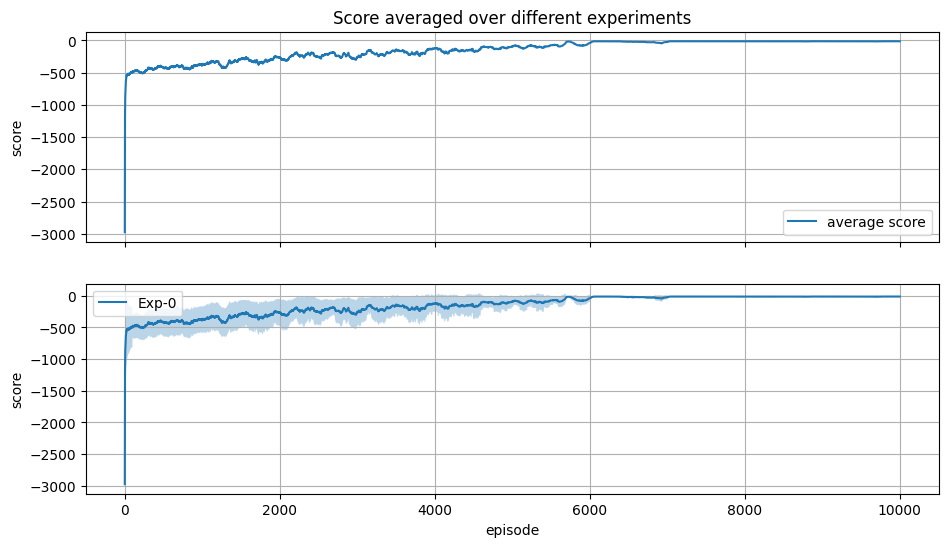

In [13]:
plot_results(avg_scores, std_scores)

And the **Accumulating** trace method.

In [16]:
N_EXPERIMENTS = 1
N_EPISODES = 10000
MAX_STEPS = 500
LEARNING_RATE = 3e-4
GAMMA = 0.99
LAMBDA = 0.76
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / int(N_EPISODES * 0.1)
TRACE_METHOD = "Accumulating"


scores = []
avg_scores = []
std_scores = []
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    env = gym.make("CliffWalking-v0")
    agent = SarsaLambdaTabularAgent(env.observation_space.n, 
                                    env.action_space.n, 
                                    GAMMA, 
                                    LAMBDA,
                                    LEARNING_RATE, 
                                    EPSILON,
                                    EPSILON_DEC,
                                    EPSILON_MIN,
                                    TRACE_METHOD)

    for ep_i in range(N_EPISODES):
        score = 0
        done = False
        step = 0

        observation, info = env.reset()
        action = agent.choose_action(observation)

        while not done:
            step += 1
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = agent.choose_action(next_observation)
            score += reward

            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))

            agent.learn(observation, action, reward, next_observation, next_action, terminated)
            observation = next_observation
            action = next_action
        print(f"| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {score:6.1f} |" +
              f"Avg Score: {avg_scores[ex_i][-1]:6.1f} |")

    env.close()

# save the results for later comparison
results_data_dict[TRACE_METHOD] = [avg_scores, std_scores]

| Experiment:    1 | Episode:    0 | Score: -2579.0 |Avg Score: -2579.0 |
| Experiment:    1 | Episode:    1 | Score: -401.0 |Avg Score: -1490.0 |
| Experiment:    1 | Episode:    2 | Score: -896.0 |Avg Score: -1292.0 |
| Experiment:    1 | Episode:    3 | Score: -599.0 |Avg Score: -1118.8 |
| Experiment:    1 | Episode:    4 | Score: -500.0 |Avg Score: -995.0 |
| Experiment:    1 | Episode:    5 | Score: -500.0 |Avg Score: -912.5 |
| Experiment:    1 | Episode:    6 | Score: -500.0 |Avg Score: -853.6 |
| Experiment:    1 | Episode:    7 | Score: -513.0 |Avg Score: -811.0 |
| Experiment:    1 | Episode:    8 | Score: -372.0 |Avg Score: -762.2 |
| Experiment:    1 | Episode:    9 | Score: -500.0 |Avg Score: -736.0 |
| Experiment:    1 | Episode:   10 | Score: -504.0 |Avg Score: -714.9 |
| Experiment:    1 | Episode:   11 | Score: -698.0 |Avg Score: -713.5 |
| Experiment:    1 | Episode:   12 | Score: -392.0 |Avg Score: -688.8 |
| Experiment:    1 | Episode:   13 | Score: -500.0 |Avg Sco

| Experiment:    1 | Episode:  176 | Score: -896.0 |Avg Score: -478.1 |
| Experiment:    1 | Episode:  177 | Score: -485.0 |Avg Score: -476.0 |
| Experiment:    1 | Episode:  178 | Score: -797.0 |Avg Score: -479.0 |
| Experiment:    1 | Episode:  179 | Score: -209.0 |Avg Score: -473.1 |
| Experiment:    1 | Episode:  180 | Score: -342.0 |Avg Score: -474.6 |
| Experiment:    1 | Episode:  181 | Score: -373.0 |Avg Score: -476.1 |
| Experiment:    1 | Episode:  182 | Score: -311.0 |Avg Score: -477.0 |
| Experiment:    1 | Episode:  183 | Score: -266.0 |Avg Score: -475.2 |
| Experiment:    1 | Episode:  184 | Score: -516.0 |Avg Score: -476.0 |
| Experiment:    1 | Episode:  185 | Score: -797.0 |Avg Score: -480.9 |
| Experiment:    1 | Episode:  186 | Score: -675.0 |Avg Score: -479.6 |
| Experiment:    1 | Episode:  187 | Score: -152.0 |Avg Score: -474.2 |
| Experiment:    1 | Episode:  188 | Score: -599.0 |Avg Score: -473.2 |
| Experiment:    1 | Episode:  189 | Score: -698.0 |Avg Score: -

| Experiment:    1 | Episode:  298 | Score: -698.0 |Avg Score: -449.2 |
| Experiment:    1 | Episode:  299 | Score: -265.0 |Avg Score: -445.9 |
| Experiment:    1 | Episode:  300 | Score: -404.0 |Avg Score: -444.9 |
| Experiment:    1 | Episode:  301 | Score: -116.0 |Avg Score: -436.1 |
| Experiment:    1 | Episode:  302 | Score: -698.0 |Avg Score: -438.1 |
| Experiment:    1 | Episode:  303 | Score: -577.0 |Avg Score: -442.9 |
| Experiment:    1 | Episode:  304 | Score: -797.0 |Avg Score: -448.2 |
| Experiment:    1 | Episode:  305 | Score: -599.0 |Avg Score: -447.2 |
| Experiment:    1 | Episode:  306 | Score: -500.0 |Avg Score: -447.2 |
| Experiment:    1 | Episode:  307 | Score: -698.0 |Avg Score: -449.1 |
| Experiment:    1 | Episode:  308 | Score: -599.0 |Avg Score: -451.8 |
| Experiment:    1 | Episode:  309 | Score: -698.0 |Avg Score: -449.3 |
| Experiment:    1 | Episode:  310 | Score: -599.0 |Avg Score: -448.6 |
| Experiment:    1 | Episode:  311 | Score: -562.0 |Avg Score: -

| Experiment:    1 | Episode:  425 | Score:  -94.0 |Avg Score: -388.2 |
| Experiment:    1 | Episode:  426 | Score: -896.0 |Avg Score: -395.3 |
| Experiment:    1 | Episode:  427 | Score:  -96.0 |Avg Score: -391.3 |
| Experiment:    1 | Episode:  428 | Score: -262.0 |Avg Score: -390.6 |
| Experiment:    1 | Episode:  429 | Score: -255.0 |Avg Score: -386.1 |
| Experiment:    1 | Episode:  430 | Score: -140.0 |Avg Score: -384.4 |
| Experiment:    1 | Episode:  431 | Score: -205.0 |Avg Score: -380.5 |
| Experiment:    1 | Episode:  432 | Score: -158.0 |Avg Score: -375.1 |
| Experiment:    1 | Episode:  433 | Score: -366.0 |Avg Score: -375.3 |
| Experiment:    1 | Episode:  434 | Score: -192.0 |Avg Score: -375.6 |
| Experiment:    1 | Episode:  435 | Score: -243.0 |Avg Score: -372.0 |
| Experiment:    1 | Episode:  436 | Score: -896.0 |Avg Score: -373.0 |
| Experiment:    1 | Episode:  437 | Score: -698.0 |Avg Score: -375.3 |
| Experiment:    1 | Episode:  438 | Score: -599.0 |Avg Score: -

| Experiment:    1 | Episode:  616 | Score: -641.0 |Avg Score: -356.2 |
| Experiment:    1 | Episode:  617 | Score: -128.0 |Avg Score: -355.0 |
| Experiment:    1 | Episode:  618 | Score: -640.0 |Avg Score: -357.2 |
| Experiment:    1 | Episode:  619 | Score: -435.0 |Avg Score: -358.2 |
| Experiment:    1 | Episode:  620 | Score: -197.0 |Avg Score: -352.2 |
| Experiment:    1 | Episode:  621 | Score: -123.0 |Avg Score: -350.7 |
| Experiment:    1 | Episode:  622 | Score: -300.0 |Avg Score: -348.7 |
| Experiment:    1 | Episode:  623 | Score: -195.0 |Avg Score: -347.6 |
| Experiment:    1 | Episode:  624 | Score: -195.0 |Avg Score: -342.6 |
| Experiment:    1 | Episode:  625 | Score: -253.0 |Avg Score: -341.5 |
| Experiment:    1 | Episode:  626 | Score: -599.0 |Avg Score: -342.4 |
| Experiment:    1 | Episode:  627 | Score: -347.0 |Avg Score: -338.9 |
| Experiment:    1 | Episode:  628 | Score: -131.0 |Avg Score: -336.7 |
| Experiment:    1 | Episode:  629 | Score: -896.0 |Avg Score: -

| Experiment:    1 | Episode:  773 | Score: -698.0 |Avg Score: -407.9 |
| Experiment:    1 | Episode:  774 | Score: -599.0 |Avg Score: -410.7 |
| Experiment:    1 | Episode:  775 | Score: -500.0 |Avg Score: -413.5 |
| Experiment:    1 | Episode:  776 | Score: -360.0 |Avg Score: -415.5 |
| Experiment:    1 | Episode:  777 | Score: -404.0 |Avg Score: -418.9 |
| Experiment:    1 | Episode:  778 | Score: -323.0 |Avg Score: -417.8 |
| Experiment:    1 | Episode:  779 | Score: -205.0 |Avg Score: -416.2 |
| Experiment:    1 | Episode:  780 | Score:  -41.0 |Avg Score: -410.6 |
| Experiment:    1 | Episode:  781 | Score: -115.0 |Avg Score: -410.2 |
| Experiment:    1 | Episode:  782 | Score: -797.0 |Avg Score: -409.2 |
| Experiment:    1 | Episode:  783 | Score: -896.0 |Avg Score: -416.1 |
| Experiment:    1 | Episode:  784 | Score: -500.0 |Avg Score: -419.1 |
| Experiment:    1 | Episode:  785 | Score: -500.0 |Avg Score: -418.1 |
| Experiment:    1 | Episode:  786 | Score: -500.0 |Avg Score: -

| Experiment:    1 | Episode:  901 | Score: -433.0 |Avg Score: -299.8 |
| Experiment:    1 | Episode:  902 | Score: -220.0 |Avg Score: -301.4 |
| Experiment:    1 | Episode:  903 | Score: -620.0 |Avg Score: -306.1 |
| Experiment:    1 | Episode:  904 | Score: -698.0 |Avg Score: -312.0 |
| Experiment:    1 | Episode:  905 | Score: -797.0 |Avg Score: -318.8 |
| Experiment:    1 | Episode:  906 | Score: -599.0 |Avg Score: -324.0 |
| Experiment:    1 | Episode:  907 | Score: -599.0 |Avg Score: -327.7 |
| Experiment:    1 | Episode:  908 | Score: -698.0 |Avg Score: -327.7 |
| Experiment:    1 | Episode:  909 | Score: -698.0 |Avg Score: -334.0 |
| Experiment:    1 | Episode:  910 | Score: -599.0 |Avg Score: -333.9 |
| Experiment:    1 | Episode:  911 | Score: -599.0 |Avg Score: -339.1 |
| Experiment:    1 | Episode:  912 | Score: -797.0 |Avg Score: -346.4 |
| Experiment:    1 | Episode:  913 | Score: -412.0 |Avg Score: -349.9 |
| Experiment:    1 | Episode:  914 | Score: -210.0 |Avg Score: -

| Experiment:    1 | Episode: 1046 | Score: -198.0 |Avg Score: -359.0 |
| Experiment:    1 | Episode: 1047 | Score:  -73.0 |Avg Score: -352.8 |
| Experiment:    1 | Episode: 1048 | Score: -160.0 |Avg Score: -344.5 |
| Experiment:    1 | Episode: 1049 | Score: -252.0 |Avg Score: -341.0 |
| Experiment:    1 | Episode: 1050 | Score: -859.0 |Avg Score: -342.6 |
| Experiment:    1 | Episode: 1051 | Score: -380.0 |Avg Score: -342.2 |
| Experiment:    1 | Episode: 1052 | Score: -801.0 |Avg Score: -347.1 |
| Experiment:    1 | Episode: 1053 | Score: -289.0 |Avg Score: -347.5 |
| Experiment:    1 | Episode: 1054 | Score: -113.0 |Avg Score: -342.8 |
| Experiment:    1 | Episode: 1055 | Score: -182.0 |Avg Score: -341.7 |
| Experiment:    1 | Episode: 1056 | Score: -449.0 |Avg Score: -345.0 |
| Experiment:    1 | Episode: 1057 | Score: -190.0 |Avg Score: -343.7 |
| Experiment:    1 | Episode: 1058 | Score: -264.0 |Avg Score: -340.1 |
| Experiment:    1 | Episode: 1059 | Score: -130.0 |Avg Score: -

| Experiment:    1 | Episode: 1254 | Score: -168.0 |Avg Score: -239.2 |
| Experiment:    1 | Episode: 1255 | Score: -122.0 |Avg Score: -239.4 |
| Experiment:    1 | Episode: 1256 | Score: -249.0 |Avg Score: -240.5 |
| Experiment:    1 | Episode: 1257 | Score: -547.0 |Avg Score: -243.4 |
| Experiment:    1 | Episode: 1258 | Score: -141.0 |Avg Score: -243.8 |
| Experiment:    1 | Episode: 1259 | Score: -326.0 |Avg Score: -238.0 |
| Experiment:    1 | Episode: 1260 | Score: -367.0 |Avg Score: -234.6 |
| Experiment:    1 | Episode: 1261 | Score: -214.0 |Avg Score: -228.7 |
| Experiment:    1 | Episode: 1262 | Score: -154.0 |Avg Score: -229.8 |
| Experiment:    1 | Episode: 1263 | Score:  -85.0 |Avg Score: -230.2 |
| Experiment:    1 | Episode: 1264 | Score: -456.0 |Avg Score: -233.7 |
| Experiment:    1 | Episode: 1265 | Score: -797.0 |Avg Score: -239.1 |
| Experiment:    1 | Episode: 1266 | Score: -995.0 |Avg Score: -248.5 |
| Experiment:    1 | Episode: 1267 | Score: -173.0 |Avg Score: -

| Experiment:    1 | Episode: 1385 | Score: -302.0 |Avg Score: -310.4 |
| Experiment:    1 | Episode: 1386 | Score: -443.0 |Avg Score: -310.2 |
| Experiment:    1 | Episode: 1387 | Score: -242.0 |Avg Score: -309.6 |
| Experiment:    1 | Episode: 1388 | Score: -457.0 |Avg Score: -312.5 |
| Experiment:    1 | Episode: 1389 | Score: -287.0 |Avg Score: -312.6 |
| Experiment:    1 | Episode: 1390 | Score: -599.0 |Avg Score: -314.4 |
| Experiment:    1 | Episode: 1391 | Score: -115.0 |Avg Score: -309.5 |
| Experiment:    1 | Episode: 1392 | Score: -159.0 |Avg Score: -308.5 |
| Experiment:    1 | Episode: 1393 | Score: -332.0 |Avg Score: -310.7 |
| Experiment:    1 | Episode: 1394 | Score: -639.0 |Avg Score: -315.2 |
| Experiment:    1 | Episode: 1395 | Score: -110.0 |Avg Score: -315.5 |
| Experiment:    1 | Episode: 1396 | Score: -351.0 |Avg Score: -311.0 |
| Experiment:    1 | Episode: 1397 | Score: -123.0 |Avg Score: -309.7 |
| Experiment:    1 | Episode: 1398 | Score: -132.0 |Avg Score: -

| Experiment:    1 | Episode: 1572 | Score: -126.0 |Avg Score: -285.6 |
| Experiment:    1 | Episode: 1573 | Score: -537.0 |Avg Score: -288.0 |
| Experiment:    1 | Episode: 1574 | Score: -564.0 |Avg Score: -291.6 |
| Experiment:    1 | Episode: 1575 | Score: -599.0 |Avg Score: -296.5 |
| Experiment:    1 | Episode: 1576 | Score: -500.0 |Avg Score: -295.5 |
| Experiment:    1 | Episode: 1577 | Score: -354.0 |Avg Score: -292.1 |
| Experiment:    1 | Episode: 1578 | Score: -224.0 |Avg Score: -291.1 |
| Experiment:    1 | Episode: 1579 | Score: -599.0 |Avg Score: -296.1 |
| Experiment:    1 | Episode: 1580 | Score:  -48.0 |Avg Score: -295.0 |
| Experiment:    1 | Episode: 1581 | Score: -145.0 |Avg Score: -291.4 |
| Experiment:    1 | Episode: 1582 | Score: -112.0 |Avg Score: -291.0 |
| Experiment:    1 | Episode: 1583 | Score: -142.0 |Avg Score: -288.2 |
| Experiment:    1 | Episode: 1584 | Score: -329.0 |Avg Score: -290.3 |
| Experiment:    1 | Episode: 1585 | Score: -517.0 |Avg Score: -

| Experiment:    1 | Episode: 1786 | Score: -228.0 |Avg Score: -251.9 |
| Experiment:    1 | Episode: 1787 | Score: -146.0 |Avg Score: -249.6 |
| Experiment:    1 | Episode: 1788 | Score: -647.0 |Avg Score: -254.7 |
| Experiment:    1 | Episode: 1789 | Score: -115.0 |Avg Score: -254.0 |
| Experiment:    1 | Episode: 1790 | Score: -181.0 |Avg Score: -255.2 |
| Experiment:    1 | Episode: 1791 | Score: -159.0 |Avg Score: -250.8 |
| Experiment:    1 | Episode: 1792 | Score: -130.0 |Avg Score: -251.2 |
| Experiment:    1 | Episode: 1793 | Score: -595.0 |Avg Score: -250.6 |
| Experiment:    1 | Episode: 1794 | Score: -490.0 |Avg Score: -254.1 |
| Experiment:    1 | Episode: 1795 | Score: -109.0 |Avg Score: -251.6 |
| Experiment:    1 | Episode: 1796 | Score: -253.0 |Avg Score: -252.6 |
| Experiment:    1 | Episode: 1797 | Score: -303.0 |Avg Score: -254.7 |
| Experiment:    1 | Episode: 1798 | Score:  -93.0 |Avg Score: -247.6 |
| Experiment:    1 | Episode: 1799 | Score: -689.0 |Avg Score: -

| Experiment:    1 | Episode: 1951 | Score: -995.0 |Avg Score: -249.0 |
| Experiment:    1 | Episode: 1952 | Score:  -68.0 |Avg Score: -244.8 |
| Experiment:    1 | Episode: 1953 | Score:  -52.0 |Avg Score: -237.4 |
| Experiment:    1 | Episode: 1954 | Score:  -70.0 |Avg Score: -232.1 |
| Experiment:    1 | Episode: 1955 | Score: -139.0 |Avg Score: -231.9 |
| Experiment:    1 | Episode: 1956 | Score:  -57.0 |Avg Score: -231.8 |
| Experiment:    1 | Episode: 1957 | Score:  -97.0 |Avg Score: -230.3 |
| Experiment:    1 | Episode: 1958 | Score:  -98.0 |Avg Score: -226.3 |
| Experiment:    1 | Episode: 1959 | Score:  -39.0 |Avg Score: -224.3 |
| Experiment:    1 | Episode: 1960 | Score:  -56.0 |Avg Score: -222.0 |
| Experiment:    1 | Episode: 1961 | Score:  -49.0 |Avg Score: -219.4 |
| Experiment:    1 | Episode: 1962 | Score:  -94.0 |Avg Score: -217.4 |
| Experiment:    1 | Episode: 1963 | Score: -123.0 |Avg Score: -216.4 |
| Experiment:    1 | Episode: 1964 | Score: -130.0 |Avg Score: -

| Experiment:    1 | Episode: 2169 | Score: -299.0 |Avg Score: -230.1 |
| Experiment:    1 | Episode: 2170 | Score:  -68.0 |Avg Score: -229.7 |
| Experiment:    1 | Episode: 2171 | Score: -530.0 |Avg Score: -233.7 |
| Experiment:    1 | Episode: 2172 | Score:  -74.0 |Avg Score: -232.6 |
| Experiment:    1 | Episode: 2173 | Score: -106.0 |Avg Score: -233.1 |
| Experiment:    1 | Episode: 2174 | Score: -152.0 |Avg Score: -231.8 |
| Experiment:    1 | Episode: 2175 | Score: -160.0 |Avg Score: -232.2 |
| Experiment:    1 | Episode: 2176 | Score: -156.0 |Avg Score: -232.8 |
| Experiment:    1 | Episode: 2177 | Score: -110.0 |Avg Score: -232.7 |
| Experiment:    1 | Episode: 2178 | Score:  -83.0 |Avg Score: -229.2 |
| Experiment:    1 | Episode: 2179 | Score:  -94.0 |Avg Score: -226.3 |
| Experiment:    1 | Episode: 2180 | Score: -390.0 |Avg Score: -227.4 |
| Experiment:    1 | Episode: 2181 | Score: -150.0 |Avg Score: -226.1 |
| Experiment:    1 | Episode: 2182 | Score: -102.0 |Avg Score: -

| Experiment:    1 | Episode: 2369 | Score: -343.0 |Avg Score: -231.2 |
| Experiment:    1 | Episode: 2370 | Score: -388.0 |Avg Score: -232.6 |
| Experiment:    1 | Episode: 2371 | Score:  -30.0 |Avg Score: -231.7 |
| Experiment:    1 | Episode: 2372 | Score: -210.0 |Avg Score: -231.8 |
| Experiment:    1 | Episode: 2373 | Score: -125.0 |Avg Score: -231.8 |
| Experiment:    1 | Episode: 2374 | Score: -135.0 |Avg Score: -231.9 |
| Experiment:    1 | Episode: 2375 | Score: -358.0 |Avg Score: -235.0 |
| Experiment:    1 | Episode: 2376 | Score:  -98.0 |Avg Score: -225.7 |
| Experiment:    1 | Episode: 2377 | Score: -130.0 |Avg Score: -225.8 |
| Experiment:    1 | Episode: 2378 | Score: -509.0 |Avg Score: -229.7 |
| Experiment:    1 | Episode: 2379 | Score:  -93.0 |Avg Score: -228.6 |
| Experiment:    1 | Episode: 2380 | Score:  -84.0 |Avg Score: -228.1 |
| Experiment:    1 | Episode: 2381 | Score: -677.0 |Avg Score: -232.9 |
| Experiment:    1 | Episode: 2382 | Score: -152.0 |Avg Score: -

| Experiment:    1 | Episode: 2632 | Score: -995.0 |Avg Score: -160.3 |
| Experiment:    1 | Episode: 2633 | Score: -347.0 |Avg Score: -161.7 |
| Experiment:    1 | Episode: 2634 | Score: -150.0 |Avg Score: -158.0 |
| Experiment:    1 | Episode: 2635 | Score: -137.0 |Avg Score: -158.6 |
| Experiment:    1 | Episode: 2636 | Score: -139.0 |Avg Score: -159.5 |
| Experiment:    1 | Episode: 2637 | Score: -265.0 |Avg Score: -161.5 |
| Experiment:    1 | Episode: 2638 | Score:  -62.0 |Avg Score: -161.6 |
| Experiment:    1 | Episode: 2639 | Score: -223.0 |Avg Score: -163.2 |
| Experiment:    1 | Episode: 2640 | Score: -678.0 |Avg Score: -169.2 |
| Experiment:    1 | Episode: 2641 | Score: -140.0 |Avg Score: -167.9 |
| Experiment:    1 | Episode: 2642 | Score: -111.0 |Avg Score: -168.0 |
| Experiment:    1 | Episode: 2643 | Score:  -92.0 |Avg Score: -167.6 |
| Experiment:    1 | Episode: 2644 | Score: -186.0 |Avg Score: -168.9 |
| Experiment:    1 | Episode: 2645 | Score: -103.0 |Avg Score: -

| Experiment:    1 | Episode: 2753 | Score: -500.0 |Avg Score: -197.3 |
| Experiment:    1 | Episode: 2754 | Score: -312.0 |Avg Score: -199.9 |
| Experiment:    1 | Episode: 2755 | Score: -268.0 |Avg Score: -193.6 |
| Experiment:    1 | Episode: 2756 | Score: -354.0 |Avg Score: -191.2 |
| Experiment:    1 | Episode: 2757 | Score: -596.0 |Avg Score: -192.1 |
| Experiment:    1 | Episode: 2758 | Score:  -71.0 |Avg Score: -183.9 |
| Experiment:    1 | Episode: 2759 | Score: -263.0 |Avg Score: -183.4 |
| Experiment:    1 | Episode: 2760 | Score: -331.0 |Avg Score: -185.2 |
| Experiment:    1 | Episode: 2761 | Score: -122.0 |Avg Score: -180.7 |
| Experiment:    1 | Episode: 2762 | Score: -489.0 |Avg Score: -184.6 |
| Experiment:    1 | Episode: 2763 | Score:  -80.0 |Avg Score: -182.3 |
| Experiment:    1 | Episode: 2764 | Score: -159.0 |Avg Score: -181.7 |
| Experiment:    1 | Episode: 2765 | Score: -146.0 |Avg Score: -182.5 |
| Experiment:    1 | Episode: 2766 | Score:  -33.0 |Avg Score: -

| Experiment:    1 | Episode: 2885 | Score:  -70.0 |Avg Score: -189.6 |
| Experiment:    1 | Episode: 2886 | Score:  -54.0 |Avg Score: -185.7 |
| Experiment:    1 | Episode: 2887 | Score: -139.0 |Avg Score: -183.3 |
| Experiment:    1 | Episode: 2888 | Score: -182.0 |Avg Score: -182.1 |
| Experiment:    1 | Episode: 2889 | Score: -460.0 |Avg Score: -184.4 |
| Experiment:    1 | Episode: 2890 | Score:  -50.0 |Avg Score: -184.4 |
| Experiment:    1 | Episode: 2891 | Score: -266.0 |Avg Score: -186.5 |
| Experiment:    1 | Episode: 2892 | Score: -390.0 |Avg Score: -189.4 |
| Experiment:    1 | Episode: 2893 | Score:  -79.0 |Avg Score: -189.0 |
| Experiment:    1 | Episode: 2894 | Score:  -85.0 |Avg Score: -189.1 |
| Experiment:    1 | Episode: 2895 | Score:  -98.0 |Avg Score: -189.3 |
| Experiment:    1 | Episode: 2896 | Score:  -45.0 |Avg Score: -188.6 |
| Experiment:    1 | Episode: 2897 | Score:  -92.0 |Avg Score: -189.1 |
| Experiment:    1 | Episode: 2898 | Score: -183.0 |Avg Score: -

| Experiment:    1 | Episode: 3022 | Score: -512.0 |Avg Score: -194.9 |
| Experiment:    1 | Episode: 3023 | Score: -205.0 |Avg Score: -195.6 |
| Experiment:    1 | Episode: 3024 | Score: -206.0 |Avg Score: -195.7 |
| Experiment:    1 | Episode: 3025 | Score: -141.0 |Avg Score: -196.2 |
| Experiment:    1 | Episode: 3026 | Score:  -87.0 |Avg Score: -196.3 |
| Experiment:    1 | Episode: 3027 | Score: -181.0 |Avg Score: -196.3 |
| Experiment:    1 | Episode: 3028 | Score: -222.0 |Avg Score: -197.7 |
| Experiment:    1 | Episode: 3029 | Score:  -65.0 |Avg Score: -198.0 |
| Experiment:    1 | Episode: 3030 | Score:  -29.0 |Avg Score: -197.4 |
| Experiment:    1 | Episode: 3031 | Score:  -64.0 |Avg Score: -197.8 |
| Experiment:    1 | Episode: 3032 | Score:  -68.0 |Avg Score: -197.4 |
| Experiment:    1 | Episode: 3033 | Score:  -63.0 |Avg Score: -197.5 |
| Experiment:    1 | Episode: 3034 | Score:  -50.0 |Avg Score: -197.3 |
| Experiment:    1 | Episode: 3035 | Score:  -47.0 |Avg Score: -

| Experiment:    1 | Episode: 3225 | Score: -393.0 |Avg Score: -175.0 |
| Experiment:    1 | Episode: 3226 | Score: -517.0 |Avg Score: -179.7 |
| Experiment:    1 | Episode: 3227 | Score:  -94.0 |Avg Score: -177.9 |
| Experiment:    1 | Episode: 3228 | Score: -111.0 |Avg Score: -178.8 |
| Experiment:    1 | Episode: 3229 | Score: -102.0 |Avg Score: -178.8 |
| Experiment:    1 | Episode: 3230 | Score:  -52.0 |Avg Score: -178.3 |
| Experiment:    1 | Episode: 3231 | Score:  -97.0 |Avg Score: -178.4 |
| Experiment:    1 | Episode: 3232 | Score:  -50.0 |Avg Score: -178.5 |
| Experiment:    1 | Episode: 3233 | Score:  -39.0 |Avg Score: -178.1 |
| Experiment:    1 | Episode: 3234 | Score:  -52.0 |Avg Score: -178.3 |
| Experiment:    1 | Episode: 3235 | Score: -114.0 |Avg Score: -177.4 |
| Experiment:    1 | Episode: 3236 | Score:  -50.0 |Avg Score: -176.3 |
| Experiment:    1 | Episode: 3237 | Score:  -69.0 |Avg Score: -175.9 |
| Experiment:    1 | Episode: 3238 | Score: -698.0 |Avg Score: -

| Experiment:    1 | Episode: 3360 | Score: -199.0 |Avg Score: -178.7 |
| Experiment:    1 | Episode: 3361 | Score: -166.0 |Avg Score: -179.9 |
| Experiment:    1 | Episode: 3362 | Score:  -63.0 |Avg Score: -179.6 |
| Experiment:    1 | Episode: 3363 | Score:  -43.0 |Avg Score: -179.2 |
| Experiment:    1 | Episode: 3364 | Score:  -79.0 |Avg Score: -179.3 |
| Experiment:    1 | Episode: 3365 | Score:  -56.0 |Avg Score: -179.3 |
| Experiment:    1 | Episode: 3366 | Score: -202.0 |Avg Score: -180.9 |
| Experiment:    1 | Episode: 3367 | Score:  -40.0 |Avg Score: -180.7 |
| Experiment:    1 | Episode: 3368 | Score:  -28.0 |Avg Score: -173.0 |
| Experiment:    1 | Episode: 3369 | Score:  -26.0 |Avg Score: -171.9 |
| Experiment:    1 | Episode: 3370 | Score:  -49.0 |Avg Score: -171.7 |
| Experiment:    1 | Episode: 3371 | Score:  -62.0 |Avg Score: -171.9 |
| Experiment:    1 | Episode: 3372 | Score:  -79.0 |Avg Score: -172.1 |
| Experiment:    1 | Episode: 3373 | Score:  -84.0 |Avg Score: -

| Experiment:    1 | Episode: 3525 | Score:  -57.0 |Avg Score: -148.3 |
| Experiment:    1 | Episode: 3526 | Score: -102.0 |Avg Score: -148.7 |
| Experiment:    1 | Episode: 3527 | Score:  -37.0 |Avg Score: -148.3 |
| Experiment:    1 | Episode: 3528 | Score:  -95.0 |Avg Score: -146.9 |
| Experiment:    1 | Episode: 3529 | Score: -252.0 |Avg Score: -143.4 |
| Experiment:    1 | Episode: 3530 | Score: -107.0 |Avg Score: -140.8 |
| Experiment:    1 | Episode: 3531 | Score: -476.0 |Avg Score: -143.8 |
| Experiment:    1 | Episode: 3532 | Score:  -53.0 |Avg Score: -143.1 |
| Experiment:    1 | Episode: 3533 | Score:  -40.0 |Avg Score: -142.9 |
| Experiment:    1 | Episode: 3534 | Score: -110.0 |Avg Score: -143.0 |
| Experiment:    1 | Episode: 3535 | Score:  -29.0 |Avg Score: -142.3 |
| Experiment:    1 | Episode: 3536 | Score: -205.0 |Avg Score: -139.8 |
| Experiment:    1 | Episode: 3537 | Score: -116.0 |Avg Score: -140.1 |
| Experiment:    1 | Episode: 3538 | Score: -218.0 |Avg Score: -

| Experiment:    1 | Episode: 3817 | Score:  -87.0 |Avg Score: -109.8 |
| Experiment:    1 | Episode: 3818 | Score:  -35.0 |Avg Score: -109.7 |
| Experiment:    1 | Episode: 3819 | Score:  -53.0 |Avg Score: -109.6 |
| Experiment:    1 | Episode: 3820 | Score:  -62.0 |Avg Score: -109.4 |
| Experiment:    1 | Episode: 3821 | Score:  -35.0 |Avg Score: -109.3 |
| Experiment:    1 | Episode: 3822 | Score:  -82.0 |Avg Score: -109.5 |
| Experiment:    1 | Episode: 3823 | Score:  -32.0 |Avg Score: -109.4 |
| Experiment:    1 | Episode: 3824 | Score:  -46.0 |Avg Score: -109.0 |
| Experiment:    1 | Episode: 3825 | Score:  -88.0 |Avg Score: -107.4 |
| Experiment:    1 | Episode: 3826 | Score:  -60.0 |Avg Score: -107.8 |
| Experiment:    1 | Episode: 3827 | Score: -103.0 |Avg Score: -108.4 |
| Experiment:    1 | Episode: 3828 | Score:  -44.0 |Avg Score: -108.4 |
| Experiment:    1 | Episode: 3829 | Score:  -32.0 |Avg Score: -108.2 |
| Experiment:    1 | Episode: 3830 | Score:  -33.0 |Avg Score: -

| Experiment:    1 | Episode: 4069 | Score:  -62.0 |Avg Score:  -90.2 |
| Experiment:    1 | Episode: 4070 | Score: -213.0 |Avg Score:  -92.2 |
| Experiment:    1 | Episode: 4071 | Score: -366.0 |Avg Score:  -95.5 |
| Experiment:    1 | Episode: 4072 | Score:  -63.0 |Avg Score:  -95.2 |
| Experiment:    1 | Episode: 4073 | Score:  -66.0 |Avg Score:  -95.5 |
| Experiment:    1 | Episode: 4074 | Score:  -46.0 |Avg Score:  -95.6 |
| Experiment:    1 | Episode: 4075 | Score:  -90.0 |Avg Score:  -96.2 |
| Experiment:    1 | Episode: 4076 | Score:  -80.0 |Avg Score:  -96.8 |
| Experiment:    1 | Episode: 4077 | Score:  -86.0 |Avg Score:  -97.1 |
| Experiment:    1 | Episode: 4078 | Score:  -39.0 |Avg Score:  -97.2 |
| Experiment:    1 | Episode: 4079 | Score: -896.0 |Avg Score: -105.9 |
| Experiment:    1 | Episode: 4080 | Score: -132.0 |Avg Score: -106.8 |
| Experiment:    1 | Episode: 4081 | Score: -867.0 |Avg Score: -115.2 |
| Experiment:    1 | Episode: 4082 | Score: -139.0 |Avg Score: -

| Experiment:    1 | Episode: 4266 | Score: -241.0 |Avg Score:  -95.2 |
| Experiment:    1 | Episode: 4267 | Score:  -76.0 |Avg Score:  -95.8 |
| Experiment:    1 | Episode: 4268 | Score:  -75.0 |Avg Score:  -96.3 |
| Experiment:    1 | Episode: 4269 | Score:  -90.0 |Avg Score:  -97.0 |
| Experiment:    1 | Episode: 4270 | Score:  -86.0 |Avg Score:  -97.3 |
| Experiment:    1 | Episode: 4271 | Score:  -29.0 |Avg Score:  -97.3 |
| Experiment:    1 | Episode: 4272 | Score:  -33.0 |Avg Score:  -97.2 |
| Experiment:    1 | Episode: 4273 | Score:  -36.0 |Avg Score:  -97.1 |
| Experiment:    1 | Episode: 4274 | Score:  -31.0 |Avg Score:  -97.2 |
| Experiment:    1 | Episode: 4275 | Score:  -27.0 |Avg Score:  -97.2 |
| Experiment:    1 | Episode: 4276 | Score:  -25.0 |Avg Score:  -95.6 |
| Experiment:    1 | Episode: 4277 | Score:  -39.0 |Avg Score:  -95.3 |
| Experiment:    1 | Episode: 4278 | Score:  -23.0 |Avg Score:  -94.5 |
| Experiment:    1 | Episode: 4279 | Score:  -85.0 |Avg Score:  

| Experiment:    1 | Episode: 4506 | Score:  -25.0 |Avg Score:  -98.2 |
| Experiment:    1 | Episode: 4507 | Score: -191.0 |Avg Score:  -99.7 |
| Experiment:    1 | Episode: 4508 | Score:  -25.0 |Avg Score:  -98.6 |
| Experiment:    1 | Episode: 4509 | Score:  -51.0 |Avg Score:  -93.8 |
| Experiment:    1 | Episode: 4510 | Score:  -35.0 |Avg Score:  -93.2 |
| Experiment:    1 | Episode: 4511 | Score:  -42.0 |Avg Score:  -91.7 |
| Experiment:    1 | Episode: 4512 | Score:  -23.0 |Avg Score:  -91.0 |
| Experiment:    1 | Episode: 4513 | Score:  -25.0 |Avg Score:  -89.7 |
| Experiment:    1 | Episode: 4514 | Score:  -52.0 |Avg Score:  -89.5 |
| Experiment:    1 | Episode: 4515 | Score:  -41.0 |Avg Score:  -88.8 |
| Experiment:    1 | Episode: 4516 | Score: -161.0 |Avg Score:  -89.7 |
| Experiment:    1 | Episode: 4517 | Score: -187.0 |Avg Score:  -90.3 |
| Experiment:    1 | Episode: 4518 | Score: -290.0 |Avg Score:  -92.9 |
| Experiment:    1 | Episode: 4519 | Score:  -52.0 |Avg Score:  

| Experiment:    1 | Episode: 4787 | Score: -797.0 |Avg Score: -115.7 |
| Experiment:    1 | Episode: 4788 | Score: -123.0 |Avg Score: -115.8 |
| Experiment:    1 | Episode: 4789 | Score:  -49.0 |Avg Score: -115.6 |
| Experiment:    1 | Episode: 4790 | Score:  -28.0 |Avg Score: -115.4 |
| Experiment:    1 | Episode: 4791 | Score:  -37.0 |Avg Score: -115.1 |
| Experiment:    1 | Episode: 4792 | Score: -180.0 |Avg Score: -116.2 |
| Experiment:    1 | Episode: 4793 | Score:  -69.0 |Avg Score: -116.3 |
| Experiment:    1 | Episode: 4794 | Score:  -59.0 |Avg Score: -116.1 |
| Experiment:    1 | Episode: 4795 | Score: -109.0 |Avg Score: -116.6 |
| Experiment:    1 | Episode: 4796 | Score: -379.0 |Avg Score: -118.7 |
| Experiment:    1 | Episode: 4797 | Score:  -69.0 |Avg Score: -118.7 |
| Experiment:    1 | Episode: 4798 | Score:  -58.0 |Avg Score: -119.0 |
| Experiment:    1 | Episode: 4799 | Score:  -87.0 |Avg Score: -119.6 |
| Experiment:    1 | Episode: 4800 | Score: -108.0 |Avg Score: -

| Experiment:    1 | Episode: 5101 | Score: -698.0 |Avg Score: -114.7 |
| Experiment:    1 | Episode: 5102 | Score: -698.0 |Avg Score: -120.8 |
| Experiment:    1 | Episode: 5103 | Score: -389.0 |Avg Score: -124.3 |
| Experiment:    1 | Episode: 5104 | Score: -365.0 |Avg Score: -127.2 |
| Experiment:    1 | Episode: 5105 | Score: -215.0 |Avg Score: -128.9 |
| Experiment:    1 | Episode: 5106 | Score:  -97.0 |Avg Score: -128.5 |
| Experiment:    1 | Episode: 5107 | Score: -246.0 |Avg Score: -129.9 |
| Experiment:    1 | Episode: 5108 | Score:  -77.0 |Avg Score: -130.1 |
| Experiment:    1 | Episode: 5109 | Score:  -97.0 |Avg Score: -129.6 |
| Experiment:    1 | Episode: 5110 | Score: -124.0 |Avg Score: -130.3 |
| Experiment:    1 | Episode: 5111 | Score:  -45.0 |Avg Score: -129.5 |
| Experiment:    1 | Episode: 5112 | Score: -245.0 |Avg Score: -131.7 |
| Experiment:    1 | Episode: 5113 | Score:  -65.0 |Avg Score: -131.3 |
| Experiment:    1 | Episode: 5114 | Score: -428.0 |Avg Score: -

| Experiment:    1 | Episode: 6341 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6342 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6343 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6344 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6345 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6346 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6347 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6348 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6349 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6350 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6351 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6352 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6353 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 6354 | Score:  -15.0 |Avg Score:  

| Experiment:    1 | Episode: 7347 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7348 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7349 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7350 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7351 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7352 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7353 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7354 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7355 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7356 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7357 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7358 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7359 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 7360 | Score:  -15.0 |Avg Score:  

| Experiment:    1 | Episode: 8450 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8451 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8452 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8453 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8454 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8455 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8456 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8457 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8458 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8459 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8460 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8461 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8462 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 8463 | Score:  -15.0 |Avg Score:  

| Experiment:    1 | Episode: 9470 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9471 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9472 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9473 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9474 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9475 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9476 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9477 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9478 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9479 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9480 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9481 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9482 | Score:  -15.0 |Avg Score:  -15.0 |
| Experiment:    1 | Episode: 9483 | Score:  -15.0 |Avg Score:  

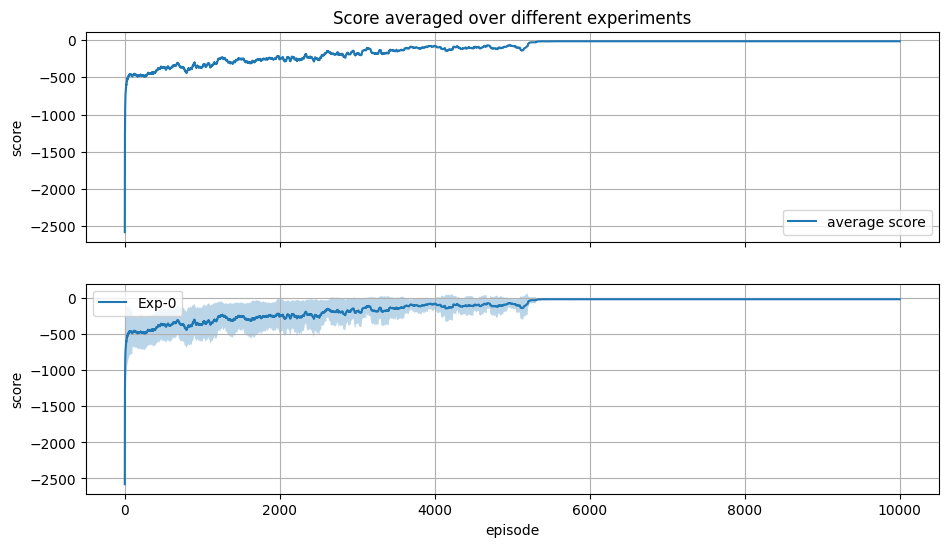

In [17]:
plot_results(avg_scores, std_scores)

Below you can see a comparison of the two previous experiments.

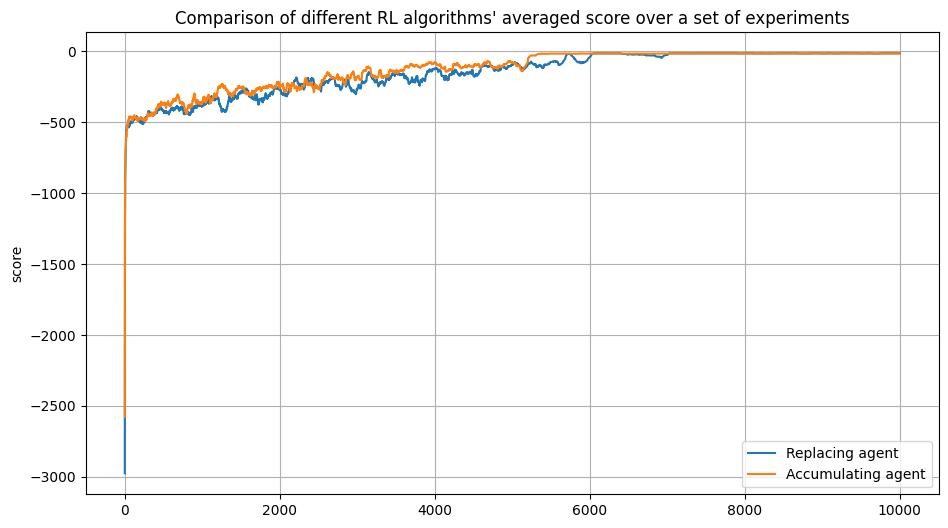

In [18]:
compare_results(results_data_dict)

We can see in the plot above that for the chosen $\lambda$ and $\gamma$ values, there is not much of a difference in performance. In addition, both algorithms converge to the optimal value of the environment, which is $-15$. Notice that the shortest path has a value of $-13$, which is better, but due to the stochasticity of the environment, walking close to the edge has a falling risk, which essentially results in a worse value than $-13$.

## Deep SARSA($\lambda$) with and without a Replay Buffer

Next, we code the **Deep** version of **SARSA($\lambda$)** and compare its versions with and without an Experience Repley Buffer. For a comprehensive description of the Experience Repley Buffer concept, you should check out [4].
There are a few important remarks to make in the **deep** version:
1. In order to use the Eligibility Traces method with a parametrized Q-function (a Deep network in our case), one needs to update the function parameters' update manually.
2. In Pytorch, skip the `self.q.optimizer.step()` line and code the update manually using the `Tensor.copy_()` function.
3. The parameters manual update should be carried out under a `Torch.no_grad()` condition because we would like the update operation to not be added to the computational graph.
4. Finally, in the current implementation I set $\delta = MSE(G_t, Q(S, A))$. However, I have also experienced defining $\delta=G_t-Q(S, A)$ with no apparent difference in the results.

A pseudocode of the Deep SARSA($\lambda$) algorithm is illustrated below.

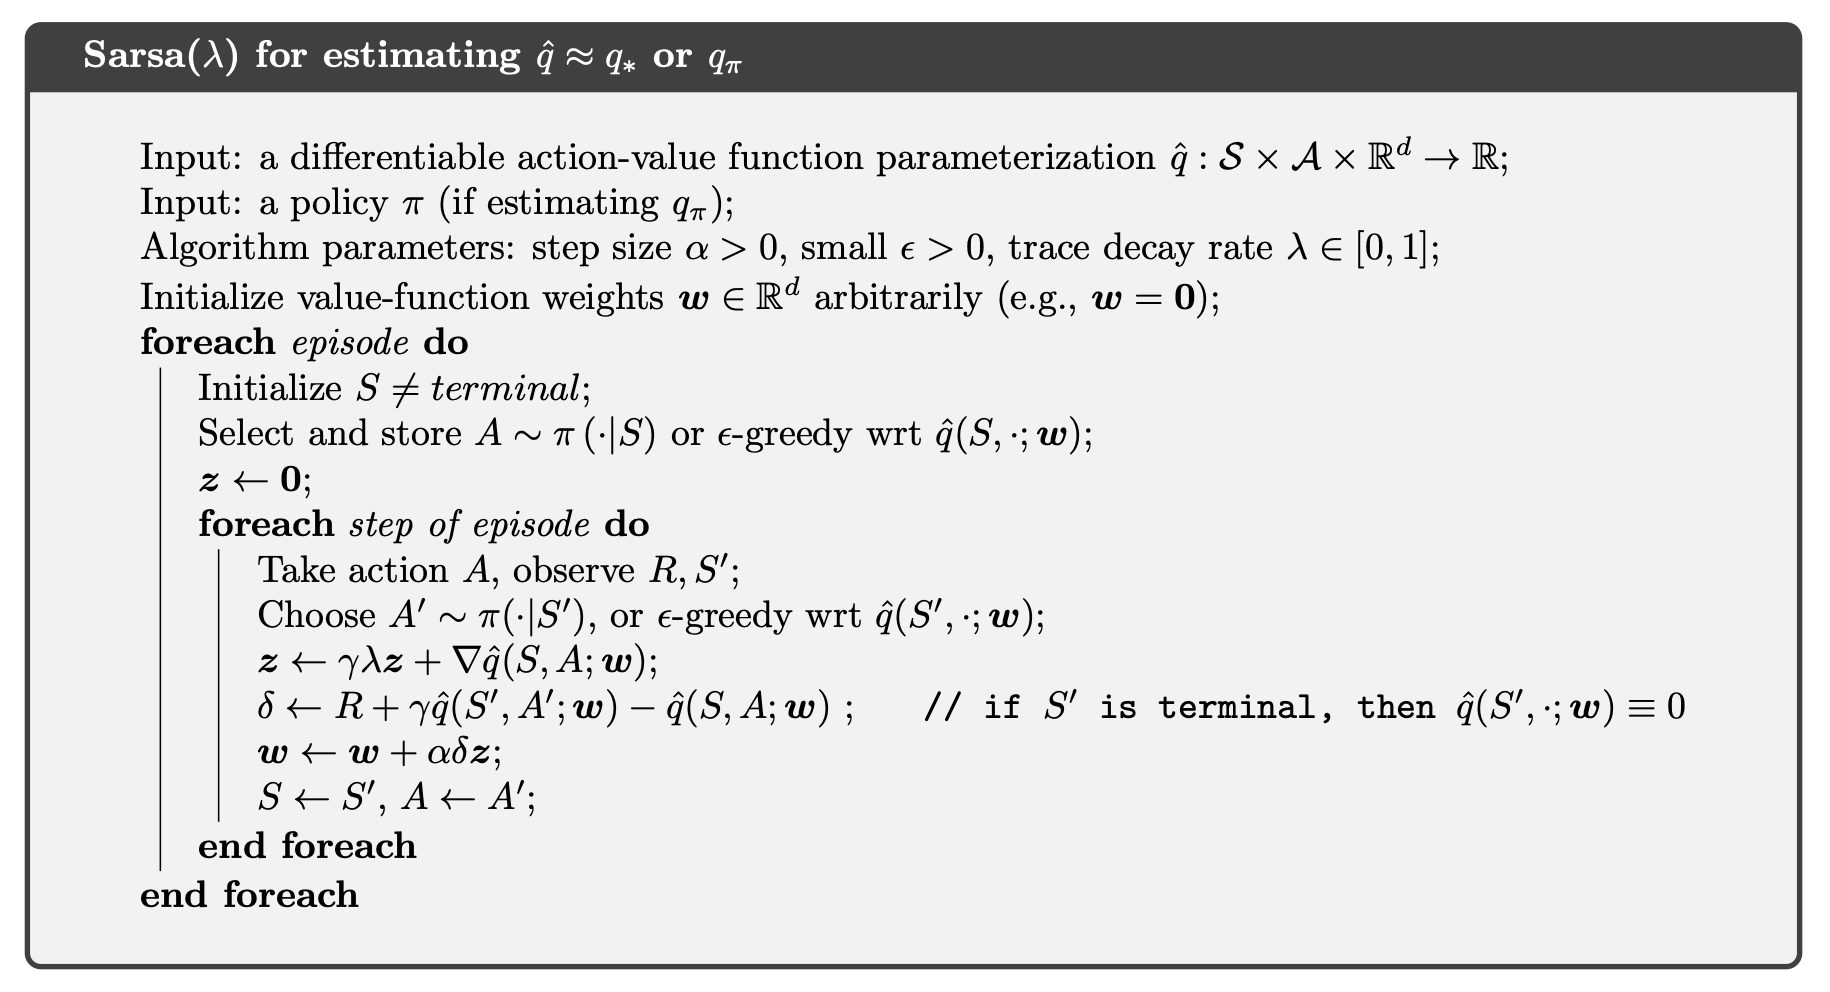

We begin with coding the Q-Network.

In [41]:
results_data_dict = {}

In [42]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        
        self.fc1 = nn.Linear(in_features=self.observation_dim, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.out_layer = nn.Linear(in_features=256, out_features=self.action_dim)
        
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.out_layer(x)
        return x

Then, we code the agent class (without a Replay Buffer)

In [57]:
class SarsaLambdaAgent:
    def __init__(self, observation_dim, action_dim, gamma, lmbd, learning_rate, epsilon, epsilon_dec, epsilon_min):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lmbd = lmbd
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        
        # q-network
        self.q = QNetwork(observation_dim=self.observation_dim, action_dim=self.action_dim, 
                          learning_rate=self.learning_rate)
        
        # eligibility trace
        self.z = []
        for param in self.q.parameters():
            self.z.append(T.zeros_like(param).to(self.q.device))
            
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim, size=1)[0]
        else:
            observation = T.tensor(observation).to(self.q.device)
            with T.no_grad():
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
                observation.detach()
        return action
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon_min, self.epsilon - self.epsilon_dec])
        
    def learn(self, observation, action, reward, next_observation, next_action, terminated):
        # send transition to device
        observation = T.tensor(observation).float().to(self.q.device)
        action = T.tensor([action]).int().to(self.q.device)
        reward = T.tensor([reward]).float().to(self.q.device)
        next_observation = T.tensor(next_observation).float().to(self.q.device)
        terminated = T.tensor([terminated]).bool().to(self.q.device)
        
        # get q values
        q_value = self.q(observation)[action]
        
        # compute delta (TD error)
        next_q_value = self.q(next_observation)[next_action]
        if terminated:
            next_q_value = 0.
        target = reward + self.gamma * next_q_value
        
        # compute the gradients of q
        self.q.optimizer.zero_grad()
        loss = F.mse_loss(target, q_value)
        loss.backward()
        
        # compute the trace
        with T.no_grad():
            for i, param in enumerate(self.q.parameters()):
                self.z[i] = self.gamma * self.lmbd * self.z[i] + param.grad
        
        # compute delta for updating the trace
        delta = loss
        
        # update the weights (backpropagate)
        with T.no_grad():
            for i, param in enumerate(self.q.parameters()):
                next_param = param - self.learning_rate * delta * self.z[i]
                param.copy_(next_param)
        
        # decrement epsilon
        self.decrement_epsilon()
        

And run a few experiments. Feel free to change the hyperparameters values and play with the code.

In [66]:
N_EXPERIMENTS = 3
N_EPISODES = 2000
MAX_STEPS = 500
LEARNING_RATE = 3e-4
GAMMA = 0.99
LAMBDA = 0.76
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / int(N_EPISODES * 0.1)


scores = []
avg_scores = []
std_scores = []
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    env = gym.make("CartPole-v1")
    agent = SarsaLambdaAgent(env.observation_space.shape[0], 
                             env.action_space.n, 
                             GAMMA, 
                             LAMBDA,
                             LEARNING_RATE, 
                             EPSILON,
                             EPSILON_DEC,
                             EPSILON_MIN)

    for ep_i in range(N_EPISODES):
        score = 0
        done = False
        step = 0

        observation, info = env.reset()
        action = agent.choose_action(observation)

        while not done:
            step += 1
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = agent.choose_action(next_observation)
            score += reward

            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))

            agent.learn(observation, action, reward, next_observation, next_action, terminated)
            observation = next_observation
            action = next_action
        print(f"| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {score:6.1f} |" +
              f"Avg Score: {avg_scores[ex_i][-1]:6.1f} |")

    env.close()

# save the results for later comparison
results_data_dict["No Buffer"] = [avg_scores, std_scores]

| Experiment:    1 | Episode:    0 | Score:   27.0 |Avg Score:   27.0 |
| Experiment:    1 | Episode:    1 | Score:   31.0 |Avg Score:   29.0 |
| Experiment:    1 | Episode:    2 | Score:   15.0 |Avg Score:   24.3 |
| Experiment:    1 | Episode:    3 | Score:   16.0 |Avg Score:   22.2 |
| Experiment:    1 | Episode:    4 | Score:   11.0 |Avg Score:   20.0 |
| Experiment:    1 | Episode:    5 | Score:   20.0 |Avg Score:   20.0 |
| Experiment:    1 | Episode:    6 | Score:   17.0 |Avg Score:   19.6 |
| Experiment:    1 | Episode:    7 | Score:   17.0 |Avg Score:   19.2 |
| Experiment:    1 | Episode:    8 | Score:   12.0 |Avg Score:   18.4 |
| Experiment:    1 | Episode:    9 | Score:   14.0 |Avg Score:   18.0 |
| Experiment:    1 | Episode:   10 | Score:   15.0 |Avg Score:   17.7 |
| Experiment:    1 | Episode:   11 | Score:   10.0 |Avg Score:   17.1 |
| Experiment:    1 | Episode:   12 | Score:    9.0 |Avg Score:   16.5 |
| Experiment:    1 | Episode:   13 | Score:   10.0 |Avg Score:  

| Experiment:    1 | Episode:  143 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  144 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  145 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  146 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  147 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  148 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  149 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  150 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  151 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  152 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  153 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  154 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  155 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  156 | Score:    8.0 |Avg Score:  

| Experiment:    1 | Episode:  294 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  295 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  296 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  297 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  298 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  299 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  300 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  301 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  302 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  303 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  304 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  305 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  306 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  307 | Score:   11.0 |Avg Score:  

| Experiment:    1 | Episode:  408 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  409 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  410 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  411 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  412 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  413 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  414 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  415 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  416 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  417 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  418 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  419 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  420 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  421 | Score:   10.0 |Avg Score:  

| Experiment:    1 | Episode:  542 | Score:    9.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  543 | Score:    9.0 |Avg Score:   10.7 |
| Experiment:    1 | Episode:  544 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    1 | Episode:  545 | Score:    9.0 |Avg Score:   10.6 |
| Experiment:    1 | Episode:  546 | Score:   10.0 |Avg Score:   10.5 |
| Experiment:    1 | Episode:  547 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    1 | Episode:  548 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode:  549 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  550 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  551 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  552 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  553 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  554 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  555 | Score:    9.0 |Avg Score:  

| Experiment:    1 | Episode:  656 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  657 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  658 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  659 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  660 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  661 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  662 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  663 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  664 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  665 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  666 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  667 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  668 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  669 | Score:   10.0 |Avg Score:  

| Experiment:    1 | Episode:  770 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  771 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    1 | Episode:  772 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  773 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  774 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  775 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  776 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  777 | Score:   12.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode:  778 | Score:   14.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  779 | Score:   14.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode:  780 | Score:   15.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode:  781 | Score:   15.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode:  782 | Score:   15.0 |Avg Score:    9.6 |
| Experiment:    1 | Episode:  783 | Score:   15.0 |Avg Score:  

| Experiment:    1 | Episode:  885 | Score:   78.0 |Avg Score:   47.8 |
| Experiment:    1 | Episode:  886 | Score:   44.0 |Avg Score:   47.8 |
| Experiment:    1 | Episode:  887 | Score:   32.0 |Avg Score:   47.8 |
| Experiment:    1 | Episode:  888 | Score:   49.0 |Avg Score:   47.6 |
| Experiment:    1 | Episode:  889 | Score:  117.0 |Avg Score:   48.2 |
| Experiment:    1 | Episode:  890 | Score:   35.0 |Avg Score:   47.9 |
| Experiment:    1 | Episode:  891 | Score:   41.0 |Avg Score:   47.6 |
| Experiment:    1 | Episode:  892 | Score:   36.0 |Avg Score:   47.4 |
| Experiment:    1 | Episode:  893 | Score:   87.0 |Avg Score:   47.8 |
| Experiment:    1 | Episode:  894 | Score:   33.0 |Avg Score:   47.6 |
| Experiment:    1 | Episode:  895 | Score:   39.0 |Avg Score:   47.6 |
| Experiment:    1 | Episode:  896 | Score:   53.0 |Avg Score:   47.9 |
| Experiment:    1 | Episode:  897 | Score:   49.0 |Avg Score:   48.1 |
| Experiment:    1 | Episode:  898 | Score:   50.0 |Avg Score:  

| Experiment:    1 | Episode: 1002 | Score:   44.0 |Avg Score:   55.8 |
| Experiment:    1 | Episode: 1003 | Score:  145.0 |Avg Score:   56.8 |
| Experiment:    1 | Episode: 1004 | Score:   57.0 |Avg Score:   56.7 |
| Experiment:    1 | Episode: 1005 | Score:   55.0 |Avg Score:   56.0 |
| Experiment:    1 | Episode: 1006 | Score:   47.0 |Avg Score:   56.0 |
| Experiment:    1 | Episode: 1007 | Score:   45.0 |Avg Score:   56.0 |
| Experiment:    1 | Episode: 1008 | Score:  150.0 |Avg Score:   57.0 |
| Experiment:    1 | Episode: 1009 | Score:   97.0 |Avg Score:   56.9 |
| Experiment:    1 | Episode: 1010 | Score:   34.0 |Avg Score:   56.8 |
| Experiment:    1 | Episode: 1011 | Score:   40.0 |Avg Score:   56.8 |
| Experiment:    1 | Episode: 1012 | Score:   46.0 |Avg Score:   56.8 |
| Experiment:    1 | Episode: 1013 | Score:   51.0 |Avg Score:   56.9 |
| Experiment:    1 | Episode: 1014 | Score:   45.0 |Avg Score:   56.9 |
| Experiment:    1 | Episode: 1015 | Score:   35.0 |Avg Score:  

| Experiment:    1 | Episode: 1117 | Score:   36.0 |Avg Score:   56.9 |
| Experiment:    1 | Episode: 1118 | Score:   48.0 |Avg Score:   57.0 |
| Experiment:    1 | Episode: 1119 | Score:   46.0 |Avg Score:   57.1 |
| Experiment:    1 | Episode: 1120 | Score:   53.0 |Avg Score:   57.0 |
| Experiment:    1 | Episode: 1121 | Score:   40.0 |Avg Score:   57.1 |
| Experiment:    1 | Episode: 1122 | Score:   49.0 |Avg Score:   57.1 |
| Experiment:    1 | Episode: 1123 | Score:  124.0 |Avg Score:   58.0 |
| Experiment:    1 | Episode: 1124 | Score:   52.0 |Avg Score:   58.1 |
| Experiment:    1 | Episode: 1125 | Score:   76.0 |Avg Score:   58.2 |
| Experiment:    1 | Episode: 1126 | Score:   51.0 |Avg Score:   58.4 |
| Experiment:    1 | Episode: 1127 | Score:   67.0 |Avg Score:   58.6 |
| Experiment:    1 | Episode: 1128 | Score:  104.0 |Avg Score:   59.1 |
| Experiment:    1 | Episode: 1129 | Score:   37.0 |Avg Score:   58.7 |
| Experiment:    1 | Episode: 1130 | Score:   43.0 |Avg Score:  

| Experiment:    1 | Episode: 1234 | Score:   98.0 |Avg Score:   59.3 |
| Experiment:    1 | Episode: 1235 | Score:   95.0 |Avg Score:   59.8 |
| Experiment:    1 | Episode: 1236 | Score:   35.0 |Avg Score:   59.5 |
| Experiment:    1 | Episode: 1237 | Score:   33.0 |Avg Score:   59.5 |
| Experiment:    1 | Episode: 1238 | Score:   52.0 |Avg Score:   59.6 |
| Experiment:    1 | Episode: 1239 | Score:   48.0 |Avg Score:   59.5 |
| Experiment:    1 | Episode: 1240 | Score:   40.0 |Avg Score:   59.4 |
| Experiment:    1 | Episode: 1241 | Score:   74.0 |Avg Score:   59.6 |
| Experiment:    1 | Episode: 1242 | Score:   54.0 |Avg Score:   59.8 |
| Experiment:    1 | Episode: 1243 | Score:  108.0 |Avg Score:   60.4 |
| Experiment:    1 | Episode: 1244 | Score:   33.0 |Avg Score:   60.4 |
| Experiment:    1 | Episode: 1245 | Score:   34.0 |Avg Score:   60.1 |
| Experiment:    1 | Episode: 1246 | Score:   51.0 |Avg Score:   60.2 |
| Experiment:    1 | Episode: 1247 | Score:   80.0 |Avg Score:  

| Experiment:    1 | Episode: 1350 | Score:   78.0 |Avg Score:   48.4 |
| Experiment:    1 | Episode: 1351 | Score:   48.0 |Avg Score:   48.4 |
| Experiment:    1 | Episode: 1352 | Score:   47.0 |Avg Score:   47.9 |
| Experiment:    1 | Episode: 1353 | Score:   45.0 |Avg Score:   48.0 |
| Experiment:    1 | Episode: 1354 | Score:   39.0 |Avg Score:   48.0 |
| Experiment:    1 | Episode: 1355 | Score:   51.0 |Avg Score:   48.1 |
| Experiment:    1 | Episode: 1356 | Score:   50.0 |Avg Score:   48.2 |
| Experiment:    1 | Episode: 1357 | Score:   31.0 |Avg Score:   48.2 |
| Experiment:    1 | Episode: 1358 | Score:   38.0 |Avg Score:   48.1 |
| Experiment:    1 | Episode: 1359 | Score:   62.0 |Avg Score:   48.4 |
| Experiment:    1 | Episode: 1360 | Score:   40.0 |Avg Score:   48.3 |
| Experiment:    1 | Episode: 1361 | Score:   30.0 |Avg Score:   48.3 |
| Experiment:    1 | Episode: 1362 | Score:   30.0 |Avg Score:   48.2 |
| Experiment:    1 | Episode: 1363 | Score:   47.0 |Avg Score:  

| Experiment:    1 | Episode: 1465 | Score:   39.0 |Avg Score:   45.8 |
| Experiment:    1 | Episode: 1466 | Score:   38.0 |Avg Score:   45.7 |
| Experiment:    1 | Episode: 1467 | Score:   40.0 |Avg Score:   45.8 |
| Experiment:    1 | Episode: 1468 | Score:   38.0 |Avg Score:   45.6 |
| Experiment:    1 | Episode: 1469 | Score:   54.0 |Avg Score:   45.9 |
| Experiment:    1 | Episode: 1470 | Score:  129.0 |Avg Score:   46.8 |
| Experiment:    1 | Episode: 1471 | Score:   76.0 |Avg Score:   47.1 |
| Experiment:    1 | Episode: 1472 | Score:   31.0 |Avg Score:   47.0 |
| Experiment:    1 | Episode: 1473 | Score:   56.0 |Avg Score:   47.0 |
| Experiment:    1 | Episode: 1474 | Score:   29.0 |Avg Score:   47.0 |
| Experiment:    1 | Episode: 1475 | Score:   47.0 |Avg Score:   47.2 |
| Experiment:    1 | Episode: 1476 | Score:   78.0 |Avg Score:   47.0 |
| Experiment:    1 | Episode: 1477 | Score:   53.0 |Avg Score:   47.1 |
| Experiment:    1 | Episode: 1478 | Score:   42.0 |Avg Score:  

| Experiment:    1 | Episode: 1583 | Score:   57.0 |Avg Score:   56.4 |
| Experiment:    1 | Episode: 1584 | Score:  183.0 |Avg Score:   57.8 |
| Experiment:    1 | Episode: 1585 | Score:   94.0 |Avg Score:   57.9 |
| Experiment:    1 | Episode: 1586 | Score:   57.0 |Avg Score:   58.1 |
| Experiment:    1 | Episode: 1587 | Score:   67.0 |Avg Score:   58.5 |
| Experiment:    1 | Episode: 1588 | Score:   52.0 |Avg Score:   58.6 |
| Experiment:    1 | Episode: 1589 | Score:   36.0 |Avg Score:   58.4 |
| Experiment:    1 | Episode: 1590 | Score:   41.0 |Avg Score:   58.5 |
| Experiment:    1 | Episode: 1591 | Score:   35.0 |Avg Score:   58.5 |
| Experiment:    1 | Episode: 1592 | Score:   47.0 |Avg Score:   58.3 |
| Experiment:    1 | Episode: 1593 | Score:   75.0 |Avg Score:   58.6 |
| Experiment:    1 | Episode: 1594 | Score:   54.0 |Avg Score:   58.8 |
| Experiment:    1 | Episode: 1595 | Score:   58.0 |Avg Score:   59.0 |
| Experiment:    1 | Episode: 1596 | Score:   37.0 |Avg Score:  

| Experiment:    1 | Episode: 1729 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1730 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1731 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1732 | Score:   11.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1733 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1734 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1735 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1736 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1737 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1738 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1739 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1740 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1741 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1742 | Score:    9.0 |Avg Score:  

| Experiment:    1 | Episode: 1844 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1845 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1846 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1847 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1848 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1849 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1850 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1851 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1852 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1853 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1854 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1855 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1856 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1857 | Score:    8.0 |Avg Score:  

| Experiment:    1 | Episode: 1995 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1996 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1997 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1998 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1999 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:    0 | Score:   12.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:    1 | Score:   27.0 |Avg Score:   19.5 |
| Experiment:    2 | Episode:    2 | Score:    9.0 |Avg Score:   16.0 |
| Experiment:    2 | Episode:    3 | Score:   12.0 |Avg Score:   15.0 |
| Experiment:    2 | Episode:    4 | Score:    8.0 |Avg Score:   13.6 |
| Experiment:    2 | Episode:    5 | Score:   12.0 |Avg Score:   13.3 |
| Experiment:    2 | Episode:    6 | Score:   18.0 |Avg Score:   14.0 |
| Experiment:    2 | Episode:    7 | Score:   14.0 |Avg Score:   14.0 |
| Experiment:    2 | Episode:    8 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode:  143 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  144 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  145 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  146 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  147 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  148 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  149 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  150 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  151 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  152 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  153 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  154 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  155 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    2 | Episode:  156 | Score:   10.0 |Avg Score:  

| Experiment:    2 | Episode:  294 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  295 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  296 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  297 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  298 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  299 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  300 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  301 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  302 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  303 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  304 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  305 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  306 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  307 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode:  445 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  446 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  447 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  448 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  449 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  450 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  451 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  452 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  453 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  454 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  455 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  456 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  457 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode:  458 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode:  574 | Score:   16.0 |Avg Score:   11.6 |
| Experiment:    2 | Episode:  575 | Score:   16.0 |Avg Score:   11.6 |
| Experiment:    2 | Episode:  576 | Score:   16.0 |Avg Score:   11.7 |
| Experiment:    2 | Episode:  577 | Score:   19.0 |Avg Score:   11.8 |
| Experiment:    2 | Episode:  578 | Score:   26.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  579 | Score:   29.0 |Avg Score:   12.1 |
| Experiment:    2 | Episode:  580 | Score:   16.0 |Avg Score:   12.1 |
| Experiment:    2 | Episode:  581 | Score:   22.0 |Avg Score:   12.2 |
| Experiment:    2 | Episode:  582 | Score:   18.0 |Avg Score:   12.3 |
| Experiment:    2 | Episode:  583 | Score:   18.0 |Avg Score:   12.4 |
| Experiment:    2 | Episode:  584 | Score:   31.0 |Avg Score:   12.6 |
| Experiment:    2 | Episode:  585 | Score:   25.0 |Avg Score:   12.7 |
| Experiment:    2 | Episode:  586 | Score:   27.0 |Avg Score:   12.9 |
| Experiment:    2 | Episode:  587 | Score:   29.0 |Avg Score:  

| Experiment:    2 | Episode:  693 | Score:   39.0 |Avg Score:   53.1 |
| Experiment:    2 | Episode:  694 | Score:   54.0 |Avg Score:   53.4 |
| Experiment:    2 | Episode:  695 | Score:   35.0 |Avg Score:   53.6 |
| Experiment:    2 | Episode:  696 | Score:   35.0 |Avg Score:   53.7 |
| Experiment:    2 | Episode:  697 | Score:   50.0 |Avg Score:   54.0 |
| Experiment:    2 | Episode:  698 | Score:  100.0 |Avg Score:   54.7 |
| Experiment:    2 | Episode:  699 | Score:   36.0 |Avg Score:   54.7 |
| Experiment:    2 | Episode:  700 | Score:   49.0 |Avg Score:   54.4 |
| Experiment:    2 | Episode:  701 | Score:   54.0 |Avg Score:   54.7 |
| Experiment:    2 | Episode:  702 | Score:   45.0 |Avg Score:   54.8 |
| Experiment:    2 | Episode:  703 | Score:   47.0 |Avg Score:   54.8 |
| Experiment:    2 | Episode:  704 | Score:   31.0 |Avg Score:   54.8 |
| Experiment:    2 | Episode:  705 | Score:   39.0 |Avg Score:   54.7 |
| Experiment:    2 | Episode:  706 | Score:   40.0 |Avg Score:  

| Experiment:    2 | Episode:  809 | Score:   42.0 |Avg Score:   55.2 |
| Experiment:    2 | Episode:  810 | Score:  146.0 |Avg Score:   56.3 |
| Experiment:    2 | Episode:  811 | Score:   41.0 |Avg Score:   56.1 |
| Experiment:    2 | Episode:  812 | Score:   87.0 |Avg Score:   56.4 |
| Experiment:    2 | Episode:  813 | Score:   38.0 |Avg Score:   56.2 |
| Experiment:    2 | Episode:  814 | Score:   65.0 |Avg Score:   56.2 |
| Experiment:    2 | Episode:  815 | Score:   47.0 |Avg Score:   56.4 |
| Experiment:    2 | Episode:  816 | Score:   75.0 |Avg Score:   56.2 |
| Experiment:    2 | Episode:  817 | Score:  131.0 |Avg Score:   57.0 |
| Experiment:    2 | Episode:  818 | Score:   41.0 |Avg Score:   57.0 |
| Experiment:    2 | Episode:  819 | Score:   87.0 |Avg Score:   57.4 |
| Experiment:    2 | Episode:  820 | Score:   49.0 |Avg Score:   57.1 |
| Experiment:    2 | Episode:  821 | Score:   32.0 |Avg Score:   57.1 |
| Experiment:    2 | Episode:  822 | Score:   84.0 |Avg Score:  

| Experiment:    2 | Episode:  925 | Score:   84.0 |Avg Score:   54.9 |
| Experiment:    2 | Episode:  926 | Score:   35.0 |Avg Score:   54.3 |
| Experiment:    2 | Episode:  927 | Score:  104.0 |Avg Score:   54.5 |
| Experiment:    2 | Episode:  928 | Score:   48.0 |Avg Score:   54.6 |
| Experiment:    2 | Episode:  929 | Score:   53.0 |Avg Score:   54.8 |
| Experiment:    2 | Episode:  930 | Score:   48.0 |Avg Score:   55.0 |
| Experiment:    2 | Episode:  931 | Score:   45.0 |Avg Score:   54.7 |
| Experiment:    2 | Episode:  932 | Score:   34.0 |Avg Score:   53.8 |
| Experiment:    2 | Episode:  933 | Score:   47.0 |Avg Score:   53.9 |
| Experiment:    2 | Episode:  934 | Score:   90.0 |Avg Score:   54.2 |
| Experiment:    2 | Episode:  935 | Score:   87.0 |Avg Score:   54.6 |
| Experiment:    2 | Episode:  936 | Score:   50.0 |Avg Score:   54.5 |
| Experiment:    2 | Episode:  937 | Score:   63.0 |Avg Score:   54.6 |
| Experiment:    2 | Episode:  938 | Score:   73.0 |Avg Score:  

| Experiment:    2 | Episode: 1044 | Score:   47.0 |Avg Score:   48.8 |
| Experiment:    2 | Episode: 1045 | Score:   34.0 |Avg Score:   48.7 |
| Experiment:    2 | Episode: 1046 | Score:   63.0 |Avg Score:   49.0 |
| Experiment:    2 | Episode: 1047 | Score:   32.0 |Avg Score:   48.9 |
| Experiment:    2 | Episode: 1048 | Score:  117.0 |Avg Score:   49.5 |
| Experiment:    2 | Episode: 1049 | Score:   41.0 |Avg Score:   49.6 |
| Experiment:    2 | Episode: 1050 | Score:   54.0 |Avg Score:   49.7 |
| Experiment:    2 | Episode: 1051 | Score:   45.0 |Avg Score:   49.7 |
| Experiment:    2 | Episode: 1052 | Score:   41.0 |Avg Score:   49.2 |
| Experiment:    2 | Episode: 1053 | Score:   41.0 |Avg Score:   48.6 |
| Experiment:    2 | Episode: 1054 | Score:   58.0 |Avg Score:   48.8 |
| Experiment:    2 | Episode: 1055 | Score:   53.0 |Avg Score:   48.5 |
| Experiment:    2 | Episode: 1056 | Score:   58.0 |Avg Score:   48.7 |
| Experiment:    2 | Episode: 1057 | Score:   73.0 |Avg Score:  

| Experiment:    2 | Episode: 1158 | Score:   51.0 |Avg Score:   50.3 |
| Experiment:    2 | Episode: 1159 | Score:   44.0 |Avg Score:   50.3 |
| Experiment:    2 | Episode: 1160 | Score:   43.0 |Avg Score:   50.1 |
| Experiment:    2 | Episode: 1161 | Score:   32.0 |Avg Score:   49.9 |
| Experiment:    2 | Episode: 1162 | Score:   52.0 |Avg Score:   50.0 |
| Experiment:    2 | Episode: 1163 | Score:   34.0 |Avg Score:   50.0 |
| Experiment:    2 | Episode: 1164 | Score:   90.0 |Avg Score:   50.0 |
| Experiment:    2 | Episode: 1165 | Score:   30.0 |Avg Score:   49.9 |
| Experiment:    2 | Episode: 1166 | Score:   41.0 |Avg Score:   49.9 |
| Experiment:    2 | Episode: 1167 | Score:   40.0 |Avg Score:   49.9 |
| Experiment:    2 | Episode: 1168 | Score:   82.0 |Avg Score:   50.4 |
| Experiment:    2 | Episode: 1169 | Score:   41.0 |Avg Score:   50.3 |
| Experiment:    2 | Episode: 1170 | Score:   51.0 |Avg Score:   50.4 |
| Experiment:    2 | Episode: 1171 | Score:   42.0 |Avg Score:  

| Experiment:    2 | Episode: 1273 | Score:   65.0 |Avg Score:   54.4 |
| Experiment:    2 | Episode: 1274 | Score:   57.0 |Avg Score:   54.5 |
| Experiment:    2 | Episode: 1275 | Score:   51.0 |Avg Score:   54.4 |
| Experiment:    2 | Episode: 1276 | Score:   59.0 |Avg Score:   54.6 |
| Experiment:    2 | Episode: 1277 | Score:   54.0 |Avg Score:   54.3 |
| Experiment:    2 | Episode: 1278 | Score:   63.0 |Avg Score:   54.5 |
| Experiment:    2 | Episode: 1279 | Score:   29.0 |Avg Score:   54.3 |
| Experiment:    2 | Episode: 1280 | Score:   91.0 |Avg Score:   55.0 |
| Experiment:    2 | Episode: 1281 | Score:   72.0 |Avg Score:   55.0 |
| Experiment:    2 | Episode: 1282 | Score:   32.0 |Avg Score:   55.0 |
| Experiment:    2 | Episode: 1283 | Score:   45.0 |Avg Score:   55.1 |
| Experiment:    2 | Episode: 1284 | Score:   33.0 |Avg Score:   54.9 |
| Experiment:    2 | Episode: 1285 | Score:   62.0 |Avg Score:   55.2 |
| Experiment:    2 | Episode: 1286 | Score:   49.0 |Avg Score:  

| Experiment:    2 | Episode: 1390 | Score:   57.0 |Avg Score:   57.2 |
| Experiment:    2 | Episode: 1391 | Score:   37.0 |Avg Score:   56.7 |
| Experiment:    2 | Episode: 1392 | Score:   57.0 |Avg Score:   56.7 |
| Experiment:    2 | Episode: 1393 | Score:   40.0 |Avg Score:   56.6 |
| Experiment:    2 | Episode: 1394 | Score:   43.0 |Avg Score:   56.2 |
| Experiment:    2 | Episode: 1395 | Score:   39.0 |Avg Score:   56.1 |
| Experiment:    2 | Episode: 1396 | Score:   61.0 |Avg Score:   56.0 |
| Experiment:    2 | Episode: 1397 | Score:   91.0 |Avg Score:   56.5 |
| Experiment:    2 | Episode: 1398 | Score:   58.0 |Avg Score:   56.6 |
| Experiment:    2 | Episode: 1399 | Score:   82.0 |Avg Score:   57.0 |
| Experiment:    2 | Episode: 1400 | Score:   39.0 |Avg Score:   57.0 |
| Experiment:    2 | Episode: 1401 | Score:   42.0 |Avg Score:   56.8 |
| Experiment:    2 | Episode: 1402 | Score:   49.0 |Avg Score:   56.7 |
| Experiment:    2 | Episode: 1403 | Score:   87.0 |Avg Score:  

| Experiment:    2 | Episode: 1507 | Score:    8.0 |Avg Score:   31.0 |
| Experiment:    2 | Episode: 1508 | Score:   10.0 |Avg Score:   30.7 |
| Experiment:    2 | Episode: 1509 | Score:   10.0 |Avg Score:   30.3 |
| Experiment:    2 | Episode: 1510 | Score:    9.0 |Avg Score:   29.6 |
| Experiment:    2 | Episode: 1511 | Score:    9.0 |Avg Score:   29.0 |
| Experiment:    2 | Episode: 1512 | Score:    9.0 |Avg Score:   28.2 |
| Experiment:    2 | Episode: 1513 | Score:   11.0 |Avg Score:   28.0 |
| Experiment:    2 | Episode: 1514 | Score:   10.0 |Avg Score:   27.7 |
| Experiment:    2 | Episode: 1515 | Score:    9.0 |Avg Score:   27.4 |
| Experiment:    2 | Episode: 1516 | Score:    9.0 |Avg Score:   27.1 |
| Experiment:    2 | Episode: 1517 | Score:    8.0 |Avg Score:   26.6 |
| Experiment:    2 | Episode: 1518 | Score:    9.0 |Avg Score:   26.2 |
| Experiment:    2 | Episode: 1519 | Score:    9.0 |Avg Score:   25.9 |
| Experiment:    2 | Episode: 1520 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode: 1641 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1642 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1643 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1644 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1645 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1646 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1647 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1648 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1649 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1650 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1651 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1652 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1653 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1654 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode: 1791 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1792 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1793 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1794 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1795 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1796 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1797 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1798 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1799 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1800 | Score:    8.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1801 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1802 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1803 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1804 | Score:    8.0 |Avg Score:  

| Experiment:    2 | Episode: 1942 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1943 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1944 | Score:   11.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1945 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1946 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1947 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1948 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1949 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1950 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1951 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1952 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1953 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1954 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    2 | Episode: 1955 | Score:   10.0 |Avg Score:  

| Experiment:    3 | Episode:   75 | Score:    9.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:   76 | Score:    8.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:   77 | Score:    8.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:   78 | Score:   10.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:   79 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   80 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   81 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   82 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   83 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   84 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   85 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   86 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   87 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:   88 | Score:   10.0 |Avg Score:  

| Experiment:    3 | Episode:  223 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  224 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  225 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  226 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  227 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  228 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  229 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  230 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  231 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  232 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  233 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  234 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  235 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  236 | Score:    9.0 |Avg Score:  

| Experiment:    3 | Episode:  337 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  338 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  339 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  340 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  341 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  342 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  343 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  344 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  345 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  346 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  347 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  348 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  349 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  350 | Score:   10.0 |Avg Score:  

| Experiment:    3 | Episode:  482 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  483 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  484 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  485 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  486 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  487 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  488 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  489 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  490 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  491 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  492 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  493 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  494 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode:  495 | Score:    9.0 |Avg Score:  

| Experiment:    3 | Episode:  597 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  598 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  599 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  600 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  601 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  602 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  603 | Score:    9.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  604 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  605 | Score:   11.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  606 | Score:   11.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  607 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  608 | Score:    8.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  609 | Score:   10.0 |Avg Score:    9.2 |
| Experiment:    3 | Episode:  610 | Score:    9.0 |Avg Score:  

| Experiment:    3 | Episode:  734 | Score:   11.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  735 | Score:   12.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  736 | Score:   12.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  737 | Score:   12.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  738 | Score:    9.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  739 | Score:   11.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  740 | Score:   10.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  741 | Score:    8.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  742 | Score:    9.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  743 | Score:   11.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  744 | Score:   10.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  745 | Score:   11.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  746 | Score:   11.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  747 | Score:   10.0 |Avg Score:  

| Experiment:    3 | Episode:  849 | Score:   57.0 |Avg Score:   38.8 |
| Experiment:    3 | Episode:  850 | Score:   66.0 |Avg Score:   39.3 |
| Experiment:    3 | Episode:  851 | Score:   74.0 |Avg Score:   40.0 |
| Experiment:    3 | Episode:  852 | Score:   44.0 |Avg Score:   40.3 |
| Experiment:    3 | Episode:  853 | Score:   50.0 |Avg Score:   40.7 |
| Experiment:    3 | Episode:  854 | Score:   52.0 |Avg Score:   41.1 |
| Experiment:    3 | Episode:  855 | Score:   60.0 |Avg Score:   41.6 |
| Experiment:    3 | Episode:  856 | Score:   99.0 |Avg Score:   42.5 |
| Experiment:    3 | Episode:  857 | Score:   39.0 |Avg Score:   42.8 |
| Experiment:    3 | Episode:  858 | Score:   43.0 |Avg Score:   43.1 |
| Experiment:    3 | Episode:  859 | Score:   70.0 |Avg Score:   43.8 |
| Experiment:    3 | Episode:  860 | Score:   66.0 |Avg Score:   44.4 |
| Experiment:    3 | Episode:  861 | Score:   45.0 |Avg Score:   44.7 |
| Experiment:    3 | Episode:  862 | Score:   42.0 |Avg Score:  

| Experiment:    3 | Episode:  968 | Score:   41.0 |Avg Score:   55.7 |
| Experiment:    3 | Episode:  969 | Score:   33.0 |Avg Score:   55.5 |
| Experiment:    3 | Episode:  970 | Score:   28.0 |Avg Score:   55.2 |
| Experiment:    3 | Episode:  971 | Score:   29.0 |Avg Score:   55.0 |
| Experiment:    3 | Episode:  972 | Score:   49.0 |Avg Score:   54.9 |
| Experiment:    3 | Episode:  973 | Score:   45.0 |Avg Score:   54.8 |
| Experiment:    3 | Episode:  974 | Score:  111.0 |Avg Score:   55.5 |
| Experiment:    3 | Episode:  975 | Score:   51.0 |Avg Score:   55.6 |
| Experiment:    3 | Episode:  976 | Score:   40.0 |Avg Score:   55.5 |
| Experiment:    3 | Episode:  977 | Score:   30.0 |Avg Score:   55.1 |
| Experiment:    3 | Episode:  978 | Score:   47.0 |Avg Score:   55.1 |
| Experiment:    3 | Episode:  979 | Score:  162.0 |Avg Score:   56.3 |
| Experiment:    3 | Episode:  980 | Score:   41.0 |Avg Score:   56.3 |
| Experiment:    3 | Episode:  981 | Score:   58.0 |Avg Score:  

| Experiment:    3 | Episode: 1084 | Score:   46.0 |Avg Score:   50.8 |
| Experiment:    3 | Episode: 1085 | Score:  107.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1086 | Score:   61.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1087 | Score:   32.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1088 | Score:   87.0 |Avg Score:   51.4 |
| Experiment:    3 | Episode: 1089 | Score:   44.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1090 | Score:   33.0 |Avg Score:   51.2 |
| Experiment:    3 | Episode: 1091 | Score:   32.0 |Avg Score:   50.9 |
| Experiment:    3 | Episode: 1092 | Score:   48.0 |Avg Score:   51.0 |
| Experiment:    3 | Episode: 1093 | Score:   36.0 |Avg Score:   51.1 |
| Experiment:    3 | Episode: 1094 | Score:   79.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1095 | Score:   65.0 |Avg Score:   51.5 |
| Experiment:    3 | Episode: 1096 | Score:   32.0 |Avg Score:   50.8 |
| Experiment:    3 | Episode: 1097 | Score:   29.0 |Avg Score:  

| Experiment:    3 | Episode: 1201 | Score:   72.0 |Avg Score:   50.7 |
| Experiment:    3 | Episode: 1202 | Score:   39.0 |Avg Score:   50.5 |
| Experiment:    3 | Episode: 1203 | Score:   59.0 |Avg Score:   50.6 |
| Experiment:    3 | Episode: 1204 | Score:   42.0 |Avg Score:   50.7 |
| Experiment:    3 | Episode: 1205 | Score:   32.0 |Avg Score:   50.2 |
| Experiment:    3 | Episode: 1206 | Score:   55.0 |Avg Score:   50.4 |
| Experiment:    3 | Episode: 1207 | Score:   50.0 |Avg Score:   50.4 |
| Experiment:    3 | Episode: 1208 | Score:   75.0 |Avg Score:   50.8 |
| Experiment:    3 | Episode: 1209 | Score:   41.0 |Avg Score:   50.6 |
| Experiment:    3 | Episode: 1210 | Score:   46.0 |Avg Score:   50.5 |
| Experiment:    3 | Episode: 1211 | Score:   51.0 |Avg Score:   50.5 |
| Experiment:    3 | Episode: 1212 | Score:   41.0 |Avg Score:   50.0 |
| Experiment:    3 | Episode: 1213 | Score:   40.0 |Avg Score:   50.1 |
| Experiment:    3 | Episode: 1214 | Score:   55.0 |Avg Score:  

| Experiment:    3 | Episode: 1318 | Score:   97.0 |Avg Score:   49.5 |
| Experiment:    3 | Episode: 1319 | Score:   81.0 |Avg Score:   49.9 |
| Experiment:    3 | Episode: 1320 | Score:   54.0 |Avg Score:   50.1 |
| Experiment:    3 | Episode: 1321 | Score:   37.0 |Avg Score:   50.1 |
| Experiment:    3 | Episode: 1322 | Score:   30.0 |Avg Score:   49.4 |
| Experiment:    3 | Episode: 1323 | Score:   33.0 |Avg Score:   49.2 |
| Experiment:    3 | Episode: 1324 | Score:   63.0 |Avg Score:   49.5 |
| Experiment:    3 | Episode: 1325 | Score:   51.0 |Avg Score:   49.2 |
| Experiment:    3 | Episode: 1326 | Score:   52.0 |Avg Score:   49.2 |
| Experiment:    3 | Episode: 1327 | Score:   47.0 |Avg Score:   49.2 |
| Experiment:    3 | Episode: 1328 | Score:   32.0 |Avg Score:   49.0 |
| Experiment:    3 | Episode: 1329 | Score:   36.0 |Avg Score:   49.0 |
| Experiment:    3 | Episode: 1330 | Score:   47.0 |Avg Score:   49.2 |
| Experiment:    3 | Episode: 1331 | Score:   49.0 |Avg Score:  

| Experiment:    3 | Episode: 1438 | Score:   37.0 |Avg Score:   53.8 |
| Experiment:    3 | Episode: 1439 | Score:   89.0 |Avg Score:   53.9 |
| Experiment:    3 | Episode: 1440 | Score:   43.0 |Avg Score:   53.4 |
| Experiment:    3 | Episode: 1441 | Score:   42.0 |Avg Score:   53.4 |
| Experiment:    3 | Episode: 1442 | Score:   31.0 |Avg Score:   52.8 |
| Experiment:    3 | Episode: 1443 | Score:   33.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1444 | Score:   37.0 |Avg Score:   52.5 |
| Experiment:    3 | Episode: 1445 | Score:   39.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1446 | Score:   37.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1447 | Score:   37.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1448 | Score:   33.0 |Avg Score:   52.2 |
| Experiment:    3 | Episode: 1449 | Score:   77.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1450 | Score:   30.0 |Avg Score:   52.6 |
| Experiment:    3 | Episode: 1451 | Score:   43.0 |Avg Score:  

| Experiment:    3 | Episode: 1553 | Score:   58.0 |Avg Score:   59.3 |
| Experiment:    3 | Episode: 1554 | Score:   35.0 |Avg Score:   58.8 |
| Experiment:    3 | Episode: 1555 | Score:   53.0 |Avg Score:   59.0 |
| Experiment:    3 | Episode: 1556 | Score:   36.0 |Avg Score:   58.8 |
| Experiment:    3 | Episode: 1557 | Score:   35.0 |Avg Score:   58.3 |
| Experiment:    3 | Episode: 1558 | Score:   41.0 |Avg Score:   58.1 |
| Experiment:    3 | Episode: 1559 | Score:   46.0 |Avg Score:   58.1 |
| Experiment:    3 | Episode: 1560 | Score:   41.0 |Avg Score:   57.8 |
| Experiment:    3 | Episode: 1561 | Score:   48.0 |Avg Score:   57.9 |
| Experiment:    3 | Episode: 1562 | Score:   48.0 |Avg Score:   58.0 |
| Experiment:    3 | Episode: 1563 | Score:   53.0 |Avg Score:   58.0 |
| Experiment:    3 | Episode: 1564 | Score:   39.0 |Avg Score:   57.9 |
| Experiment:    3 | Episode: 1565 | Score:   48.0 |Avg Score:   57.7 |
| Experiment:    3 | Episode: 1566 | Score:   43.0 |Avg Score:  

| Experiment:    3 | Episode: 1680 | Score:    9.0 |Avg Score:   32.1 |
| Experiment:    3 | Episode: 1681 | Score:    9.0 |Avg Score:   31.4 |
| Experiment:    3 | Episode: 1682 | Score:   10.0 |Avg Score:   30.6 |
| Experiment:    3 | Episode: 1683 | Score:   10.0 |Avg Score:   30.4 |
| Experiment:    3 | Episode: 1684 | Score:   10.0 |Avg Score:   29.6 |
| Experiment:    3 | Episode: 1685 | Score:    9.0 |Avg Score:   29.0 |
| Experiment:    3 | Episode: 1686 | Score:   10.0 |Avg Score:   28.7 |
| Experiment:    3 | Episode: 1687 | Score:   10.0 |Avg Score:   28.4 |
| Experiment:    3 | Episode: 1688 | Score:   10.0 |Avg Score:   28.2 |
| Experiment:    3 | Episode: 1689 | Score:    8.0 |Avg Score:   27.7 |
| Experiment:    3 | Episode: 1690 | Score:    9.0 |Avg Score:   27.3 |
| Experiment:    3 | Episode: 1691 | Score:    9.0 |Avg Score:   26.7 |
| Experiment:    3 | Episode: 1692 | Score:    9.0 |Avg Score:   26.4 |
| Experiment:    3 | Episode: 1693 | Score:    9.0 |Avg Score:  

| Experiment:    3 | Episode: 1794 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1795 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1796 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1797 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1798 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1799 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1800 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1801 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1802 | Score:   11.0 |Avg Score:    9.4 |
| Experiment:    3 | Episode: 1803 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    3 | Episode: 1804 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    3 | Episode: 1805 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    3 | Episode: 1806 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    3 | Episode: 1807 | Score:    9.0 |Avg Score:  

| Experiment:    3 | Episode: 1908 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1909 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1910 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1911 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1912 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1913 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1914 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1915 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1916 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1917 | Score:   10.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1918 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1919 | Score:   11.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1920 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    3 | Episode: 1921 | Score:    9.0 |Avg Score:  

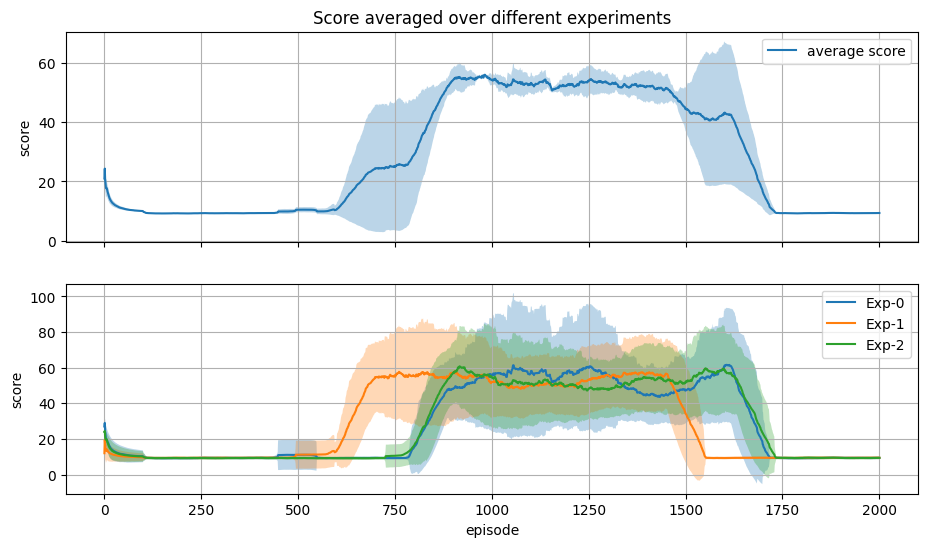

In [67]:
plot_results(avg_scores, std_scores)

It is clear from the results that the algorithm can enter a learning phase. However, the training process in all of the experiments was very unstable, resulting in losing its rhythm and diverging. There could be a few different explanations for that; one is the network having difficulty learning from the highly temporally-correlated experience, which is known to be a problem in the Deep Learning field. This could be dealt with using a large enough experience replay buffer which we could sample from, essentially resulting in iid transitions.

Next we code the Replay Buffer.

In [48]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.ptr = 0
        self.is_full = False
        
        self.observations = None
        self.actions = None
        self.rewards = None
        self.next_observations = None
        self.next_actions = None
        self.terminates = None
        
    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, 1), dtype=np.float32)
        self.next_observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.next_actions = np.zeros((self.memory_size, 1), dtype=int)
        self.terminates = np.zeros((self.memory_size, 1), dtype=bool)
        self.ptr = 0
    
    def store_transition(self, observation, action, reward, next_observation, next_action, terminated):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_observations[self.ptr] = next_observation
        self.next_actions[self.ptr] = next_action
        self.terminates[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr==0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")
    
    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return (self.observations[samples], self.actions[samples], self.rewards[samples], 
                self.next_observations[samples], self.next_actions[samples], self.terminates[samples])
    

And an agent class that would be able to support the usage of a Replay Buffer.

In [61]:
class SarsaLambdaAgentWithBuffer:
    def __init__(self, observation_dim, action_dim, gamma, lmbd, learning_rate, epsilon, epsilon_dec, epsilon_min, 
                memory_size):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lmbd = lmbd
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.memory_size = memory_size
        self.training_step = 0
        
        # initialize replay buffer
        self.replay_buffer = ReplayBuffer(memory_size=memory_size, observation_dim=observation_dim)
        self.replay_buffer.reset()
        
        # q-network
        self.q = QNetwork(observation_dim=self.observation_dim, action_dim=self.action_dim, 
                          learning_rate=self.learning_rate)
        
        # eligibility trace
        self.z = []
        for param in self.q.parameters():
            self.z.append(T.zeros_like(param).to(self.q.device))
            
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim, size=1)[0]
        else:
            observation = T.tensor(observation).to(self.q.device)
            with T.no_grad():
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
                observation.detach()
        return action
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon_min, self.epsilon - self.epsilon_dec])
        
    def store_transition(self, observation, action, reward, next_observation, next_action, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, next_action, terminated)
    
    def load_batch(self, batch_size=1):
        # sample new batch from buffer
        observation, action, reward, next_observation, next_action, terminated = self.replay_buffer.load_transition(
            batch_size=batch_size)
        
        # send batch to device
        observation = T.Tensor(observation).float().to(self.q.device)
        action = T.Tensor(action).int().view(-1).to(self.q.device)
        reward = T.Tensor(reward).float().view(-1).to(self.q.device)
        next_observation = T.Tensor(next_observation).float().to(self.q.device)
        next_action = T.Tensor(next_action).int().view(-1).to(self.q.device)
        terminated = T.Tensor(terminated).bool().view(-1).to(self.q.device)
        return observation, action, reward, next_observation, next_action, terminated
        
    def learn(self, batch_size=1):
        self.training_step += 1
        if self.training_step < batch_size:
            return
        
        # send observation to device
        observation, action, reward, next_observation, next_action, terminated = self.load_batch(batch_size=batch_size)
        
        # compute the values of observations S, S'
        indices = np.arange(batch_size)
        q_value = self.q(observation)[indices, action]
        next_q_value = self.q(next_observation)[indices, next_action]
        next_q_value[terminated] = 0.  # setting the terminal states values to zero by hand
        
        # compute the target
        target = reward + self.gamma * next_q_value
        
        # compute the gradients of q
        self.q.optimizer.zero_grad()
        loss = F.mse_loss(target, q_value)
        loss.backward()
        
        # compute the trace
        with T.no_grad():
            for i, param in enumerate(self.q.parameters()):
                self.z[i] = self.gamma * self.lmbd * self.z[i] + param.grad
        
        # compute delta for updating the trace
        delta = loss
        
        # update the weights (backpropagate)
        with T.no_grad():
            for i, param in enumerate(self.q.parameters()):
                next_param = param - self.learning_rate * delta * self.z[i]
                param.copy_(next_param)
        
        # decrement epsilon
        self.decrement_epsilon()
        

Finally, we run a few experiments with the same hyperparameters set as for the agent without the Replay Buffer.

In [62]:
N_EXPERIMENTS = 3
N_EPISODES = 2000
MAX_STEPS = 500
LEARNING_RATE = 3e-4
GAMMA = 0.99
LAMBDA = 0.76
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / int(N_EPISODES * 0.1)
MEMORY_SIZE = 100000
BATCH_SIZE = 4


scores = []
avg_scores = []
std_scores = []
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    env = gym.make("CartPole-v1")
    agent = SarsaLambdaAgentWithBuffer(env.observation_space.shape[0], 
                                       env.action_space.n, 
                                       GAMMA, 
                                       LAMBDA,
                                       LEARNING_RATE, 
                                       EPSILON,
                                       EPSILON_DEC,
                                       EPSILON_MIN,
                                       MEMORY_SIZE)

    for ep_i in range(N_EPISODES):
        score = 0
        done = False
        step = 0

        observation, info = env.reset()
        action = agent.choose_action(observation)

        while not done:
            step += 1
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = agent.choose_action(next_observation)
            score += reward

            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
                
            agent.store_transition(observation, action, reward, next_observation, next_action, terminated)
            agent.learn(batch_size=BATCH_SIZE)
            observation = next_observation
            action = next_action
        print(f"| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {score:6.1f} |" +
              f"Avg Score: {avg_scores[ex_i][-1]:6.1f} |")

    env.close()

# save the results for later comparison
results_data_dict["With Buffer"] = [avg_scores, std_scores]

reset buffer...
| Experiment:    1 | Episode:    0 | Score:   18.0 |Avg Score:   18.0 |
| Experiment:    1 | Episode:    1 | Score:   26.0 |Avg Score:   22.0 |
| Experiment:    1 | Episode:    2 | Score:   14.0 |Avg Score:   19.3 |
| Experiment:    1 | Episode:    3 | Score:   26.0 |Avg Score:   21.0 |
| Experiment:    1 | Episode:    4 | Score:   12.0 |Avg Score:   19.2 |
| Experiment:    1 | Episode:    5 | Score:   10.0 |Avg Score:   17.7 |
| Experiment:    1 | Episode:    6 | Score:   10.0 |Avg Score:   16.6 |
| Experiment:    1 | Episode:    7 | Score:   11.0 |Avg Score:   15.9 |
| Experiment:    1 | Episode:    8 | Score:   16.0 |Avg Score:   15.9 |
| Experiment:    1 | Episode:    9 | Score:   12.0 |Avg Score:   15.5 |
| Experiment:    1 | Episode:   10 | Score:   10.0 |Avg Score:   15.0 |
| Experiment:    1 | Episode:   11 | Score:    9.0 |Avg Score:   14.5 |
| Experiment:    1 | Episode:   12 | Score:   21.0 |Avg Score:   15.0 |
| Experiment:    1 | Episode:   13 | Score:   13

| Experiment:    1 | Episode:  119 | Score:   13.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  120 | Score:   13.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  121 | Score:   17.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  122 | Score:   17.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  123 | Score:   20.0 |Avg Score:   10.8 |
| Experiment:    1 | Episode:  124 | Score:   13.0 |Avg Score:   10.9 |
| Experiment:    1 | Episode:  125 | Score:   14.0 |Avg Score:   10.9 |
| Experiment:    1 | Episode:  126 | Score:   11.0 |Avg Score:   10.9 |
| Experiment:    1 | Episode:  127 | Score:   13.0 |Avg Score:   10.9 |
| Experiment:    1 | Episode:  128 | Score:   14.0 |Avg Score:   11.0 |
| Experiment:    1 | Episode:  129 | Score:   15.0 |Avg Score:   11.0 |
| Experiment:    1 | Episode:  130 | Score:   16.0 |Avg Score:   11.1 |
| Experiment:    1 | Episode:  131 | Score:   18.0 |Avg Score:   11.2 |
| Experiment:    1 | Episode:  132 | Score:   20.0 |Avg Score:  

| Experiment:    1 | Episode:  246 | Score:   11.0 |Avg Score:   13.3 |
| Experiment:    1 | Episode:  247 | Score:   12.0 |Avg Score:   13.4 |
| Experiment:    1 | Episode:  248 | Score:   15.0 |Avg Score:   13.4 |
| Experiment:    1 | Episode:  249 | Score:   20.0 |Avg Score:   13.5 |
| Experiment:    1 | Episode:  250 | Score:   18.0 |Avg Score:   13.5 |
| Experiment:    1 | Episode:  251 | Score:   18.0 |Avg Score:   13.6 |
| Experiment:    1 | Episode:  252 | Score:   21.0 |Avg Score:   13.6 |
| Experiment:    1 | Episode:  253 | Score:   14.0 |Avg Score:   13.7 |
| Experiment:    1 | Episode:  254 | Score:   14.0 |Avg Score:   13.7 |
| Experiment:    1 | Episode:  255 | Score:   17.0 |Avg Score:   13.7 |
| Experiment:    1 | Episode:  256 | Score:   16.0 |Avg Score:   13.8 |
| Experiment:    1 | Episode:  257 | Score:   15.0 |Avg Score:   13.8 |
| Experiment:    1 | Episode:  258 | Score:   13.0 |Avg Score:   13.8 |
| Experiment:    1 | Episode:  259 | Score:   11.0 |Avg Score:  

| Experiment:    1 | Episode:  362 | Score:   27.0 |Avg Score:   18.5 |
| Experiment:    1 | Episode:  363 | Score:   23.0 |Avg Score:   18.6 |
| Experiment:    1 | Episode:  364 | Score:   25.0 |Avg Score:   18.7 |
| Experiment:    1 | Episode:  365 | Score:   21.0 |Avg Score:   18.8 |
| Experiment:    1 | Episode:  366 | Score:   21.0 |Avg Score:   18.8 |
| Experiment:    1 | Episode:  367 | Score:   23.0 |Avg Score:   18.9 |
| Experiment:    1 | Episode:  368 | Score:   26.0 |Avg Score:   19.1 |
| Experiment:    1 | Episode:  369 | Score:   22.0 |Avg Score:   19.2 |
| Experiment:    1 | Episode:  370 | Score:   26.0 |Avg Score:   19.3 |
| Experiment:    1 | Episode:  371 | Score:   26.0 |Avg Score:   19.4 |
| Experiment:    1 | Episode:  372 | Score:   35.0 |Avg Score:   19.6 |
| Experiment:    1 | Episode:  373 | Score:   33.0 |Avg Score:   19.8 |
| Experiment:    1 | Episode:  374 | Score:   64.0 |Avg Score:   20.3 |
| Experiment:    1 | Episode:  375 | Score:   58.0 |Avg Score:  

| Experiment:    1 | Episode:  479 | Score:   23.0 |Avg Score:   39.7 |
| Experiment:    1 | Episode:  480 | Score:   11.0 |Avg Score:   39.4 |
| Experiment:    1 | Episode:  481 | Score:   15.0 |Avg Score:   39.2 |
| Experiment:    1 | Episode:  482 | Score:   18.0 |Avg Score:   39.0 |
| Experiment:    1 | Episode:  483 | Score:  160.0 |Avg Score:   39.8 |
| Experiment:    1 | Episode:  484 | Score:   82.0 |Avg Score:   40.2 |
| Experiment:    1 | Episode:  485 | Score:   46.0 |Avg Score:   39.7 |
| Experiment:    1 | Episode:  486 | Score:   52.0 |Avg Score:   40.2 |
| Experiment:    1 | Episode:  487 | Score:   12.0 |Avg Score:   40.2 |
| Experiment:    1 | Episode:  488 | Score:   30.0 |Avg Score:   40.4 |
| Experiment:    1 | Episode:  489 | Score:   62.0 |Avg Score:   40.9 |
| Experiment:    1 | Episode:  490 | Score:   24.0 |Avg Score:   41.1 |
| Experiment:    1 | Episode:  491 | Score:   24.0 |Avg Score:   41.2 |
| Experiment:    1 | Episode:  492 | Score:   27.0 |Avg Score:  

| Experiment:    1 | Episode:  597 | Score:   67.0 |Avg Score:   76.7 |
| Experiment:    1 | Episode:  598 | Score:  109.0 |Avg Score:   76.9 |
| Experiment:    1 | Episode:  599 | Score:   64.0 |Avg Score:   76.9 |
| Experiment:    1 | Episode:  600 | Score:   48.0 |Avg Score:   76.9 |
| Experiment:    1 | Episode:  601 | Score:   57.0 |Avg Score:   76.8 |
| Experiment:    1 | Episode:  602 | Score:   81.0 |Avg Score:   77.2 |
| Experiment:    1 | Episode:  603 | Score:   73.0 |Avg Score:   77.2 |
| Experiment:    1 | Episode:  604 | Score:   97.0 |Avg Score:   77.8 |
| Experiment:    1 | Episode:  605 | Score:   67.0 |Avg Score:   77.7 |
| Experiment:    1 | Episode:  606 | Score:  113.0 |Avg Score:   77.8 |
| Experiment:    1 | Episode:  607 | Score:   45.0 |Avg Score:   77.4 |
| Experiment:    1 | Episode:  608 | Score:   65.0 |Avg Score:   77.7 |
| Experiment:    1 | Episode:  609 | Score:   54.0 |Avg Score:   77.2 |
| Experiment:    1 | Episode:  610 | Score:   59.0 |Avg Score:  

| Experiment:    1 | Episode:  711 | Score:  254.0 |Avg Score:   82.8 |
| Experiment:    1 | Episode:  712 | Score:  199.0 |Avg Score:   84.3 |
| Experiment:    1 | Episode:  713 | Score:  176.0 |Avg Score:   85.5 |
| Experiment:    1 | Episode:  714 | Score:  303.0 |Avg Score:   87.7 |
| Experiment:    1 | Episode:  715 | Score:   79.0 |Avg Score:   88.1 |
| Experiment:    1 | Episode:  716 | Score:  150.0 |Avg Score:   88.7 |
| Experiment:    1 | Episode:  717 | Score:  125.0 |Avg Score:   89.5 |
| Experiment:    1 | Episode:  718 | Score:   56.0 |Avg Score:   89.2 |
| Experiment:    1 | Episode:  719 | Score:   96.0 |Avg Score:   89.2 |
| Experiment:    1 | Episode:  720 | Score:  104.0 |Avg Score:   89.0 |
| Experiment:    1 | Episode:  721 | Score:   95.0 |Avg Score:   89.2 |
| Experiment:    1 | Episode:  722 | Score:  112.0 |Avg Score:   89.9 |
| Experiment:    1 | Episode:  723 | Score:   92.0 |Avg Score:   88.5 |
| Experiment:    1 | Episode:  724 | Score:  117.0 |Avg Score:  

| Experiment:    1 | Episode:  827 | Score:  162.0 |Avg Score:  116.9 |
| Experiment:    1 | Episode:  828 | Score:  114.0 |Avg Score:  116.8 |
| Experiment:    1 | Episode:  829 | Score:  143.0 |Avg Score:  117.2 |
| Experiment:    1 | Episode:  830 | Score:  137.0 |Avg Score:  118.1 |
| Experiment:    1 | Episode:  831 | Score:   96.0 |Avg Score:  118.0 |
| Experiment:    1 | Episode:  832 | Score:  150.0 |Avg Score:  118.8 |
| Experiment:    1 | Episode:  833 | Score:  125.0 |Avg Score:  119.6 |
| Experiment:    1 | Episode:  834 | Score:  102.0 |Avg Score:  120.1 |
| Experiment:    1 | Episode:  835 | Score:  275.0 |Avg Score:  120.3 |
| Experiment:    1 | Episode:  836 | Score:  123.0 |Avg Score:  120.3 |
| Experiment:    1 | Episode:  837 | Score:  157.0 |Avg Score:  120.4 |
| Experiment:    1 | Episode:  838 | Score:  118.0 |Avg Score:  120.9 |
| Experiment:    1 | Episode:  839 | Score:  118.0 |Avg Score:  121.0 |
| Experiment:    1 | Episode:  840 | Score:  172.0 |Avg Score:  

| Experiment:    1 | Episode:  941 | Score:  136.0 |Avg Score:  149.5 |
| Experiment:    1 | Episode:  942 | Score:  226.0 |Avg Score:  150.6 |
| Experiment:    1 | Episode:  943 | Score:  142.0 |Avg Score:  151.4 |
| Experiment:    1 | Episode:  944 | Score:  127.0 |Avg Score:  151.6 |
| Experiment:    1 | Episode:  945 | Score:  137.0 |Avg Score:  152.1 |
| Experiment:    1 | Episode:  946 | Score:  148.0 |Avg Score:  152.0 |
| Experiment:    1 | Episode:  947 | Score:  146.0 |Avg Score:  152.1 |
| Experiment:    1 | Episode:  948 | Score:  148.0 |Avg Score:  153.0 |
| Experiment:    1 | Episode:  949 | Score:  105.0 |Avg Score:  153.1 |
| Experiment:    1 | Episode:  950 | Score:  205.0 |Avg Score:  153.9 |
| Experiment:    1 | Episode:  951 | Score:  139.0 |Avg Score:  154.4 |
| Experiment:    1 | Episode:  952 | Score:  185.0 |Avg Score:  155.2 |
| Experiment:    1 | Episode:  953 | Score:  130.0 |Avg Score:  155.9 |
| Experiment:    1 | Episode:  954 | Score:  172.0 |Avg Score:  

| Experiment:    1 | Episode: 1055 | Score:  180.0 |Avg Score:  178.2 |
| Experiment:    1 | Episode: 1056 | Score:  115.0 |Avg Score:  177.7 |
| Experiment:    1 | Episode: 1057 | Score:  151.0 |Avg Score:  177.0 |
| Experiment:    1 | Episode: 1058 | Score:  100.0 |Avg Score:  175.4 |
| Experiment:    1 | Episode: 1059 | Score:  136.0 |Avg Score:  175.3 |
| Experiment:    1 | Episode: 1060 | Score:  129.0 |Avg Score:  174.0 |
| Experiment:    1 | Episode: 1061 | Score:  128.0 |Avg Score:  174.0 |
| Experiment:    1 | Episode: 1062 | Score:  167.0 |Avg Score:  174.0 |
| Experiment:    1 | Episode: 1063 | Score:  135.0 |Avg Score:  173.6 |
| Experiment:    1 | Episode: 1064 | Score:  187.0 |Avg Score:  173.6 |
| Experiment:    1 | Episode: 1065 | Score:  178.0 |Avg Score:  174.3 |
| Experiment:    1 | Episode: 1066 | Score:  122.0 |Avg Score:  174.0 |
| Experiment:    1 | Episode: 1067 | Score:  128.0 |Avg Score:  173.8 |
| Experiment:    1 | Episode: 1068 | Score:  132.0 |Avg Score:  

| Experiment:    1 | Episode: 1171 | Score:  229.0 |Avg Score:  158.6 |
| Experiment:    1 | Episode: 1172 | Score:  137.0 |Avg Score:  156.8 |
| Experiment:    1 | Episode: 1173 | Score:  140.0 |Avg Score:  156.9 |
| Experiment:    1 | Episode: 1174 | Score:  149.0 |Avg Score:  157.0 |
| Experiment:    1 | Episode: 1175 | Score:  131.0 |Avg Score:  156.8 |
| Experiment:    1 | Episode: 1176 | Score:  123.0 |Avg Score:  156.4 |
| Experiment:    1 | Episode: 1177 | Score:  165.0 |Avg Score:  156.6 |
| Experiment:    1 | Episode: 1178 | Score:  271.0 |Avg Score:  158.2 |
| Experiment:    1 | Episode: 1179 | Score:  198.0 |Avg Score:  158.8 |
| Experiment:    1 | Episode: 1180 | Score:  135.0 |Avg Score:  157.8 |
| Experiment:    1 | Episode: 1181 | Score:  133.0 |Avg Score:  157.8 |
| Experiment:    1 | Episode: 1182 | Score:  163.0 |Avg Score:  157.7 |
| Experiment:    1 | Episode: 1183 | Score:  152.0 |Avg Score:  157.8 |
| Experiment:    1 | Episode: 1184 | Score:  152.0 |Avg Score:  

| Experiment:    1 | Episode: 1287 | Score:  132.0 |Avg Score:  143.7 |
| Experiment:    1 | Episode: 1288 | Score:  141.0 |Avg Score:  143.1 |
| Experiment:    1 | Episode: 1289 | Score:  136.0 |Avg Score:  142.9 |
| Experiment:    1 | Episode: 1290 | Score:  124.0 |Avg Score:  142.9 |
| Experiment:    1 | Episode: 1291 | Score:  120.0 |Avg Score:  141.9 |
| Experiment:    1 | Episode: 1292 | Score:  160.0 |Avg Score:  142.2 |
| Experiment:    1 | Episode: 1293 | Score:  152.0 |Avg Score:  142.3 |
| Experiment:    1 | Episode: 1294 | Score:  153.0 |Avg Score:  142.3 |
| Experiment:    1 | Episode: 1295 | Score:  167.0 |Avg Score:  142.4 |
| Experiment:    1 | Episode: 1296 | Score:  137.0 |Avg Score:  142.1 |
| Experiment:    1 | Episode: 1297 | Score:  129.0 |Avg Score:  141.4 |
| Experiment:    1 | Episode: 1298 | Score:  133.0 |Avg Score:  141.3 |
| Experiment:    1 | Episode: 1299 | Score:  170.0 |Avg Score:  141.3 |
| Experiment:    1 | Episode: 1300 | Score:  142.0 |Avg Score:  

| Experiment:    1 | Episode: 1401 | Score:  115.0 |Avg Score:  114.6 |
| Experiment:    1 | Episode: 1402 | Score:    9.0 |Avg Score:  113.3 |
| Experiment:    1 | Episode: 1403 | Score:   12.0 |Avg Score:  111.5 |
| Experiment:    1 | Episode: 1404 | Score:    9.0 |Avg Score:  110.2 |
| Experiment:    1 | Episode: 1405 | Score:   13.0 |Avg Score:  109.0 |
| Experiment:    1 | Episode: 1406 | Score:   11.0 |Avg Score:  107.9 |
| Experiment:    1 | Episode: 1407 | Score:   16.0 |Avg Score:  106.6 |
| Experiment:    1 | Episode: 1408 | Score:   14.0 |Avg Score:  105.2 |
| Experiment:    1 | Episode: 1409 | Score:    8.0 |Avg Score:  103.7 |
| Experiment:    1 | Episode: 1410 | Score:   10.0 |Avg Score:  102.3 |
| Experiment:    1 | Episode: 1411 | Score:   10.0 |Avg Score:  101.1 |
| Experiment:    1 | Episode: 1412 | Score:    8.0 |Avg Score:  100.0 |
| Experiment:    1 | Episode: 1413 | Score:   10.0 |Avg Score:   98.5 |
| Experiment:    1 | Episode: 1414 | Score:   10.0 |Avg Score:  

| Experiment:    1 | Episode: 1546 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1547 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1548 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1549 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1550 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1551 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1552 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1553 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1554 | Score:    8.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1555 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1556 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1557 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1558 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1559 | Score:    9.0 |Avg Score:  

| Experiment:    1 | Episode: 1690 | Score:   25.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1691 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1692 | Score:   33.0 |Avg Score:    9.7 |
| Experiment:    1 | Episode: 1693 | Score:   34.0 |Avg Score:    9.9 |
| Experiment:    1 | Episode: 1694 | Score:    9.0 |Avg Score:    9.9 |
| Experiment:    1 | Episode: 1695 | Score:    9.0 |Avg Score:    9.9 |
| Experiment:    1 | Episode: 1696 | Score:   10.0 |Avg Score:    9.9 |
| Experiment:    1 | Episode: 1697 | Score:   14.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1698 | Score:    9.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1699 | Score:    9.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1700 | Score:    9.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1701 | Score:   10.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1702 | Score:    9.0 |Avg Score:   10.0 |
| Experiment:    1 | Episode: 1703 | Score:    9.0 |Avg Score:  

| Experiment:    1 | Episode: 1828 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1829 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1830 | Score:   10.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1831 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1832 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1833 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1834 | Score:    8.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1835 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1836 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1837 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1838 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1839 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1840 | Score:    9.0 |Avg Score:    9.3 |
| Experiment:    1 | Episode: 1841 | Score:    9.0 |Avg Score:  

| Experiment:    1 | Episode: 1973 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1974 | Score:   11.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1975 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1976 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1977 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1978 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1979 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1980 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1981 | Score:   10.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1982 | Score:    9.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1983 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1984 | Score:    9.0 |Avg Score:    9.4 |
| Experiment:    1 | Episode: 1985 | Score:   11.0 |Avg Score:    9.5 |
| Experiment:    1 | Episode: 1986 | Score:    9.0 |Avg Score:  

| Experiment:    2 | Episode:  102 | Score:   11.0 |Avg Score:   10.6 |
| Experiment:    2 | Episode:  103 | Score:   11.0 |Avg Score:   10.4 |
| Experiment:    2 | Episode:  104 | Score:   10.0 |Avg Score:   10.4 |
| Experiment:    2 | Episode:  105 | Score:   11.0 |Avg Score:   10.4 |
| Experiment:    2 | Episode:  106 | Score:    8.0 |Avg Score:   10.4 |
| Experiment:    2 | Episode:  107 | Score:    8.0 |Avg Score:   10.3 |
| Experiment:    2 | Episode:  108 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    2 | Episode:  109 | Score:    9.0 |Avg Score:   10.3 |
| Experiment:    2 | Episode:  110 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    2 | Episode:  111 | Score:   11.0 |Avg Score:   10.2 |
| Experiment:    2 | Episode:  112 | Score:   12.0 |Avg Score:   10.2 |
| Experiment:    2 | Episode:  113 | Score:   10.0 |Avg Score:   10.0 |
| Experiment:    2 | Episode:  114 | Score:   12.0 |Avg Score:   10.1 |
| Experiment:    2 | Episode:  115 | Score:   15.0 |Avg Score:  

| Experiment:    2 | Episode:  219 | Score:   12.0 |Avg Score:   11.8 |
| Experiment:    2 | Episode:  220 | Score:   16.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  221 | Score:   15.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  222 | Score:   17.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:  223 | Score:   13.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  224 | Score:   14.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:  225 | Score:   16.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:  226 | Score:   13.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:  227 | Score:   14.0 |Avg Score:   12.0 |
| Experiment:    2 | Episode:  228 | Score:   11.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  229 | Score:   10.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  230 | Score:   11.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  231 | Score:   11.0 |Avg Score:   11.9 |
| Experiment:    2 | Episode:  232 | Score:   12.0 |Avg Score:  

| Experiment:    2 | Episode:  355 | Score:   19.0 |Avg Score:   13.0 |
| Experiment:    2 | Episode:  356 | Score:   17.0 |Avg Score:   13.1 |
| Experiment:    2 | Episode:  357 | Score:   17.0 |Avg Score:   13.1 |
| Experiment:    2 | Episode:  358 | Score:   16.0 |Avg Score:   13.1 |
| Experiment:    2 | Episode:  359 | Score:   13.0 |Avg Score:   13.1 |
| Experiment:    2 | Episode:  360 | Score:   16.0 |Avg Score:   13.1 |
| Experiment:    2 | Episode:  361 | Score:   15.0 |Avg Score:   13.2 |
| Experiment:    2 | Episode:  362 | Score:   13.0 |Avg Score:   13.2 |
| Experiment:    2 | Episode:  363 | Score:   13.0 |Avg Score:   13.3 |
| Experiment:    2 | Episode:  364 | Score:   13.0 |Avg Score:   13.3 |
| Experiment:    2 | Episode:  365 | Score:   13.0 |Avg Score:   13.3 |
| Experiment:    2 | Episode:  366 | Score:   18.0 |Avg Score:   13.3 |
| Experiment:    2 | Episode:  367 | Score:   19.0 |Avg Score:   13.4 |
| Experiment:    2 | Episode:  368 | Score:   14.0 |Avg Score:  

| Experiment:    2 | Episode:  475 | Score:   18.0 |Avg Score:   18.2 |
| Experiment:    2 | Episode:  476 | Score:   29.0 |Avg Score:   18.3 |
| Experiment:    2 | Episode:  477 | Score:   27.0 |Avg Score:   18.5 |
| Experiment:    2 | Episode:  478 | Score:   29.0 |Avg Score:   18.6 |
| Experiment:    2 | Episode:  479 | Score:   37.0 |Avg Score:   18.8 |
| Experiment:    2 | Episode:  480 | Score:   27.0 |Avg Score:   19.0 |
| Experiment:    2 | Episode:  481 | Score:   33.0 |Avg Score:   19.1 |
| Experiment:    2 | Episode:  482 | Score:   23.0 |Avg Score:   19.2 |
| Experiment:    2 | Episode:  483 | Score:   23.0 |Avg Score:   19.3 |
| Experiment:    2 | Episode:  484 | Score:   23.0 |Avg Score:   19.4 |
| Experiment:    2 | Episode:  485 | Score:   22.0 |Avg Score:   19.5 |
| Experiment:    2 | Episode:  486 | Score:   22.0 |Avg Score:   19.6 |
| Experiment:    2 | Episode:  487 | Score:   25.0 |Avg Score:   19.7 |
| Experiment:    2 | Episode:  488 | Score:   36.0 |Avg Score:  

| Experiment:    2 | Episode:  595 | Score:   50.0 |Avg Score:   37.4 |
| Experiment:    2 | Episode:  596 | Score:   32.0 |Avg Score:   37.2 |
| Experiment:    2 | Episode:  597 | Score:   21.0 |Avg Score:   36.9 |
| Experiment:    2 | Episode:  598 | Score:   29.0 |Avg Score:   36.8 |
| Experiment:    2 | Episode:  599 | Score:   26.0 |Avg Score:   36.7 |
| Experiment:    2 | Episode:  600 | Score:   21.0 |Avg Score:   36.3 |
| Experiment:    2 | Episode:  601 | Score:   56.0 |Avg Score:   36.5 |
| Experiment:    2 | Episode:  602 | Score:   25.0 |Avg Score:   36.3 |
| Experiment:    2 | Episode:  603 | Score:   25.0 |Avg Score:   36.2 |
| Experiment:    2 | Episode:  604 | Score:   39.0 |Avg Score:   36.2 |
| Experiment:    2 | Episode:  605 | Score:   28.0 |Avg Score:   36.0 |
| Experiment:    2 | Episode:  606 | Score:   22.0 |Avg Score:   35.7 |
| Experiment:    2 | Episode:  607 | Score:   17.0 |Avg Score:   34.1 |
| Experiment:    2 | Episode:  608 | Score:   26.0 |Avg Score:  

| Experiment:    2 | Episode:  711 | Score:   52.0 |Avg Score:   59.0 |
| Experiment:    2 | Episode:  712 | Score:   38.0 |Avg Score:   59.0 |
| Experiment:    2 | Episode:  713 | Score:  115.0 |Avg Score:   59.4 |
| Experiment:    2 | Episode:  714 | Score:   76.0 |Avg Score:   59.6 |
| Experiment:    2 | Episode:  715 | Score:   45.0 |Avg Score:   59.7 |
| Experiment:    2 | Episode:  716 | Score:   51.0 |Avg Score:   60.0 |
| Experiment:    2 | Episode:  717 | Score:   69.0 |Avg Score:   60.4 |
| Experiment:    2 | Episode:  718 | Score:   49.0 |Avg Score:   60.5 |
| Experiment:    2 | Episode:  719 | Score:   50.0 |Avg Score:   60.5 |
| Experiment:    2 | Episode:  720 | Score:   66.0 |Avg Score:   60.2 |
| Experiment:    2 | Episode:  721 | Score:   88.0 |Avg Score:   60.6 |
| Experiment:    2 | Episode:  722 | Score:   40.0 |Avg Score:   60.4 |
| Experiment:    2 | Episode:  723 | Score:   64.0 |Avg Score:   60.2 |
| Experiment:    2 | Episode:  724 | Score:   45.0 |Avg Score:  

| Experiment:    2 | Episode:  826 | Score:   33.0 |Avg Score:   59.8 |
| Experiment:    2 | Episode:  827 | Score:   72.0 |Avg Score:   60.1 |
| Experiment:    2 | Episode:  828 | Score:   43.0 |Avg Score:   59.6 |
| Experiment:    2 | Episode:  829 | Score:   39.0 |Avg Score:   59.5 |
| Experiment:    2 | Episode:  830 | Score:   39.0 |Avg Score:   59.4 |
| Experiment:    2 | Episode:  831 | Score:   52.0 |Avg Score:   59.6 |
| Experiment:    2 | Episode:  832 | Score:   60.0 |Avg Score:   59.5 |
| Experiment:    2 | Episode:  833 | Score:   52.0 |Avg Score:   59.5 |
| Experiment:    2 | Episode:  834 | Score:   42.0 |Avg Score:   59.4 |
| Experiment:    2 | Episode:  835 | Score:   37.0 |Avg Score:   59.3 |
| Experiment:    2 | Episode:  836 | Score:   54.0 |Avg Score:   59.3 |
| Experiment:    2 | Episode:  837 | Score:   69.0 |Avg Score:   58.8 |
| Experiment:    2 | Episode:  838 | Score:   34.0 |Avg Score:   58.7 |
| Experiment:    2 | Episode:  839 | Score:   43.0 |Avg Score:  

| Experiment:    2 | Episode:  942 | Score:   52.0 |Avg Score:   56.5 |
| Experiment:    2 | Episode:  943 | Score:   56.0 |Avg Score:   56.5 |
| Experiment:    2 | Episode:  944 | Score:   33.0 |Avg Score:   56.2 |
| Experiment:    2 | Episode:  945 | Score:   51.0 |Avg Score:   56.4 |
| Experiment:    2 | Episode:  946 | Score:  108.0 |Avg Score:   56.9 |
| Experiment:    2 | Episode:  947 | Score:   73.0 |Avg Score:   57.1 |
| Experiment:    2 | Episode:  948 | Score:   71.0 |Avg Score:   57.3 |
| Experiment:    2 | Episode:  949 | Score:   45.0 |Avg Score:   57.4 |
| Experiment:    2 | Episode:  950 | Score:   48.0 |Avg Score:   57.4 |
| Experiment:    2 | Episode:  951 | Score:   48.0 |Avg Score:   57.4 |
| Experiment:    2 | Episode:  952 | Score:   69.0 |Avg Score:   57.7 |
| Experiment:    2 | Episode:  953 | Score:   51.0 |Avg Score:   57.9 |
| Experiment:    2 | Episode:  954 | Score:   50.0 |Avg Score:   58.0 |
| Experiment:    2 | Episode:  955 | Score:   47.0 |Avg Score:  

| Experiment:    2 | Episode: 1059 | Score:   47.0 |Avg Score:   58.6 |
| Experiment:    2 | Episode: 1060 | Score:   61.0 |Avg Score:   58.7 |
| Experiment:    2 | Episode: 1061 | Score:   62.0 |Avg Score:   58.7 |
| Experiment:    2 | Episode: 1062 | Score:   56.0 |Avg Score:   58.9 |
| Experiment:    2 | Episode: 1063 | Score:   58.0 |Avg Score:   59.1 |
| Experiment:    2 | Episode: 1064 | Score:   47.0 |Avg Score:   59.0 |
| Experiment:    2 | Episode: 1065 | Score:   54.0 |Avg Score:   58.7 |
| Experiment:    2 | Episode: 1066 | Score:   79.0 |Avg Score:   59.2 |
| Experiment:    2 | Episode: 1067 | Score:   40.0 |Avg Score:   58.8 |
| Experiment:    2 | Episode: 1068 | Score:   57.0 |Avg Score:   58.8 |
| Experiment:    2 | Episode: 1069 | Score:   54.0 |Avg Score:   58.5 |
| Experiment:    2 | Episode: 1070 | Score:   47.0 |Avg Score:   58.3 |
| Experiment:    2 | Episode: 1071 | Score:   35.0 |Avg Score:   58.1 |
| Experiment:    2 | Episode: 1072 | Score:   57.0 |Avg Score:  

| Experiment:    2 | Episode: 1175 | Score:   59.0 |Avg Score:   55.8 |
| Experiment:    2 | Episode: 1176 | Score:   69.0 |Avg Score:   56.0 |
| Experiment:    2 | Episode: 1177 | Score:   51.0 |Avg Score:   56.0 |
| Experiment:    2 | Episode: 1178 | Score:   78.0 |Avg Score:   56.1 |
| Experiment:    2 | Episode: 1179 | Score:   82.0 |Avg Score:   56.4 |
| Experiment:    2 | Episode: 1180 | Score:   50.0 |Avg Score:   56.5 |
| Experiment:    2 | Episode: 1181 | Score:   78.0 |Avg Score:   56.7 |
| Experiment:    2 | Episode: 1182 | Score:   37.0 |Avg Score:   56.7 |
| Experiment:    2 | Episode: 1183 | Score:   71.0 |Avg Score:   56.9 |
| Experiment:    2 | Episode: 1184 | Score:   82.0 |Avg Score:   57.2 |
| Experiment:    2 | Episode: 1185 | Score:   97.0 |Avg Score:   57.8 |
| Experiment:    2 | Episode: 1186 | Score:   67.0 |Avg Score:   58.0 |
| Experiment:    2 | Episode: 1187 | Score:   72.0 |Avg Score:   58.4 |
| Experiment:    2 | Episode: 1188 | Score:   62.0 |Avg Score:  

| Experiment:    2 | Episode: 1289 | Score:   64.0 |Avg Score:   59.6 |
| Experiment:    2 | Episode: 1290 | Score:   66.0 |Avg Score:   59.9 |
| Experiment:    2 | Episode: 1291 | Score:   50.0 |Avg Score:   59.7 |
| Experiment:    2 | Episode: 1292 | Score:   71.0 |Avg Score:   60.0 |
| Experiment:    2 | Episode: 1293 | Score:   76.0 |Avg Score:   60.2 |
| Experiment:    2 | Episode: 1294 | Score:   57.0 |Avg Score:   60.3 |
| Experiment:    2 | Episode: 1295 | Score:   55.0 |Avg Score:   60.3 |
| Experiment:    2 | Episode: 1296 | Score:   65.0 |Avg Score:   60.5 |
| Experiment:    2 | Episode: 1297 | Score:   78.0 |Avg Score:   60.8 |
| Experiment:    2 | Episode: 1298 | Score:   80.0 |Avg Score:   61.0 |
| Experiment:    2 | Episode: 1299 | Score:   77.0 |Avg Score:   61.1 |
| Experiment:    2 | Episode: 1300 | Score:   77.0 |Avg Score:   61.1 |
| Experiment:    2 | Episode: 1301 | Score:   74.0 |Avg Score:   61.2 |
| Experiment:    2 | Episode: 1302 | Score:   78.0 |Avg Score:  

| Experiment:    2 | Episode: 1404 | Score:   73.0 |Avg Score:   89.5 |
| Experiment:    2 | Episode: 1405 | Score:   90.0 |Avg Score:   89.8 |
| Experiment:    2 | Episode: 1406 | Score:  110.0 |Avg Score:   90.1 |
| Experiment:    2 | Episode: 1407 | Score:   49.0 |Avg Score:   89.9 |
| Experiment:    2 | Episode: 1408 | Score:  104.0 |Avg Score:   90.2 |
| Experiment:    2 | Episode: 1409 | Score:  116.0 |Avg Score:   90.9 |
| Experiment:    2 | Episode: 1410 | Score:   88.0 |Avg Score:   91.1 |
| Experiment:    2 | Episode: 1411 | Score:  103.0 |Avg Score:   91.6 |
| Experiment:    2 | Episode: 1412 | Score:   59.0 |Avg Score:   91.3 |
| Experiment:    2 | Episode: 1413 | Score:   93.0 |Avg Score:   91.3 |
| Experiment:    2 | Episode: 1414 | Score:   98.0 |Avg Score:   91.1 |
| Experiment:    2 | Episode: 1415 | Score:  138.0 |Avg Score:   91.5 |
| Experiment:    2 | Episode: 1416 | Score:   89.0 |Avg Score:   91.2 |
| Experiment:    2 | Episode: 1417 | Score:   93.0 |Avg Score:  

| Experiment:    2 | Episode: 1519 | Score:  124.0 |Avg Score:  101.0 |
| Experiment:    2 | Episode: 1520 | Score:  118.0 |Avg Score:  101.2 |
| Experiment:    2 | Episode: 1521 | Score:  146.0 |Avg Score:  101.9 |
| Experiment:    2 | Episode: 1522 | Score:   56.0 |Avg Score:  101.2 |
| Experiment:    2 | Episode: 1523 | Score:  104.0 |Avg Score:  101.4 |
| Experiment:    2 | Episode: 1524 | Score:  120.0 |Avg Score:  101.8 |
| Experiment:    2 | Episode: 1525 | Score:   76.0 |Avg Score:  101.5 |
| Experiment:    2 | Episode: 1526 | Score:   81.0 |Avg Score:  101.2 |
| Experiment:    2 | Episode: 1527 | Score:  114.0 |Avg Score:  101.4 |
| Experiment:    2 | Episode: 1528 | Score:   81.0 |Avg Score:  100.9 |
| Experiment:    2 | Episode: 1529 | Score:   87.0 |Avg Score:  100.8 |
| Experiment:    2 | Episode: 1530 | Score:   80.0 |Avg Score:  100.5 |
| Experiment:    2 | Episode: 1531 | Score:   63.0 |Avg Score:  100.4 |
| Experiment:    2 | Episode: 1532 | Score:   84.0 |Avg Score:  

| Experiment:    2 | Episode: 1636 | Score:  108.0 |Avg Score:  110.1 |
| Experiment:    2 | Episode: 1637 | Score:  105.0 |Avg Score:  110.1 |
| Experiment:    2 | Episode: 1638 | Score:   98.0 |Avg Score:  109.7 |
| Experiment:    2 | Episode: 1639 | Score:  113.0 |Avg Score:  109.7 |
| Experiment:    2 | Episode: 1640 | Score:  153.0 |Avg Score:  110.0 |
| Experiment:    2 | Episode: 1641 | Score:  100.0 |Avg Score:  110.1 |
| Experiment:    2 | Episode: 1642 | Score:  105.0 |Avg Score:  110.1 |
| Experiment:    2 | Episode: 1643 | Score:  124.0 |Avg Score:  110.1 |
| Experiment:    2 | Episode: 1644 | Score:  117.0 |Avg Score:  110.5 |
| Experiment:    2 | Episode: 1645 | Score:  117.0 |Avg Score:  110.3 |
| Experiment:    2 | Episode: 1646 | Score:  102.0 |Avg Score:  110.5 |
| Experiment:    2 | Episode: 1647 | Score:  117.0 |Avg Score:  110.4 |
| Experiment:    2 | Episode: 1648 | Score:  140.0 |Avg Score:  111.1 |
| Experiment:    2 | Episode: 1649 | Score:  131.0 |Avg Score:  

| Experiment:    2 | Episode: 1752 | Score:  146.0 |Avg Score:  121.5 |
| Experiment:    2 | Episode: 1753 | Score:  124.0 |Avg Score:  121.4 |
| Experiment:    2 | Episode: 1754 | Score:  130.0 |Avg Score:  121.5 |
| Experiment:    2 | Episode: 1755 | Score:  189.0 |Avg Score:  122.4 |
| Experiment:    2 | Episode: 1756 | Score:  122.0 |Avg Score:  122.6 |
| Experiment:    2 | Episode: 1757 | Score:  158.0 |Avg Score:  123.1 |
| Experiment:    2 | Episode: 1758 | Score:  120.0 |Avg Score:  123.0 |
| Experiment:    2 | Episode: 1759 | Score:  111.0 |Avg Score:  123.2 |
buffer is full...
| Experiment:    2 | Episode: 1760 | Score:  117.0 |Avg Score:  122.9 |
| Experiment:    2 | Episode: 1761 | Score:  146.0 |Avg Score:  123.5 |
| Experiment:    2 | Episode: 1762 | Score:  140.0 |Avg Score:  123.9 |
| Experiment:    2 | Episode: 1763 | Score:  125.0 |Avg Score:  124.0 |
| Experiment:    2 | Episode: 1764 | Score:  122.0 |Avg Score:  124.1 |
| Experiment:    2 | Episode: 1765 | Score:  1

| Experiment:    2 | Episode: 1868 | Score:  107.0 |Avg Score:  117.1 |
| Experiment:    2 | Episode: 1869 | Score:  111.0 |Avg Score:  116.7 |
| Experiment:    2 | Episode: 1870 | Score:  111.0 |Avg Score:  116.3 |
| Experiment:    2 | Episode: 1871 | Score:  110.0 |Avg Score:  116.2 |
| Experiment:    2 | Episode: 1872 | Score:  115.0 |Avg Score:  116.2 |
| Experiment:    2 | Episode: 1873 | Score:  133.0 |Avg Score:  116.4 |
| Experiment:    2 | Episode: 1874 | Score:  148.0 |Avg Score:  116.5 |
| Experiment:    2 | Episode: 1875 | Score:  130.0 |Avg Score:  116.9 |
| Experiment:    2 | Episode: 1876 | Score:  110.0 |Avg Score:  116.5 |
| Experiment:    2 | Episode: 1877 | Score:  130.0 |Avg Score:  116.7 |
| Experiment:    2 | Episode: 1878 | Score:  119.0 |Avg Score:  116.7 |
| Experiment:    2 | Episode: 1879 | Score:  125.0 |Avg Score:  116.7 |
| Experiment:    2 | Episode: 1880 | Score:  132.0 |Avg Score:  116.9 |
| Experiment:    2 | Episode: 1881 | Score:  126.0 |Avg Score:  

| Experiment:    2 | Episode: 1984 | Score:  117.0 |Avg Score:  120.4 |
| Experiment:    2 | Episode: 1985 | Score:  152.0 |Avg Score:  120.5 |
| Experiment:    2 | Episode: 1986 | Score:  120.0 |Avg Score:  120.5 |
| Experiment:    2 | Episode: 1987 | Score:  159.0 |Avg Score:  120.8 |
| Experiment:    2 | Episode: 1988 | Score:  117.0 |Avg Score:  120.5 |
| Experiment:    2 | Episode: 1989 | Score:  118.0 |Avg Score:  120.5 |
| Experiment:    2 | Episode: 1990 | Score:  102.0 |Avg Score:  120.3 |
| Experiment:    2 | Episode: 1991 | Score:  127.0 |Avg Score:  120.5 |
| Experiment:    2 | Episode: 1992 | Score:  135.0 |Avg Score:  120.6 |
| Experiment:    2 | Episode: 1993 | Score:  144.0 |Avg Score:  120.9 |
| Experiment:    2 | Episode: 1994 | Score:  126.0 |Avg Score:  121.1 |
| Experiment:    2 | Episode: 1995 | Score:  113.0 |Avg Score:  120.9 |
| Experiment:    2 | Episode: 1996 | Score:  154.0 |Avg Score:  121.1 |
| Experiment:    2 | Episode: 1997 | Score:  120.0 |Avg Score:  

| Experiment:    3 | Episode:  100 | Score:    9.0 |Avg Score:   10.5 |
| Experiment:    3 | Episode:  101 | Score:   12.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  102 | Score:   11.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  103 | Score:    9.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  104 | Score:    9.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  105 | Score:    8.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  106 | Score:    9.0 |Avg Score:   10.1 |
| Experiment:    3 | Episode:  107 | Score:    8.0 |Avg Score:   10.1 |
| Experiment:    3 | Episode:  108 | Score:   11.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  109 | Score:   10.0 |Avg Score:   10.1 |
| Experiment:    3 | Episode:  110 | Score:   13.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  111 | Score:    9.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  112 | Score:    9.0 |Avg Score:   10.1 |
| Experiment:    3 | Episode:  113 | Score:    8.0 |Avg Score:  

| Experiment:    3 | Episode:  231 | Score:   12.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  232 | Score:   10.0 |Avg Score:   10.2 |
| Experiment:    3 | Episode:  233 | Score:   11.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  234 | Score:   11.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  235 | Score:   13.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  236 | Score:   13.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  237 | Score:   10.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  238 | Score:    9.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  239 | Score:   10.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  240 | Score:   10.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  241 | Score:   11.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  242 | Score:   12.0 |Avg Score:   10.4 |
| Experiment:    3 | Episode:  243 | Score:   10.0 |Avg Score:   10.3 |
| Experiment:    3 | Episode:  244 | Score:    8.0 |Avg Score:  

| Experiment:    3 | Episode:  357 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  358 | Score:   11.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  359 | Score:   11.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  360 | Score:   11.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  361 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  362 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  363 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  364 | Score:   11.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  365 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  366 | Score:   11.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  367 | Score:   13.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  368 | Score:   10.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  369 | Score:    8.0 |Avg Score:   10.7 |
| Experiment:    3 | Episode:  370 | Score:   10.0 |Avg Score:  

| Experiment:    3 | Episode:  484 | Score:   11.0 |Avg Score:   10.9 |
| Experiment:    3 | Episode:  485 | Score:   11.0 |Avg Score:   10.9 |
| Experiment:    3 | Episode:  486 | Score:   14.0 |Avg Score:   11.0 |
| Experiment:    3 | Episode:  487 | Score:   11.0 |Avg Score:   11.0 |
| Experiment:    3 | Episode:  488 | Score:   12.0 |Avg Score:   11.0 |
| Experiment:    3 | Episode:  489 | Score:   14.0 |Avg Score:   11.1 |
| Experiment:    3 | Episode:  490 | Score:   10.0 |Avg Score:   11.1 |
| Experiment:    3 | Episode:  491 | Score:   13.0 |Avg Score:   11.1 |
| Experiment:    3 | Episode:  492 | Score:   15.0 |Avg Score:   11.1 |
| Experiment:    3 | Episode:  493 | Score:   14.0 |Avg Score:   11.1 |
| Experiment:    3 | Episode:  494 | Score:   14.0 |Avg Score:   11.2 |
| Experiment:    3 | Episode:  495 | Score:   12.0 |Avg Score:   11.2 |
| Experiment:    3 | Episode:  496 | Score:   15.0 |Avg Score:   11.2 |
| Experiment:    3 | Episode:  497 | Score:   12.0 |Avg Score:  

| Experiment:    3 | Episode:  598 | Score:   14.0 |Avg Score:   12.0 |
| Experiment:    3 | Episode:  599 | Score:   11.0 |Avg Score:   12.0 |
| Experiment:    3 | Episode:  600 | Score:   14.0 |Avg Score:   12.0 |
| Experiment:    3 | Episode:  601 | Score:   13.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  602 | Score:   13.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  603 | Score:   12.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  604 | Score:   12.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  605 | Score:   15.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  606 | Score:   10.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  607 | Score:   11.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  608 | Score:    9.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  609 | Score:   13.0 |Avg Score:   12.1 |
| Experiment:    3 | Episode:  610 | Score:   15.0 |Avg Score:   12.2 |
| Experiment:    3 | Episode:  611 | Score:   16.0 |Avg Score:  

| Experiment:    3 | Episode:  728 | Score:   21.0 |Avg Score:   16.3 |
| Experiment:    3 | Episode:  729 | Score:   22.0 |Avg Score:   16.4 |
| Experiment:    3 | Episode:  730 | Score:   20.0 |Avg Score:   16.4 |
| Experiment:    3 | Episode:  731 | Score:   24.0 |Avg Score:   16.5 |
| Experiment:    3 | Episode:  732 | Score:   18.0 |Avg Score:   16.6 |
| Experiment:    3 | Episode:  733 | Score:   24.0 |Avg Score:   16.7 |
| Experiment:    3 | Episode:  734 | Score:   24.0 |Avg Score:   16.8 |
| Experiment:    3 | Episode:  735 | Score:   24.0 |Avg Score:   17.0 |
| Experiment:    3 | Episode:  736 | Score:   25.0 |Avg Score:   17.1 |
| Experiment:    3 | Episode:  737 | Score:   21.0 |Avg Score:   17.2 |
| Experiment:    3 | Episode:  738 | Score:   30.0 |Avg Score:   17.4 |
| Experiment:    3 | Episode:  739 | Score:   21.0 |Avg Score:   17.5 |
| Experiment:    3 | Episode:  740 | Score:   39.0 |Avg Score:   17.7 |
| Experiment:    3 | Episode:  741 | Score:   27.0 |Avg Score:  

| Experiment:    3 | Episode:  843 | Score:   83.0 |Avg Score:   56.2 |
| Experiment:    3 | Episode:  844 | Score:  109.0 |Avg Score:   57.1 |
| Experiment:    3 | Episode:  845 | Score:   97.0 |Avg Score:   57.8 |
| Experiment:    3 | Episode:  846 | Score:   76.0 |Avg Score:   58.3 |
| Experiment:    3 | Episode:  847 | Score:   58.0 |Avg Score:   58.5 |
| Experiment:    3 | Episode:  848 | Score:   63.0 |Avg Score:   58.7 |
| Experiment:    3 | Episode:  849 | Score:   48.0 |Avg Score:   58.9 |
| Experiment:    3 | Episode:  850 | Score:  124.0 |Avg Score:   59.7 |
| Experiment:    3 | Episode:  851 | Score:   73.0 |Avg Score:   60.1 |
| Experiment:    3 | Episode:  852 | Score:   55.0 |Avg Score:   60.3 |
| Experiment:    3 | Episode:  853 | Score:   80.0 |Avg Score:   60.7 |
| Experiment:    3 | Episode:  854 | Score:   75.0 |Avg Score:   60.9 |
| Experiment:    3 | Episode:  855 | Score:   57.0 |Avg Score:   61.1 |
| Experiment:    3 | Episode:  856 | Score:   83.0 |Avg Score:  

| Experiment:    3 | Episode:  957 | Score:   49.0 |Avg Score:   71.6 |
| Experiment:    3 | Episode:  958 | Score:   80.0 |Avg Score:   71.8 |
| Experiment:    3 | Episode:  959 | Score:   46.0 |Avg Score:   71.9 |
| Experiment:    3 | Episode:  960 | Score:   68.0 |Avg Score:   72.0 |
| Experiment:    3 | Episode:  961 | Score:   63.0 |Avg Score:   71.5 |
| Experiment:    3 | Episode:  962 | Score:  111.0 |Avg Score:   71.8 |
| Experiment:    3 | Episode:  963 | Score:   95.0 |Avg Score:   72.1 |
| Experiment:    3 | Episode:  964 | Score:   50.0 |Avg Score:   71.6 |
| Experiment:    3 | Episode:  965 | Score:   56.0 |Avg Score:   71.6 |
| Experiment:    3 | Episode:  966 | Score:   76.0 |Avg Score:   72.0 |
| Experiment:    3 | Episode:  967 | Score:   47.0 |Avg Score:   71.0 |
| Experiment:    3 | Episode:  968 | Score:   40.0 |Avg Score:   70.8 |
| Experiment:    3 | Episode:  969 | Score:   67.0 |Avg Score:   70.7 |
| Experiment:    3 | Episode:  970 | Score:   88.0 |Avg Score:  

| Experiment:    3 | Episode: 1072 | Score:   97.0 |Avg Score:   74.6 |
| Experiment:    3 | Episode: 1073 | Score:  158.0 |Avg Score:   75.0 |
| Experiment:    3 | Episode: 1074 | Score:   46.0 |Avg Score:   74.4 |
| Experiment:    3 | Episode: 1075 | Score:   68.0 |Avg Score:   74.5 |
| Experiment:    3 | Episode: 1076 | Score:   66.0 |Avg Score:   74.5 |
| Experiment:    3 | Episode: 1077 | Score:   86.0 |Avg Score:   74.2 |
| Experiment:    3 | Episode: 1078 | Score:   63.0 |Avg Score:   74.2 |
| Experiment:    3 | Episode: 1079 | Score:  102.0 |Avg Score:   74.6 |
| Experiment:    3 | Episode: 1080 | Score:   53.0 |Avg Score:   74.3 |
| Experiment:    3 | Episode: 1081 | Score:   97.0 |Avg Score:   73.8 |
| Experiment:    3 | Episode: 1082 | Score:  167.0 |Avg Score:   73.8 |
| Experiment:    3 | Episode: 1083 | Score:   46.0 |Avg Score:   73.7 |
| Experiment:    3 | Episode: 1084 | Score:   47.0 |Avg Score:   73.5 |
| Experiment:    3 | Episode: 1085 | Score:  144.0 |Avg Score:  

| Experiment:    3 | Episode: 1187 | Score:   88.0 |Avg Score:   94.2 |
| Experiment:    3 | Episode: 1188 | Score:   94.0 |Avg Score:   94.0 |
| Experiment:    3 | Episode: 1189 | Score:  129.0 |Avg Score:   93.8 |
| Experiment:    3 | Episode: 1190 | Score:   65.0 |Avg Score:   93.4 |
| Experiment:    3 | Episode: 1191 | Score:   84.0 |Avg Score:   93.5 |
| Experiment:    3 | Episode: 1192 | Score:   96.0 |Avg Score:   93.4 |
| Experiment:    3 | Episode: 1193 | Score:  122.0 |Avg Score:   94.1 |
| Experiment:    3 | Episode: 1194 | Score:   63.0 |Avg Score:   94.0 |
| Experiment:    3 | Episode: 1195 | Score:  137.0 |Avg Score:   94.4 |
| Experiment:    3 | Episode: 1196 | Score:   68.0 |Avg Score:   94.2 |
| Experiment:    3 | Episode: 1197 | Score:  138.0 |Avg Score:   94.6 |
| Experiment:    3 | Episode: 1198 | Score:   76.0 |Avg Score:   94.2 |
| Experiment:    3 | Episode: 1199 | Score:   89.0 |Avg Score:   94.0 |
| Experiment:    3 | Episode: 1200 | Score:  117.0 |Avg Score:  

| Experiment:    3 | Episode: 1301 | Score:  267.0 |Avg Score:  111.8 |
| Experiment:    3 | Episode: 1302 | Score:  132.0 |Avg Score:  112.4 |
| Experiment:    3 | Episode: 1303 | Score:  116.0 |Avg Score:  112.7 |
| Experiment:    3 | Episode: 1304 | Score:  128.0 |Avg Score:  113.3 |
| Experiment:    3 | Episode: 1305 | Score:  103.0 |Avg Score:  113.3 |
| Experiment:    3 | Episode: 1306 | Score:   86.0 |Avg Score:  113.6 |
| Experiment:    3 | Episode: 1307 | Score:   97.0 |Avg Score:  113.8 |
| Experiment:    3 | Episode: 1308 | Score:  116.0 |Avg Score:  113.9 |
| Experiment:    3 | Episode: 1309 | Score:  157.0 |Avg Score:  115.0 |
| Experiment:    3 | Episode: 1310 | Score:  121.0 |Avg Score:  115.1 |
| Experiment:    3 | Episode: 1311 | Score:  106.0 |Avg Score:  114.8 |
| Experiment:    3 | Episode: 1312 | Score:  196.0 |Avg Score:  115.7 |
| Experiment:    3 | Episode: 1313 | Score:   82.0 |Avg Score:  115.3 |
| Experiment:    3 | Episode: 1314 | Score:   80.0 |Avg Score:  

| Experiment:    3 | Episode: 1417 | Score:  116.0 |Avg Score:  121.2 |
| Experiment:    3 | Episode: 1418 | Score:  131.0 |Avg Score:  121.2 |
| Experiment:    3 | Episode: 1419 | Score:  106.0 |Avg Score:  120.5 |
| Experiment:    3 | Episode: 1420 | Score:   98.0 |Avg Score:  120.5 |
| Experiment:    3 | Episode: 1421 | Score:  110.0 |Avg Score:  120.5 |
| Experiment:    3 | Episode: 1422 | Score:  121.0 |Avg Score:  120.2 |
| Experiment:    3 | Episode: 1423 | Score:  110.0 |Avg Score:  120.6 |
| Experiment:    3 | Episode: 1424 | Score:  101.0 |Avg Score:  120.4 |
| Experiment:    3 | Episode: 1425 | Score:  118.0 |Avg Score:  120.7 |
| Experiment:    3 | Episode: 1426 | Score:  111.0 |Avg Score:  120.9 |
| Experiment:    3 | Episode: 1427 | Score:  147.0 |Avg Score:  121.3 |
| Experiment:    3 | Episode: 1428 | Score:  160.0 |Avg Score:  121.5 |
| Experiment:    3 | Episode: 1429 | Score:  290.0 |Avg Score:  123.3 |
| Experiment:    3 | Episode: 1430 | Score:  134.0 |Avg Score:  

| Experiment:    3 | Episode: 1533 | Score:  160.0 |Avg Score:  123.3 |
| Experiment:    3 | Episode: 1534 | Score:  164.0 |Avg Score:  123.5 |
| Experiment:    3 | Episode: 1535 | Score:  192.0 |Avg Score:  124.6 |
| Experiment:    3 | Episode: 1536 | Score:   90.0 |Avg Score:  124.3 |
| Experiment:    3 | Episode: 1537 | Score:  106.0 |Avg Score:  124.0 |
| Experiment:    3 | Episode: 1538 | Score:  113.0 |Avg Score:  123.4 |
| Experiment:    3 | Episode: 1539 | Score:  128.0 |Avg Score:  123.7 |
| Experiment:    3 | Episode: 1540 | Score:   93.0 |Avg Score:  122.8 |
| Experiment:    3 | Episode: 1541 | Score:  111.0 |Avg Score:  122.7 |
| Experiment:    3 | Episode: 1542 | Score:   80.0 |Avg Score:  122.3 |
| Experiment:    3 | Episode: 1543 | Score:  102.0 |Avg Score:  121.6 |
| Experiment:    3 | Episode: 1544 | Score:  141.0 |Avg Score:  122.2 |
| Experiment:    3 | Episode: 1545 | Score:  107.0 |Avg Score:  121.9 |
| Experiment:    3 | Episode: 1546 | Score:  105.0 |Avg Score:  

| Experiment:    3 | Episode: 1648 | Score:  163.0 |Avg Score:  123.9 |
| Experiment:    3 | Episode: 1649 | Score:  130.0 |Avg Score:  124.2 |
| Experiment:    3 | Episode: 1650 | Score:  107.0 |Avg Score:  124.3 |
| Experiment:    3 | Episode: 1651 | Score:  107.0 |Avg Score:  123.2 |
| Experiment:    3 | Episode: 1652 | Score:  144.0 |Avg Score:  123.4 |
| Experiment:    3 | Episode: 1653 | Score:  151.0 |Avg Score:  123.5 |
| Experiment:    3 | Episode: 1654 | Score:   94.0 |Avg Score:  123.2 |
| Experiment:    3 | Episode: 1655 | Score:  114.0 |Avg Score:  123.0 |
| Experiment:    3 | Episode: 1656 | Score:  127.0 |Avg Score:  123.2 |
| Experiment:    3 | Episode: 1657 | Score:  147.0 |Avg Score:  122.8 |
| Experiment:    3 | Episode: 1658 | Score:  172.0 |Avg Score:  123.6 |
| Experiment:    3 | Episode: 1659 | Score:  154.0 |Avg Score:  124.3 |
| Experiment:    3 | Episode: 1660 | Score:  140.0 |Avg Score:  124.4 |
| Experiment:    3 | Episode: 1661 | Score:  141.0 |Avg Score:  

| Experiment:    3 | Episode: 1764 | Score:  142.0 |Avg Score:  119.0 |
| Experiment:    3 | Episode: 1765 | Score:  137.0 |Avg Score:  119.5 |
| Experiment:    3 | Episode: 1766 | Score:  108.0 |Avg Score:  119.7 |
| Experiment:    3 | Episode: 1767 | Score:  105.0 |Avg Score:  119.4 |
| Experiment:    3 | Episode: 1768 | Score:  102.0 |Avg Score:  119.1 |
| Experiment:    3 | Episode: 1769 | Score:  135.0 |Avg Score:  119.1 |
| Experiment:    3 | Episode: 1770 | Score:  128.0 |Avg Score:  119.0 |
| Experiment:    3 | Episode: 1771 | Score:  141.0 |Avg Score:  118.7 |
| Experiment:    3 | Episode: 1772 | Score:  133.0 |Avg Score:  118.7 |
| Experiment:    3 | Episode: 1773 | Score:  143.0 |Avg Score:  118.2 |
| Experiment:    3 | Episode: 1774 | Score:  105.0 |Avg Score:  117.8 |
| Experiment:    3 | Episode: 1775 | Score:  121.0 |Avg Score:  117.8 |
| Experiment:    3 | Episode: 1776 | Score:  105.0 |Avg Score:  118.2 |
| Experiment:    3 | Episode: 1777 | Score:   64.0 |Avg Score:  

| Experiment:    3 | Episode: 1879 | Score:   92.0 |Avg Score:  124.0 |
| Experiment:    3 | Episode: 1880 | Score:  170.0 |Avg Score:  124.8 |
| Experiment:    3 | Episode: 1881 | Score:  133.0 |Avg Score:  125.0 |
| Experiment:    3 | Episode: 1882 | Score:  102.0 |Avg Score:  124.2 |
| Experiment:    3 | Episode: 1883 | Score:  131.0 |Avg Score:  124.2 |
| Experiment:    3 | Episode: 1884 | Score:  112.0 |Avg Score:  124.3 |
| Experiment:    3 | Episode: 1885 | Score:  103.0 |Avg Score:  123.7 |
| Experiment:    3 | Episode: 1886 | Score:  108.0 |Avg Score:  123.8 |
| Experiment:    3 | Episode: 1887 | Score:   88.0 |Avg Score:  123.5 |
| Experiment:    3 | Episode: 1888 | Score:  187.0 |Avg Score:  124.3 |
| Experiment:    3 | Episode: 1889 | Score:   36.0 |Avg Score:  123.3 |
| Experiment:    3 | Episode: 1890 | Score:   38.0 |Avg Score:  122.5 |
| Experiment:    3 | Episode: 1891 | Score:   64.0 |Avg Score:  121.8 |
| Experiment:    3 | Episode: 1892 | Score:   79.0 |Avg Score:  

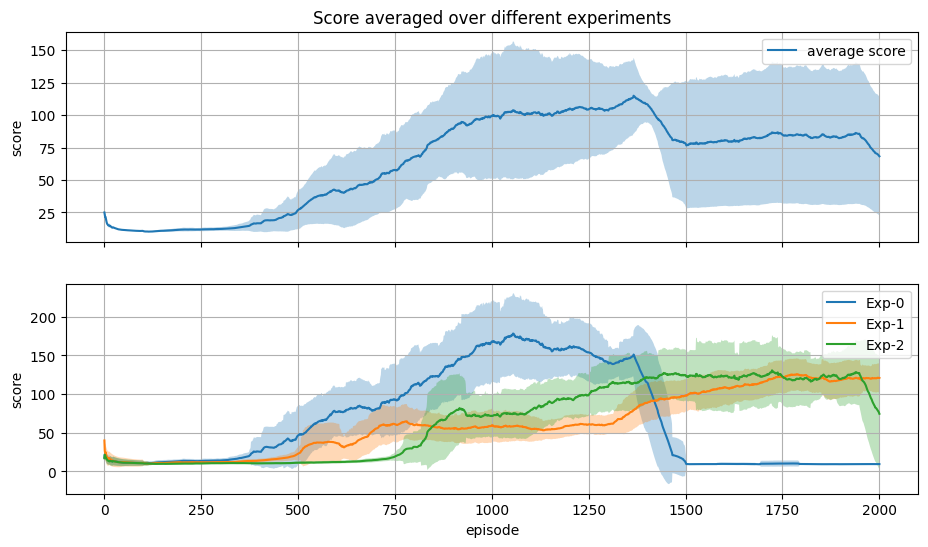

In [63]:
plot_results(avg_scores, std_scores)

Although unable to complete the Cart-Pole task (score of 500), it seems that the Replay Buffer ended up significantly improving the stability of the learning process.

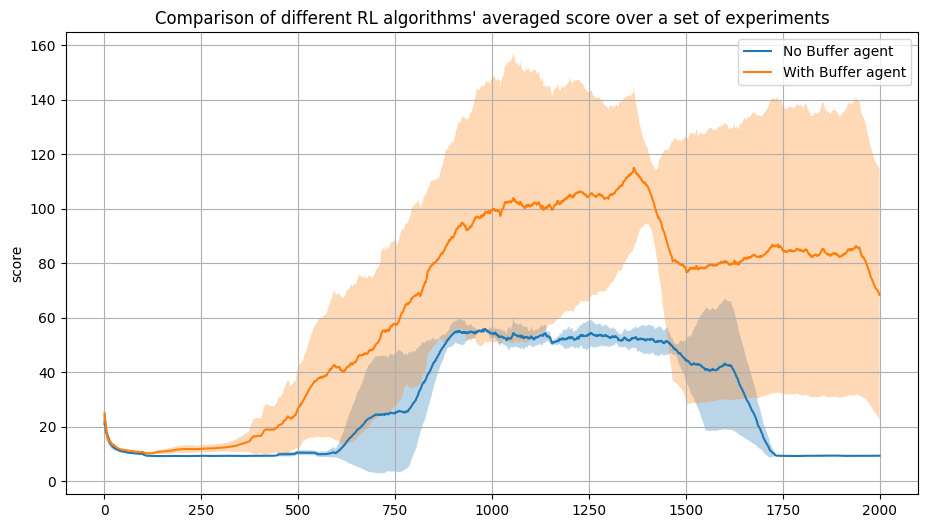

In [68]:
compare_results(results_data_dict)

It is evident from the plot above that incorporating an Experience Replay buffer as a part of the learning process significantly improves the learning stability, resulting in better performance by the agent. We should remember that the comparison could be somewhat misleading because the agent with the replay buffer trains on `Batch_size` times more samples than the agent without a replay buffer. Therefore, it is not surprising that it ends up with better performance. However, although this could be the case regarding performance, that explanation does not hold in the case of stability. The fact that the agent with the replay buffer experiences higher stability in training is only due to the decorrelations of training samples resulting from the Experience Replay Buffer usage and not due to a larger amount of training samples.

## Conclusion

We have seen in this notebook implementations of the on-policy Reinforcement Learning algorithm **Sarsa($\lambda$)** in its tabular and deep versions. It is important to note that the Eligibility Traces method combined with the concept of an Experience Replay buffer needs to be revised. The reason for that is the tension between the correlation of the training transitions to previous transitions, which is at the heart of the Eligibility Traces method, to the decorrelation of training samples, which results from using an Experience Replay Buffer. Therefore, although implemented in the current notebook, it needs a more careful examination.

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)
- [2] Peng, Williams - Incremental Multi-Step Q-Learning (1996)
- [3] Mousavi et al. - Applying Q(λ)-learning in Deep Reinforcement Learning to Play Atari Games (2018)
- [4] Shangtong Zhang, Richard S. Sutton - A Deeper Look at Experience Replay (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com